### Imports

In [1]:
import pandas as pd
import torch
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from sklearn.preprocessing import MinMaxScaler
# set max num of rows and cols to display
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

import networkx as nx


In [2]:
import random
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Usage example:
seed_everything(42)  # Set the seed to 42


In [3]:
# ! pip install torch==1.13.0+cu117 torchvision==0.14.0+cu117 torchaudio==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu117
# ! pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-1.13.0+cu117.html
# ! pip install torch_geometric
# ! pip install torchtext
## ! pip uninstall torch torch_geometric -y

### Read Pre-processed Drug-Side-Effect List 

Note: The `drug_all_se_pubchem.csv` file is generated using preprocessing with min(se) freq in total dataset > 5 and < t

In [4]:
df_all_se = pd.read_csv('../../prep_data/drug_all_se_pubchem.csv')
df_all_se.head(1)

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count,cid,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,inchi,isosmiles,canonicalsmiles,inchikey,iupacname,exactmass,monoisotopicmass,charge,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt,pclidcnt,gpidcnt,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,CID000000119,"['C0002792', 'C0030193', 'C0151828', 'C0002994...",5,119,103.12,C4H9NO2,63.3,62.7,-3.2,7,2,3,3,"InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)",C(CC(=O)O)CN,C(CC(=O)O)CN,BTCSSZJGUNDROE-UHFFFAOYSA-N,4-aminobutanoic acid,103.063,103.063,0,1,0,0,0,0,0,0,0,82230,34891,13769,2D+3D,gamma-Aminobutyric Acid,Biological Test Results|Chemical and Physical ...,15,155|157|161|165|167|175|190|248|328|357|410|41...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ..."


In [5]:
df_all_se.columns

Index(['STITCH ID STEREO', 'MEDRA TERM UMLS CONCEPT ID', 'se_count', 'cid',
       'mw', 'mf', 'polararea', 'complexity', 'xlogp', 'heavycnt',
       'hbonddonor', 'hbondacc', 'rotbonds', 'inchi', 'isosmiles',
       'canonicalsmiles', 'inchikey', 'iupacname', 'exactmass',
       'monoisotopicmass', 'charge', 'covalentunitcnt', 'isotopeatomcnt',
       'totalatomstereocnt', 'definedatomstereocnt', 'undefinedatomstereocnt',
       'totalbondstereocnt', 'definedbondstereocnt', 'undefinedbondstereocnt',
       'pclidcnt', 'gpidcnt', 'gpfamilycnt', 'neighbortype', 'meshheadings',
       'annothits', 'annothitcnt', 'aids', 'cidcdate', 'sidsrcname', 'depcatg',
       'annotation'],
      dtype='object')

In [6]:
drug_pub_prop_cols = [ 'mw', 'polararea', 'complexity','heavycnt',
       'hbonddonor', 'hbondacc', 'rotbonds']

In [7]:
df_all_se[drug_pub_prop_cols].isnull().sum()

mw            0
polararea     0
complexity    0
heavycnt      0
hbonddonor    0
hbondacc      0
rotbonds      0
dtype: int64

### Create Transformation Mapping for drug and side-effect

In [8]:
STITCH_TO_ID_DICT = {id: idx for idx, id in enumerate(df_all_se['STITCH ID STEREO'])}
ID_TO_STITCH_DICT = {v: k for k, v in STITCH_TO_ID_DICT.items()}

In [9]:
STITCHID_TO_PUBPPROP_DICT = {stid: _ for idx, (stid, _) in enumerate(zip(df_all_se['STITCH ID STEREO'], df_all_se[drug_pub_prop_cols].values))}

In [10]:
# Create a flattened list of unique meddra term concept id
column_list = df_all_se['MEDRA TERM UMLS CONCEPT ID'].tolist()
se_unique_values = list(set([item for sublist in column_list for item in eval(sublist)]))
se_unique_values.sort()

In [11]:
MEDRAID_TO_ID_DICT = {id: idx for idx, id in enumerate(se_unique_values)}
ID_TO_MEDRAID_DICT = {v: k for k, v in MEDRAID_TO_ID_DICT.items()}

In [12]:
# assert if df stitch id stereo is unique
assert len(df_all_se['STITCH ID STEREO'].unique()) == len(df_all_se['STITCH ID STEREO'])

In [13]:
from rdkit import Chem

# create a stitch_id to mol graph dict using df_all_se cannonical smiles
drug_stitich_id_mol_graph_tup = [(idx, Chem.MolFromSmiles(smiles.strip())) for idx, (st_id, smiles) in enumerate(zip(df_all_se['STITCH ID STEREO'], df_all_se['canonicalsmiles']))]

RDKit WARNING: [17:43:45] WARNING: not removing hydrogen atom without neighbors
[17:43:45] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [17:43:45] WARNING: not removing hydrogen atom without neighbors
[17:43:45] WARNING: not removing hydrogen atom without neighbors


### Create HeteroData - Node Feature

In [14]:
useMinMaxScaler = True

In [15]:
drug_node_features = torch.stack([torch.tensor(_, dtype=torch.float) for _ in df_all_se[drug_pub_prop_cols].values])
if useMinMaxScaler:
    scaler = MinMaxScaler()
    print("Before", drug_node_features.shape)
    drug_node_features = scaler.fit_transform(drug_node_features)
    print('After MinMax', drug_node_features.shape)
    drug_node_features = torch.tensor(drug_node_features, dtype=torch.float)
print("Final: UseMinMax", useMinMaxScaler, drug_node_features.shape)
# # Create a dictionary of node features
# drug_node_features = torch.tensor(np.zeros((len(df_all_se['STITCH ID STEREO']),881)))
# side_effect_node_features = torch.tensor(np.zeros((len(unique_values),881)))


# print('drug_nodes', drug_node_features.shape)
# print('side_effect_nodes', side_effect_node_features.shape)

Before torch.Size([1326, 7])
After MinMax (1326, 7)
Final: UseMinMax True torch.Size([1326, 7])


In [16]:
drug_node_features.shape

torch.Size([1326, 7])

### Create Drug View as Node Feature

In [18]:
from torch_geometric.data import Data, Batch

def create_graph_data(id):

    # id is Tensor (250.) - move to cpu get graph data and move back to cuda
    edge_index = MOL_EDGE_LIST_FEAT_MTX[id][0]
    n_features = MOL_EDGE_LIST_FEAT_MTX[id][1]  
    return edge_index, n_features
    
        

In [19]:
drug_view_node_features = [create_graph_data(id) for id in range(len(drug_stitich_id_mol_graph_tup))]

NameError: name 'MOL_EDGE_LIST_FEAT_MTX' is not defined

In [ ]:
edge_index_, n_features_ = zip(*drug_view_node_features)

### Create Know Association Edges

In [ ]:
# create edge index for drug-side effect from multi-label column_list
edge_index = []
for idx, row in df_all_se.iterrows():
    for se in eval(row['MEDRA TERM UMLS CONCEPT ID']):
        edge_index.append([STITCH_TO_ID_DICT[row['STITCH ID STEREO']], MEDRAID_TO_ID_DICT[se]])
edge_index = torch.tensor(edge_index).T

# print('side_effect_node_features', side_effect_node_features.shape)
print('edge_index', edge_index.shape)
print('edge_index', edge_index)

edge_index torch.Size([2, 129851])
edge_index tensor([[   0,    0,    0,  ..., 1325, 1325, 1325],
        [  31,  657, 1091,  ...,  462, 1221,  835]])


In [ ]:
df_all_se.head(2)

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count,cid,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,inchi,isosmiles,canonicalsmiles,inchikey,iupacname,exactmass,monoisotopicmass,charge,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt,pclidcnt,gpidcnt,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation
0,CID000000119,"['C0002792', 'C0030193', 'C0151828', 'C0002994...",5,119,103.12,C4H9NO2,63.3,62.7,-3.2,7,2,3,3,"InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)",C(CC(=O)O)CN,C(CC(=O)O)CN,BTCSSZJGUNDROE-UHFFFAOYSA-N,4-aminobutanoic acid,103.063,103.063,0,1,0,0,0,0,0,0,0,82230,34891,13769,2D+3D,gamma-Aminobutyric Acid,Biological Test Results|Chemical and Physical ...,15,155|157|161|165|167|175|190|248|328|357|410|41...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ..."
1,CID000000137,"['C0406834', 'C0027497', 'C0019080', 'C0267792...",79,137,131.13,C5H9NO3,80.4,121.0,-3.8,9,2,4,4,"InChI=1S/C5H9NO3/c6-3-4(7)1-2-5(8)9/h1-3,6H2,(...",C(CC(=O)O)C(=O)CN,C(CC(=O)O)C(=O)CN,ZGXJTSGNIOSYLO-UHFFFAOYSA-N,5-amino-4-oxopentanoic acid,131.058,131.058,0,1,0,0,0,0,0,0,0,12437,14305,4919,2D+3D,Aminolevulinic Acid,Biological Test Results|Chemical and Physical ...,14,1511|1554|1662|1663|1672|1813|1814|1832|1850|1...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN


### Feature Acquisition

#### Drug

##### Drug structure - Fingerprint

In [ ]:
df_all_se['canonicalsmiles'].isnull().sum()

0

In [ ]:
# use rdkit to convert smiles to fingerprint
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

def smiles2fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=881)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# drug_node_features = torch.stack([torch.tensor(smiles2fp(_), dtype=torch.float) for _ in df_all_se['canonicalsmiles'].values])

In [ ]:
drug_id_fv_tup = [(id, smiles2fp(smiles)) for id, smiles in zip(df_all_se['STITCH ID STEREO'], df_all_se['canonicalsmiles'])]

RDKit WARNING: [15:26:36] WARNING: not removing hydrogen atom without neighbors
[15:26:36] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [15:26:36] WARNING: not removing hydrogen atom without neighbors
[15:26:36] WARNING: not removing hydrogen atom without neighbors


In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances

# Create dataframe with drug ids and fingerprints
df = pd.DataFrame(drug_id_fv_tup, columns=['drug_id', 'fingerprint'])
df.head(1)

,drug_id,fingerprint
0,CID000000119,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
import numpy as np

fp_array = np.array([np.array(x) for x in df['fingerprint']])
dist_mat = pairwise_distances(fp_array, metric='jaccard')

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [ ]:
dist_mat.shape

NameError: name 'dist_mat' is not defined

In [ ]:
import matplotlib.pyplot as plt

# Convert to dataframe
dist_mat_df = pd.DataFrame(dist_mat)

# Melt dataframe to plot histogram 
df_melt = dist_mat_df.melt()

# Plot histogram
plt.hist(df_melt['value'], bins=10)
plt.xlabel('Jaccard Distance')
plt.ylabel('Frequency')

# Plot line at 0.5 distance  
plt.vlines(0.5, ymin=0, ymax=10, colors='r')

plt.show()

KeyboardInterrupt: 

In [ ]:
# Find drug pairs with similarity > 0.5 
dstruc_thresh = 0
drug_struct_pairs = []
drug_struct_attr = []
for i in range(len(dist_mat)):
    for j in range(i+1, len(dist_mat)):
        sim = 1 - dist_mat[i,j]
        if sim > dstruc_thresh:
            drug_struct_pairs.append([df['drug_id'].iloc[i], df['drug_id'].iloc[j]])
            drug_struct_attr.append(sim)
print(len(drug_struct_pairs), drug_struct_pairs[:5])

830115 [['CID000000119', 'CID000000137'], ['CID000000119', 'CID000000175'], ['CID000000119', 'CID000000187'], ['CID000000119', 'CID000000206'], ['CID000000119', 'CID000000244']]


In [ ]:
df.shape

(1326, 2)

In [ ]:
len(drug_struct_pairs)

830115

In [ ]:
830115//1326

626

In [ ]:
def edge_name_to_id(edge_list, map_dict):
    return [(map_dict[edge[0]], map_dict[edge[1]]) for edge in edge_list]


In [ ]:
drug_struct_pairs_id = edge_name_to_id(drug_struct_pairs, STITCH_TO_ID_DICT)

In [ ]:
drug_struct_pairs_id_edge_index = torch.tensor(drug_struct_pairs_id).T

# print('side_effect_node_features', side_effect_node_features.shape)
print('edge_index', drug_struct_pairs_id_edge_index.shape)
print('edge_index', drug_struct_pairs_id_edge_index[:5])

edge_index torch.Size([2, 830115])
edge_index tensor([[   0,    0,    0,  ..., 1323, 1323, 1324],
        [   1,    2,    3,  ..., 1324, 1325, 1325]])


##### Drug word - Mol2vec

In [ ]:
# ! pip install git+https://github.com/samoturk/mol2vec

In [ ]:
# ! pip install chardet

In [ ]:
# # gensim less than 4.0.0
# ! pip install gensim==3.8.3

In [ ]:
# ! pip install --force --upgrade -U smart_open

In [ ]:
drug_id_mol_graph_tup = [(id, Chem.MolFromSmiles(smiles.strip())) for id, smiles in zip(df_all_se['STITCH ID STEREO'], df_all_se['canonicalsmiles'])]

RDKit WARNING: [14:31:12] WARNING: not removing hydrogen atom without neighbors
[14:31:12] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:31:12] WARNING: not removing hydrogen atom without neighbors
[14:31:12] WARNING: not removing hydrogen atom without neighbors


In [ ]:
drug_id_mol_graph_df = pd.DataFrame(drug_id_mol_graph_tup, columns=['drug_id', 'mol_graph'])

In [ ]:
from gensim.models import word2vec
mol2vec_model = word2vec.Word2Vec.load('../../pretrained_models/mol2vec/model_300dim.pkl')

In [ ]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
drug_id_mol_graph_df['sentence'] = drug_id_mol_graph_df.apply(lambda x: MolSentence(mol2alt_sentence(x['mol_graph'], 1)), axis=1) # check
drug_id_mol_graph_df['mol2vec'] = [DfVec(x) for x in sentences2vec(drug_id_mol_graph_df['sentence'], mol2vec_model, unseen='UNK')] # check

In [ ]:
drug_id_mol_graph_df.head(1)

,drug_id,mol_graph,sentence,mol2vec
0,CID000000119,"<img data-content=""rdkit/molecule"" src=""data:i...","(2245384272, 1510461303, 2245384272, 116732265...","(300,) dimensional vector"


In [ ]:
# compute cosine similarity between mol2vec vectors
from sklearn.metrics.pairwise import cosine_similarity
mol2vec_sim_mat = cosine_similarity([x.vec for x in drug_id_mol_graph_df['mol2vec']])
mol2vec_sim_mat.shape

(1326, 1326)

In [ ]:
1326*1326 - 600000

1158276

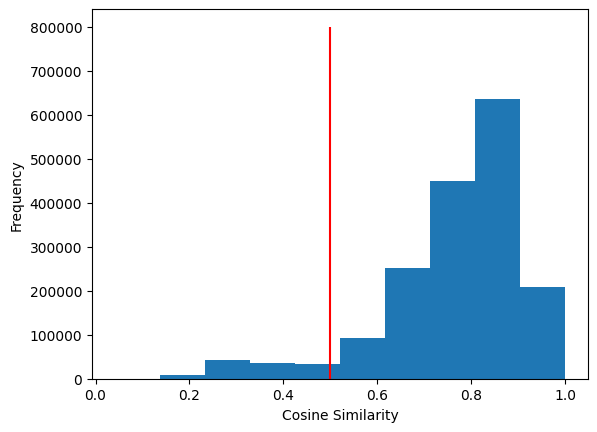

In [ ]:
# Plot histogram of cosine similarity 
plt.hist(mol2vec_sim_mat.flatten(), bins=10)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# Plot line at 0.5 distance
plt.vlines(0.5, ymin=0, ymax=800000, colors='r')

plt.show()

In [ ]:
# Find drug pairs with similarity > 0.5 
drug_word_pairs = []
drug_word_pairs_attr = []

for i in range(len(mol2vec_sim_mat)):
    for j in range(i+1, len(mol2vec_sim_mat)):
        if mol2vec_sim_mat[i,j] > 0.5:
            drug_word_pairs.append([drug_id_mol_graph_df['drug_id'].iloc[i], drug_id_mol_graph_df['drug_id'].iloc[j]])
            drug_word_pairs_attr.append(mol2vec_sim_mat[i,j])

In [ ]:
len(drug_word_pairs)

823100

In [ ]:
drug_word_pairs_id = edge_name_to_id(drug_word_pairs, STITCH_TO_ID_DICT)

In [ ]:
drug_word_pairs_id_edge_index = torch.tensor(drug_word_pairs_id).T

In [ ]:
# print('side_effect_node_features', side_effect_node_features.shape)
print('edge_index', drug_word_pairs_id_edge_index.shape)
print('edge_index', drug_word_pairs_id_edge_index[:5])

edge_index torch.Size([2, 823100])
edge_index tensor([[   0,    0,    0,  ..., 1323, 1323, 1324],
        [   1,    2,    3,  ..., 1324, 1325, 1325]])


##### Drug target - Drugbank

In [ ]:
# ! pip install biopython


In [ ]:
import xml.etree.ElementTree as ET

# Load DrugBank XML data
tree = ET.parse('../../raw_data/drugbank/full_database.xml')  # Replace with actual file path
root = tree.getroot()

drug_id_pubchem_mapping = {}  # To store DrugBank ID to PubChem ID mapping

# Extract DrugBank ID and PubChem ID mapping
for drug in root.findall(".//{http://www.drugbank.ca}drug"):
    drug_id = drug.find("{http://www.drugbank.ca}drugbank-id").text
    
    # Check if external-identifiers element is present
    external_ids = drug.find(".//{http://www.drugbank.ca}external-identifiers")
    if   external_ids is not None:
        for identifier in external_ids.findall(".//{http://www.drugbank.ca}external-identifier"):
            resource = identifier.find("{http://www.drugbank.ca}resource").text
            identifier_value = identifier.find("{http://www.drugbank.ca}identifier").text
            if resource == "PubChem Compound":
                drug_id_pubchem_mapping[drug_id] = identifier_value

# Now you have a dictionary mapping DrugBank IDs to PubChem IDs
print(drug_id_pubchem_mapping)


{'DB00006': '16129704', 'DB00014': '5311128', 'DB00027': '45267103', 'DB00050': '25074887', 'DB00080': '16134395', 'DB00091': '5284373', 'DB00093': '14257662', 'DB00104': '448601', 'DB00106': '16131215', 'DB00114': '1051', 'DB00115': '70678590', 'DB00116': '91443', 'DB00117': '6274', 'DB00118': '34755', 'DB00119': '1060', 'DB00120': '6140', 'DB00121': '171548', 'DB00122': '305', 'DB00123': '5962', 'DB00125': '6322', 'DB00126': '54670067', 'DB00127': '1103', 'DB00128': '5960', 'DB00129': '6262', 'DB00130': '5961', 'DB00131': '6083', 'DB00132': '5280934', 'DB00133': '5951', 'DB00134': '6137', 'DB00135': '6057', 'DB00136': '5280453', 'DB00137': '5281243', 'DB00138': '67678', 'DB00139': '1110', 'DB00140': '493570', 'DB00141': '1738118', 'DB00142': '33032', 'DB00143': '124886', 'DB00144': '6323481', 'DB00145': '750', 'DB00146': '5283731', 'DB00147': '1050', 'DB00148': '586', 'DB00149': '6106', 'DB00150': '6305', 'DB00151': '5862', 'DB00152': '1130', 'DB00153': '5280793', 'DB00154': '5280581

In [51]:
import os

def make_parent_dir(path):
    parent_dir = os.path.dirname(path)
    if not os.path.exists(parent_dir):
        os.makedirs(parent_dir, exist_ok=True)

In [52]:
drug_id_pubchem_mapping_dump_loc = "../../prep_data/drugbank/drug_id_pubchem_mapping.pkl"

In [53]:
## dump drug_id_pubchem_mapping to file
import pickle


make_parent_dir(drug_id_pubchem_mapping_dump_loc)

with open(drug_id_pubchem_mapping_dump_loc, 'wb') as f:
    pickle.dump(drug_id_pubchem_mapping, f)

In [54]:
## load drug_id_pubchem_mapping from file
import pickle

with open(drug_id_pubchem_mapping_dump_loc, 'rb') as f:
    drug_id_pubchem_mapping = pickle.load(f)


In [55]:
print(drug_id_pubchem_mapping)

{'DB00006': '16129704', 'DB00014': '5311128', 'DB00027': '45267103', 'DB00050': '25074887', 'DB00080': '16134395', 'DB00091': '5284373', 'DB00093': '14257662', 'DB00104': '448601', 'DB00106': '16131215', 'DB00114': '1051', 'DB00115': '70678590', 'DB00116': '91443', 'DB00117': '6274', 'DB00118': '34755', 'DB00119': '1060', 'DB00120': '6140', 'DB00121': '171548', 'DB00122': '305', 'DB00123': '5962', 'DB00125': '6322', 'DB00126': '54670067', 'DB00127': '1103', 'DB00128': '5960', 'DB00129': '6262', 'DB00130': '5961', 'DB00131': '6083', 'DB00132': '5280934', 'DB00133': '5951', 'DB00134': '6137', 'DB00135': '6057', 'DB00136': '5280453', 'DB00137': '5281243', 'DB00138': '67678', 'DB00139': '1110', 'DB00140': '493570', 'DB00141': '1738118', 'DB00142': '33032', 'DB00143': '124886', 'DB00144': '6323481', 'DB00145': '750', 'DB00146': '5283731', 'DB00147': '1050', 'DB00148': '586', 'DB00149': '6106', 'DB00150': '6305', 'DB00151': '5862', 'DB00152': '1130', 'DB00153': '5280793', 'DB00154': '5280581

In [56]:
pubchem_drug_id_mapping = {v: k for k, v in drug_id_pubchem_mapping.items()}

In [57]:
# stitch to pubchem 
def stitch_stereo_to_pubchem(cid):
    return cid[3:]
df_all_se['drugbank_id'] = df_all_se['STITCH ID STEREO'].apply(lambda x: pubchem_drug_id_mapping.get(f'{int(x[3:])}', None))

In [58]:
df_all_se['drugbank_id'].isnull().sum() 

360

In [59]:
df_all_se.head(2)

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count,cid,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,inchi,isosmiles,canonicalsmiles,inchikey,iupacname,exactmass,monoisotopicmass,charge,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt,pclidcnt,gpidcnt,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,drugbank_id
0,CID000000119,"['C0002792', 'C0030193', 'C0151828', 'C0002994...",5,119,103.12,C4H9NO2,63.3,62.7,-3.2,7,2,3,3,"InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)",C(CC(=O)O)CN,C(CC(=O)O)CN,BTCSSZJGUNDROE-UHFFFAOYSA-N,4-aminobutanoic acid,103.063,103.063,0,1,0,0,0,0,0,0,0,82230,34891,13769,2D+3D,gamma-Aminobutyric Acid,Biological Test Results|Chemical and Physical ...,15,155|157|161|165|167|175|190|248|328|357|410|41...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",DB02530
1,CID000000137,"['C0406834', 'C0027497', 'C0019080', 'C0267792...",79,137,131.13,C5H9NO3,80.4,121.0,-3.8,9,2,4,4,"InChI=1S/C5H9NO3/c6-3-4(7)1-2-5(8)9/h1-3,6H2,(...",C(CC(=O)O)C(=O)CN,C(CC(=O)O)C(=O)CN,ZGXJTSGNIOSYLO-UHFFFAOYSA-N,5-amino-4-oxopentanoic acid,131.058,131.058,0,1,0,0,0,0,0,0,0,12437,14305,4919,2D+3D,Aminolevulinic Acid,Biological Test Results|Chemical and Physical ...,14,1511|1554|1662|1663|1672|1813|1814|1832|1850|1...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,NaN,DB00855


In [60]:
all_ = list(pubchem_drug_id_mapping.keys())
all_.sort()
print(all_[:10])

['100016', '10007', '100094', '1001', '100154', '10017976', '10019998', '10024590', '10025615', '10026']


In [61]:
# import xml.etree.ElementTree as ET

# # Load DrugBank XML data
# tree = ET.parse('../../raw_data/drugbank/drugbank_all_full_database.xml/full_database.xml')  # Replace with actual file path
# root = tree.getroot()

# drug_targets = {}  # To store drug target information

# # Extract drug target information
# for drug in root.findall(".//{http://www.drugbank.ca}drug"):
#     drug_id = drug.find("{http://www.drugbank.ca}drugbank-id").text
#     targets = []
#     for target in drug.findall(".//{http://www.drugbank.ca}target"):
#         target_id = target.find("{http://www.drugbank.ca}id").text
#         targets.append(target_id)
#     drug_targets[drug_id] = targets


In [62]:
dump_loc = '../../prep_data/drugbank/drug_targets.pkl'

In [63]:
# # dump drug targets to pickle
# import pickle


# # make parent dir if not exists
# import os
# os.makedirs(os.path.dirname(dump_loc), exist_ok=True)

# with open(dump_loc, 'wb') as f:
#     pickle.dump(drug_targets, f)

In [64]:
# load pickle
import pickle
with open(dump_loc, 'rb') as fp:
    drug_targets = pickle.load(fp)

In [65]:
# unique num of targets in drug_targets
unique_targets = set([item for sublist in drug_targets.values() for item in sublist])

In [66]:
list(drug_targets.keys())[:5]

['DB00001', 'DB01022', 'DB01373', 'DB00002', 'DB00003']

In [67]:
print(len(unique_targets), list(unique_targets)[:5])

4249 ['BE0000581', 'BE0001907', 'BE0001881', 'BE0001730', 'BE0000060']


In [68]:
# filter out drugs that are not in drugbank id of df_all_se
drug_targets_stitch_inter = {k: v for k, v in drug_targets.items() if k in df_all_se['drugbank_id'].values}

In [69]:
# unique num of targets in drug_targets
unique_targets_stitch = list(set([item for sublist in drug_targets_stitch_inter.values() for item in sublist]))
unique_targets_stitch.sort()

In [70]:
print(len(unique_targets_stitch), unique_targets_stitch[:5])

912 ['BE0000001', 'BE0000005', 'BE0000006', 'BE0000011', 'BE0000012']


In [71]:
# encode one hot for drug targets
drug_targets_onehot = {}
for k, v in drug_targets_stitch_inter.items():
    drug_targets_onehot[k] = [1 if _ in v else 0 for _ in unique_targets_stitch]


In [72]:
# compute similarity between drug targets 
from sklearn.metrics.pairwise import cosine_similarity

# make a df like before similarites between drugs
drug_targets_onehot_df = pd.DataFrame(drug_targets_onehot).T

drug_targets_onehot_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812,813,814,815,816,817,818,819,820,821,822,823,824,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,901,902,903,904,905,906,907,908,909,910,911
DB00006,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [73]:
# compute cosine similarity drug targets df
drug_targets_sim_mat = cosine_similarity(drug_targets_onehot_df)

drug_targets_sim_mat.shape

(966, 966)

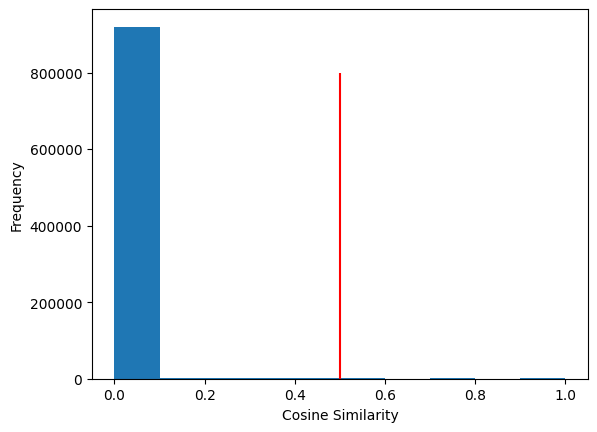

In [74]:
# plot histogram of cosine similarity
plt.hist(drug_targets_sim_mat.flatten(), bins=10)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# plot line at 0.5 distance
plt.vlines(0.5, ymin=0, ymax=800000, colors='r')

plt.show()

In [75]:
# find drug pairs with similarity > 0.5
drug_target_pairs = []
drug_target_pairs_attr = []

drug_target_thresh = 0

for i in range(len(drug_targets_sim_mat)):
    for j in range(i+1, len(drug_targets_sim_mat)):
        if drug_targets_sim_mat[i,j] > drug_target_thresh:
            drug_target_pairs.append([drug_targets_onehot_df.index[i], drug_targets_onehot_df.index[j]])
            drug_target_pairs_attr.append(drug_targets_sim_mat[i,j])

In [76]:
len(drug_target_pairs), drug_target_pairs[:5]

(6663,
 [['DB00106', 'DB00644'],
  ['DB00106', 'DB01406'],
  ['DB00106', 'DB06699'],
  ['DB00106', 'DB06825'],
  ['DB00136', 'DB00153']])

In [77]:
len(drug_targets_onehot['DB00006'])

912

In [78]:
drugbank_to_stitch_map_dict = {k: v for k, v in zip(df_all_se['drugbank_id'], df_all_se['STITCH ID STEREO'])}

In [79]:
drug_target_pairs_id = edge_name_to_id(drug_target_pairs, drugbank_to_stitch_map_dict)

In [80]:
drug_target_pairs_id = edge_name_to_id(drug_target_pairs_id, STITCH_TO_ID_DICT)
drug_target_pairs_id_edge_index = torch.tensor(drug_target_pairs_id).T
# print('side_effect_node_features', side_effect_node_features.shape)
print('edge_index', drug_target_pairs_id_edge_index.shape)
print('edge_index', drug_target_pairs_id_edge_index[:5])

edge_index torch.Size([2, 6663])
edge_index tensor([[1271, 1271, 1271,  ...,  771,  771,  525],
        [ 656,  626, 1281,  ...,  525,  564,  564]])


In [81]:
# to-do: load paper 40 sim matrix and check the num of edges there

##### Drug SE Interaction Profile - Drugbank

In [82]:
df_all_se.head(1)

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count,cid,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,inchi,isosmiles,canonicalsmiles,inchikey,iupacname,exactmass,monoisotopicmass,charge,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt,pclidcnt,gpidcnt,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,drugbank_id
0,CID000000119,"['C0002792', 'C0030193', 'C0151828', 'C0002994...",5,119,103.12,C4H9NO2,63.3,62.7,-3.2,7,2,3,3,"InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)",C(CC(=O)O)CN,C(CC(=O)O)CN,BTCSSZJGUNDROE-UHFFFAOYSA-N,4-aminobutanoic acid,103.063,103.063,0,1,0,0,0,0,0,0,0,82230,34891,13769,2D+3D,gamma-Aminobutyric Acid,Biological Test Results|Chemical and Physical ...,15,155|157|161|165|167|175|190|248|328|357|410|41...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",DB02530


In [83]:
# target multi-label multi-class encoding
def all_of_k_encoding_unk(x, allowable_set):
    enc = np.zeros(len(allowable_set))
    for idx, side_eff_id in enumerate(allowable_set):
        if side_eff_id in x:
            enc[idx] = 1
    return enc
# Feature one-hot encoding
def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


In [84]:
allowable_set_side_eff = se_unique_values

In [85]:
allowable_set_side_eff[:4]

['C0000727', 'C0000731', 'C0000737', 'C0000768']

In [86]:
# generate multi-label multi-class drug-se dataset using df_all_se - STITCH ID STEREO, MEDRA TERM UMLS CONCEPT ID
df_all_se['se_encoded'] = df_all_se['MEDRA TERM UMLS CONCEPT ID'].apply(lambda x: all_of_k_encoding_unk(eval(x), se_unique_values))

In [87]:
df_all_se.head(1)

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count,cid,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,inchi,isosmiles,canonicalsmiles,inchikey,iupacname,exactmass,monoisotopicmass,charge,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt,pclidcnt,gpidcnt,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,drugbank_id,se_encoded
0,CID000000119,"['C0002792', 'C0030193', 'C0151828', 'C0002994...",5,119,103.12,C4H9NO2,63.3,62.7,-3.2,7,2,3,3,"InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)",C(CC(=O)O)CN,C(CC(=O)O)CN,BTCSSZJGUNDROE-UHFFFAOYSA-N,4-aminobutanoic acid,103.063,103.063,0,1,0,0,0,0,0,0,0,82230,34891,13769,2D+3D,gamma-Aminobutyric Acid,Biological Test Results|Chemical and Physical ...,15,155|157|161|165|167|175|190|248|328|357|410|41...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",DB02530,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [88]:
print(allowable_set_side_eff.index('C0002792'))
print(df_all_se['se_encoded'].tolist()[0][31])

31
1.0


In [89]:
# compute similarity between drugs using se_encoded
from sklearn.metrics.pairwise import cosine_similarity

# make a df like before similarites between drugs

drug_se_encoded_df = pd.DataFrame(df_all_se['se_encoded'].tolist(), columns=se_unique_values, index=df_all_se['STITCH ID STEREO'])

drug_se_encoded_df.head(1)

,C0000727,C0000731,C0000737,C0000768,C0000786,C0000833,C0001122,C0001125,C0001126,C0001127,C0001175,C0001339,C0001361,C0001364,C0001403,C0001418,C0001430,C0001622,C0001623,C0001807,C0001824,C0001925,C0001973,C0002063,C0002064,C0002170,C0002390,C0002418,C0002453,C0002622,C0002624,C0002792,C0002871,C0002874,C0002878,C0002880,C0002884,C0002886,C0002888,C0002902,C0002928,C0002940,C0002957,C0002962,C0002963,C0002965,C0002994,C0003028,C0003079,C0003126,C0003431,C0003460,C0003467,C0003469,C0003486,C0003507,C0003537,C0003564,C0003578,C0003615,C0003621,C0003635,C0003708,C0003811,C0003813,C0003834,C0003838,C0003850,C0003860,C0003862,C0003864,C0003868,C0003873,C0003962,C0004044,C0004093,C0004095,C0004096,C0004134,C0004144,C0004238,C0004239,C0004245,C0004364,C0004509,C0004604,C0004610,C0004623,C0004626,C0004690,C0004691,C0004936,C0004998,C0005586,C0005683,C0005684,C0005697,C0005741,C0005745,C0005747,C0005758,C0005779,C0005818,C0005940,C0006118,C0006142,C0006145,C0006147,C0006152,C0006266,C0006272,C0006277,C0006285,C0006325,C0006384,C0006444,C0006625,C0006663,C0006826,C0006840,C0006846,C0006849,C0007114,C0007117,C0007134,C0007137,C0007166,C0007177,C0007193,C0007194,C0007222,C0007286,C0007398,C0007642,C0007760,C0007773,C0007780,C0007785,C0007787,C0007820,C0007859,C0007860,C0007867,C0007868,C0007869,C0007971,C0008031,C0008033,C0008049,C0008301,C0008311,C0008325,C0008350,C0008370,C0008489,C0008925,C0009024,C0009144,C0009241,C0009319,C0009324,C0009326,C0009421,C0009450,C0009492,C0009676,C0009759,C0009760,C0009763,C0009766,C0009782,C0009806,C0009917,C0009938,C0009946,C0010032,C0010034,C0010037,C0010038,C0010043,C0010072,C0010073,C0010200,C0010346,C0010399,C0010414,C0010481,C0010520,C0010692,C0010709,C0010823,C0011053,C0011057,C0011071,C0011124,C0011127,C0011168,C0011175,C0011206,C0011253,C0011334,C0011551,C0011570,C0011603,C0011606,C0011609,C0011615,C0011616,C0011630,C0011633,C0011644,C0011649,C0011848,C0011849,C0011860,C0011880,C0011882,C0011884,C0011974,C0011991,C0012569,C0012691,C0012739,C0012813,C0012817,C0012833,C0013080,C0013132,C0013146,C0013182,C0013220,C0013274,C0013295,C0013298,C0013362,C0013378,C0013384,C0013390,C0013395,C0013404,C0013415,C0013428,C0013447,C0013456,C0013473,C0013491,C0013595,C0013604,C0013609,C0013687,C0013781,C0013922,C0013928,C0014038,C0014118,C0014130,C0014173,C0014175,C0014179,C0014236,C0014335,C0014356,C0014394,C0014457,C0014518,C0014534,C0014544,C0014549,C0014553,C0014583,C0014591,C0014724,C0014742,C0014743,C0014745,C0014804,C0014848,C0014852,C0014860,C0014863,C0014866,C0014867,C0014868,C0015230,C0015256,C0015300,C0015371,C0015376,C0015393,C0015395,C0015397,C0015402,C0015403,C0015423,C0015468,C0015624,C0015663,C0015672,C0015732,C0015734,C0015802,C0015927,C0015929,C0015930,C0015934,C0015967,C0016034,C0016053,C0016059,C0016167,C0016169,C0016199,C0016204,C0016242,C0016382,C0016385,C0016397,C0016412,C0016436,C0016470,C0016479,C0016579,C0016655,C0016658,C0016977,C0017086,C0017152,C0017160,C0017168,C0017178,C0017181,C0017411,C0017563,C0017565,C0017566,C0017567,C0017574,C0017601,C0017605,C0017658,C0017672,C0017675,C0017979,C0018021,C0018099,C0018129,C0018133,C0018188,C0018213,C0018378,C0018418,C0018500,C0018520,C0018524,C0018621,C0018674,C0018681,C0018784,C0018790,C0018799,C0018800,C0018801,C0018802,C0018808,C0018813,C0018818,C0018824,C0018843,C0018916,C0018924,C0018926,C0018932,C0018939,C0018944,C0018946,C0018965,C0018979,C0018989,C0018991,C0019048,C0019054,C0019061,C0019064,C0019065,C0019079,C0019080,C0019087,C0019112,C0019123,C0019147,C0019151,C0019156,C0019158,C0019159,C0019163,C0019193,C0019196,C0019209,C0019212,C0019214,C0019243,C0019270,C0019294,C0019348,C0019357,C0019360,C0019372,C0019521,C0019557,C0019572,C0019829,C0019917,C0019937,C0020039,C0020175,C0020255,C0020295,C0020429,C0020433,C0020437,C0020438,C0020440,C0020443,C0020452,C0020453,C0020456,C0020457,C0020458,C0020459,C0020461,C0020473,C0020488,C0020502,C0020505,C0020507,C0020510,C0020514,C0020517,C0020522,C0020523,C0020538,C0020540,C0020542,C0020546,C00

In [90]:
# compute cosine similarity drug targets df
drug_se_encoded_sim_mat = cosine_similarity(drug_se_encoded_df)

drug_se_encoded_sim_mat.shape

(1326, 1326)

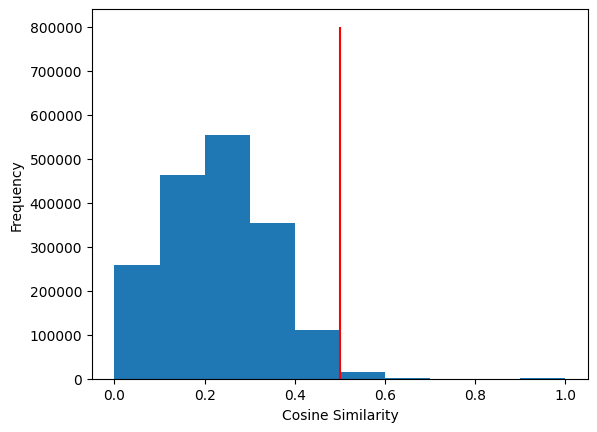

In [91]:
# plot histogram of cosine similarity
plt.hist(drug_se_encoded_sim_mat.flatten(), bins=10)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# plot line at 0.5 distance
plt.vlines(0.5, ymin=0, ymax=800000, colors='r')

plt.show()

In [92]:
# find drug pairs with similarity > 0.5
drug_se_encoded_pairs = []
drug_se_encoded_pairs_attr = []

drug_se_encoded_thresh = 0

for i in range(len(drug_se_encoded_sim_mat)):
    for j in range(i+1, len(drug_se_encoded_sim_mat)):
        if drug_se_encoded_sim_mat[i,j] > drug_se_encoded_thresh:
            drug_se_encoded_pairs.append([drug_se_encoded_df.index[i], drug_se_encoded_df.index[j]])
            drug_se_encoded_pairs_attr.append(drug_se_encoded_sim_mat[i,j])

len(drug_se_encoded_pairs), drug_se_encoded_pairs[:5]

(842128,
 [['CID000000119', 'CID000000137'],
  ['CID000000119', 'CID000000175'],
  ['CID000000119', 'CID000000206'],
  ['CID000000119', 'CID000000222'],
  ['CID000000119', 'CID000000244']])

In [93]:
drug_se_encoded_pairs_id = edge_name_to_id(drug_se_encoded_pairs, STITCH_TO_ID_DICT)
drug_se_encoded_pairs_id_edge_index = torch.tensor(drug_se_encoded_pairs_id).T
# print('side_effect_node_features', side_effect_node_features.shape)
print('edge_index', drug_se_encoded_pairs_id_edge_index.shape)
print('edge_index', drug_se_encoded_pairs_id_edge_index[:5])

edge_index torch.Size([2, 842128])
edge_index tensor([[   0,    0,    0,  ..., 1323, 1323, 1324],
        [   1,    2,    4,  ..., 1324, 1325, 1325]])


In [94]:
# Drug Similarities
# df_stitch = pd.read_csv('../../raw_data/stitch/chemical_chemical.links.v5.0.tsv/chemical_chemical.links.v5.0.tsv', sep='\t')
# df_stitch.head()

#### Side-Effect Features

##### SE Word Vec

In [95]:
import torchtext.vocab as vocab

# Load pre-trained GloVe vectors
glove = vocab.GloVe(name='6B', dim=300)

In [96]:
df_all_se.head(1)

,STITCH ID STEREO,MEDRA TERM UMLS CONCEPT ID,se_count,cid,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,inchi,isosmiles,canonicalsmiles,inchikey,iupacname,exactmass,monoisotopicmass,charge,covalentunitcnt,isotopeatomcnt,totalatomstereocnt,definedatomstereocnt,undefinedatomstereocnt,totalbondstereocnt,definedbondstereocnt,undefinedbondstereocnt,pclidcnt,gpidcnt,gpfamilycnt,neighbortype,meshheadings,annothits,annothitcnt,aids,cidcdate,sidsrcname,depcatg,annotation,drugbank_id,se_encoded
0,CID000000119,"['C0002792', 'C0030193', 'C0151828', 'C0002994...",5,119,103.12,C4H9NO2,63.3,62.7,-3.2,7,2,3,3,"InChI=1S/C4H9NO2/c5-3-1-2-4(6)7/h1-3,5H2,(H,6,7)",C(CC(=O)O)CN,C(CC(=O)O)CN,BTCSSZJGUNDROE-UHFFFAOYSA-N,4-aminobutanoic acid,103.063,103.063,0,1,0,0,0,0,0,0,0,82230,34891,13769,2D+3D,gamma-Aminobutyric Acid,Biological Test Results|Chemical and Physical ...,15,155|157|161|165|167|175|190|248|328|357|410|41...,20040916,001Chemical|3B Scientific (Wuhan) Corp|3WAY PH...,Chemical Vendors|Curation Efforts|Governmental...,"COVID-19, COVID19, Coronavirus, Corona-virus, ...",DB02530,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [97]:
import pandas as pd
# read raw_data/sider/meddra_all_se.tsv to get side effect name
meddra_all_se_df = pd.read_csv('../../raw_data/sider/meddra_all_se.tsv', sep='\t',
                               header=None)
meddra_all_se_df.head(1) 

,0,1,2,3,4,5
0,CID100000085,CID000010917,C0000729,LLT,C0000729,Abdominal cramps


In [98]:
se_uml_to_se_name_dict = {se_uml_id: se_name for se_uml_id, se_name in zip(meddra_all_se_df.iloc[:, 2].values, meddra_all_se_df.iloc[:, -1].values)}

In [99]:
se_uml_to_se_name_dict

{'C0000729': 'Abdominal pain',
 'C0000737': 'Abdominal pain',
 'C0002418': 'Amblyopia',
 'C0002871': 'Anaemia',
 'C0003123': 'Decreased appetite',
 'C0003467': 'Anxiety',
 'C0003811': 'Arrhythmia',
 'C0004093': 'Asthenia',
 'C0004238': 'Atrial fibrillation',
 'C0004604': 'Back pain',
 'C0006277': 'Bronchitis',
 'C0007222': 'Cardiovascular disorder',
 'C0008031': 'Chest pain',
 'C0009450': 'Infection',
 'C0009806': 'Constipation',
 'C0010200': 'Cough',
 'C0011570': 'Depression',
 'C0011991': 'Diarrhoea',
 'C0012833': 'Dizziness',
 'C0013378': 'Dysgeusia',
 'C0013395': 'Dyspepsia',
 'C0013404': 'Dyspnoea',
 'C0015230': 'Dermatitis',
 'C0015397': 'Eye disorder',
 'C0015967': 'Body temperature increased',
 'C0017152': 'Gastritis',
 'C0017178': 'Gastrointestinal disorder',
 'C0018681': 'Headache',
 'C0019080': 'Haemoglobin',
 'C0020437': 'Hypercalcaemia',
 'C0020461': 'Hyperkalaemia',
 'C0020517': 'Hypersensitivity',
 'C0020538': 'Hypertension',
 'C0020649': 'Hypotension',
 'C0021400': 'Inf

In [100]:
# using df_all_se - STITCH ID STEREO, MEDRA TERM UMLS CONCEPT ID
se_uml_to_se_name_tup = [(se_uml_id, se_name) for se_uml_id, se_name in zip(meddra_all_se_df.iloc[:, 2].values, meddra_all_se_df.iloc[:, -1].values)]

In [101]:
se_uml_to_se_name_tup[:3]

[('C0000729', 'Abdominal cramps'),
 ('C0000729', 'Abdominal pain'),
 ('C0000737', 'Abdominal pain')]

In [102]:
len(se_uml_to_se_name_tup)

309849

In [103]:
# se_uml_to_se_name_tup_filter = [tup for tup in se_uml_to_se_name_tup if tup[0] in unique_values]
# create default dict with se_name for se in unique_values using se_uml_to_se_name_tup
from collections import defaultdict
se_uml_to_se_name_dict = defaultdict(set)
for se_uml_id, se_name in se_uml_to_se_name_tup:
    if se_uml_id in se_unique_values:
        se_uml_to_se_name_dict[se_uml_id].add(se_name.strip())

se_uml_to_se_name_dict

defaultdict(set,
            {'C0000737': {'Abdominal pain', 'Gastrointestinal pain'},
             'C0002418': {'Amblyopia'},
             'C0002871': {'Anaemia'},
             'C0003467': {'Anxiety'},
             'C0003811': {'Arrhythmia'},
             'C0004093': {'Asthenia'},
             'C0004238': {'Atrial fibrillation'},
             'C0004604': {'Back pain'},
             'C0006277': {'Bronchitis'},
             'C0007222': {'Cardiovascular disorder'},
             'C0008031': {'Chest pain'},
             'C0009450': {'Infection'},
             'C0009806': {'Constipation'},
             'C0010200': {'Cough'},
             'C0011570': {'Depression'},
             'C0011991': {'Diarrhoea'},
             'C0012833': {'Dizziness'},
             'C0013378': {'Dysgeusia'},
             'C0013395': {'Dyspepsia'},
             'C0013404': {'Dyspnoea'},
             'C0015230': {'Dermatitis', 'Rash'},
             'C0015397': {'Eye disorder'},
             'C0015967': {'Body temperat

In [104]:
len(se_uml_to_se_name_dict.keys())

1987

In [105]:
len(se_unique_values)

2061

In [106]:
def get_glove_emb(se_name_list):
    if not se_name_list:
        return None
    final_emb = []
    for se_name in se_name_list:
        words = se_name.split()  # Split the side effect name into words
        embeddings = [glove[word] for word in words if word in glove.stoi]
        if not embeddings:
            # Handle synonyms or rare words here
            embeddings = [glove['unk']]
        average_embedding = sum(embeddings) / len(embeddings)
        final_emb.append(average_embedding)
    # average the embeddings for all side effects
    final_emb = sum(final_emb) / len(final_emb)
    return final_emb

In [107]:
# find se-se pairs with similarity > 0.5
se_name_emb = [(se_uml_id, get_glove_emb(se_name_list)) for se_uml_id, se_name_list in se_uml_to_se_name_dict.items()]

se_name_emb[0][0], se_name_emb[0][1].shape

('C0000737', torch.Size([300]))

In [108]:
# compute similarity between se using se_name_emb
from sklearn.metrics.pairwise import cosine_similarity

# make a df like before similarites between drugs

se_name_emb_df = pd.DataFrame([x[1] for x in se_name_emb if x[1] is not None], index=[x[0] for x in se_name_emb if x[1] is not None])

se_name_emb_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
C0000737,tensor(-0.2449),tensor(0.0885),tensor(0.2218),tensor(0.1922),tensor(0.1558),tensor(-0.4548),tensor(0.0456),tensor(-0.2132),tensor(-0.3953),tensor(-1.2101),tensor(0.1739),tensor(-0.0189),tensor(-1.0295),tensor(0.2184),tensor(0.3466),tensor(0.6645),tensor(-0.6260),tensor(0.3227),tensor(-0.1865),tensor(0.0515),tensor(-0.0587),tensor(-0.4450),tensor(-0.1172),tensor(-0.2285),tensor(-1.0135),tensor(0.4119),tensor(0.1632),tensor(-0.5796),tensor(0.5635),tensor(0.2120),tensor(-0.3833),tensor(0.7033),tensor(-0.0218),tensor(-0.5220),tensor(-1.0391),tensor(-0.2163),tensor(-0.3873),tensor(0.2752),tensor(-0.0488),tensor(0.2232),tensor(-0.4490),tensor(0.0277),tensor(-0.2378),tensor(-0.9048),tensor(0.5101),tensor(-0.3063),tensor(0.1551),tensor(-0.0689),tensor(0.4557),tensor(0.5698),tensor(0.7111),tensor(0.0559),tensor(0.4096),tensor(-0.0745),tensor(-0.4618),tensor(-0.0743),tensor(0.3861),tensor(-0.0534),tensor(0.3307),tensor(0.7202),tensor(0.4574),tensor(-0.3216),tensor(0.1920),tensor(-0.1022),tensor(-0.3331),tensor(-0.8034),tensor(-0.1547),tensor(-0.0098),tensor(0.3751),tensor(0.0291),tensor(0.3469),tensor(-0.3931),tensor(-0.0735),tensor(0.3498),tensor(0.1383),tensor(-0.8467),tensor(0.4398),tensor(-0.2766),tensor(-0.2656),tensor(0.4427),tensor(0.3427),tensor(-0.4287),tensor(0.3599),tensor(-0.2447),tensor(-0.5911),tensor(-0.1090),tensor(0.2915),tensor(0.3893),tensor(-0.3304),tensor(0.4856),tensor(0.0173),tensor(0.1487),tensor(-0.3211),tensor(-0.1145),tensor(-0.0885),tensor(-0.3095),tensor(0.0878),tensor(-0.6792),tensor(0.5998),tensor(-0.6518),tensor(0.2084),tensor(-0.2571),tensor(-0.2927),tensor(0.0423),tensor(-0.1604),tensor(0.5383),tensor(-0.0067),tensor(-0.1664),tensor(0.0976),tensor(0.3792),tensor(-0.7433),tensor(0.0944),tensor(-0.2769),tensor(-0.4004),tensor(0.3571),tensor(0.2973),tensor(0.1771),tensor(0.0989),tensor(-0.1860),tensor(-0.1929),tensor(-0.1859),tensor(-0.5423),tensor(-0.5522),tensor(0.2015),tensor(0.2574),tensor(-0.2157),tensor(0.1071),tensor(-0.4141),tensor(0.1612),tensor(0.5724),tensor(0.8524),tensor(-0.2131),tensor(0.3256),tensor(0.6754),tensor(-0.7900),tensor(-0.2666),tensor(-0.7988),tensor(0.1203),tensor(0.0568),tensor(0.3963),tensor(-0.0378),tensor(0.1830),tensor(-0.1065),tensor(0.9753),tensor(-0.2195),tensor(0.2659),tensor(-0.0891),tensor(0.2714),tensor(-0.3907),tensor(0.2784),tensor(-0.6656),tensor(0.1132),tensor(0.3633),tensor(0.1618),tensor(-0.2780),tensor(0.3347),tensor(-0.1189),tensor(0.2182),tensor(-0.1125),tensor(-0.2179),tensor(0.3043),tensor(-0.5896),tensor(0.0483),tensor(-0.4314),tensor(-0.1668),tensor(0.8142),tensor(0.2935),tensor(0.0420),tensor(0.2576),tensor(0.0973),tensor(0.0770),tensor(0.0279),tensor(0.0159),tensor(-0.2856),tensor(-0.5493),tensor(-0.0887),tensor(-0.1154),tensor(0.1241),tensor(0.1644),tensor(0.6473),tensor(-0.3401),tensor(-0.0890),tensor(-0.4377),tensor(-0.1659),tensor(-0.1471),tensor(0.0972),tensor(0.1285),t

In [109]:
# compute cosine similarity between se_name_emb_df
se_name_emb_sim_mat = cosine_similarity(se_name_emb_df)

se_name_emb_sim_mat.shape

(1987, 1987)

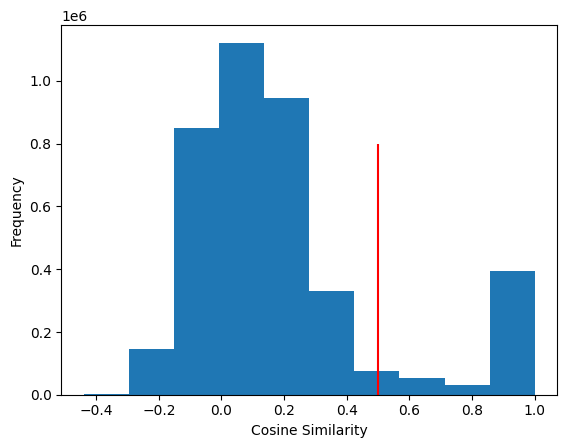

In [110]:
import matplotlib.pyplot as plt
# plot histogram of cosine similarity
plt.hist(se_name_emb_sim_mat.flatten(), bins=10)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# plot line at 0.5 distance
plt.vlines(0.5, ymin=0, ymax=800000, colors='r')

plt.show()


In [111]:
# find se pairs with similarity > 0.5
se_name_emb_pairs = []
se_name_emb_pairs_attr = []

se_name_emb_thresh = 0

for i in range(len(se_name_emb_sim_mat)):
    for j in range(i+1, len(se_name_emb_sim_mat)):
        if se_name_emb_sim_mat[i,j] > se_name_emb_thresh:
            se_name_emb_pairs.append([se_name_emb_df.index[i], se_name_emb_df.index[j]])
            se_name_emb_pairs_attr.append(se_name_emb_sim_mat[i,j])

len(se_name_emb_pairs), se_name_emb_pairs[:5]

(1452930,
 [['C0000737', 'C0004238'],
  ['C0000737', 'C0004604'],
  ['C0000737', 'C0007222'],
  ['C0000737', 'C0008031'],
  ['C0000737', 'C0015397']])

In [112]:
se_name_emb_pairs_id = edge_name_to_id(se_name_emb_pairs, MEDRAID_TO_ID_DICT)
se_name_emb_pairs_id_edge_index = torch.tensor(se_name_emb_pairs_id).T
# print('side_effect_node_features', side_effect_node_features.shape)
print('edge_index', se_name_emb_pairs_id_edge_index.shape)
print('edge_index', se_name_emb_pairs_id_edge_index[:5])

edge_index torch.Size([2, 1452930])
edge_index tensor([[   2,    2,    2,  ..., 1981, 1981, 2050],
        [  80,   85,  130,  ..., 2050, 1580, 1580]])


##### Side-Effect Drug Interaction profile

In [113]:
se_unique_values[:4]

['C0000727', 'C0000731', 'C0000737', 'C0000768']

In [114]:
# # for each side_effect create a list of drugs and compute similarity between side_effects using cosine similarity
# side_eff_drugs_dict = {}
# for side_eff in se_unique_values:
#     side_eff_drugs_dict[side_eff] = df_all_se[df_all_se['MEDRA TERM UMLS CONCEPT ID'].apply(lambda x: side_eff in eval(x))]['STITCH ID STEREO'].tolist()

In [115]:
# # dump side_eff_drugs_dict to pickle
# import pickle
# side_eff_drugs_inter_dump_loc = '../../prep_data/sider/side_eff_drugs_dict.pkl'

# make_parent_dir(side_eff_drugs_inter_dump_loc)


# with open(side_eff_drugs_inter_dump_loc, 'wb') as f:
#     pickle.dump(side_eff_drugs_dict, f)

In [116]:
# # load pickle
# import pickle

# with open(side_eff_drugs_inter_dump_loc, 'rb') as fp:
#     side_eff_drugs_dict = pickle.load(fp)

In [117]:
# effecient way using drug_se_encoded_df transpose
se_drug_encoded_df = drug_se_encoded_df.T

se_drug_encoded_df.head(1)

STITCH ID STEREO,CID000000119,CID000000137,CID000000175,CID000000187,CID000000206,CID000000222,CID000000244,CID000000247,CID000000271,CID000000297,CID000000311,CID000000312,CID000000338,CID000000444,CID000000564,CID000000598,CID000000612,CID000000679,CID000000681,CID000000700,CID000000727,CID000000750,CID000000753,CID000000772,CID000000774,CID000000785,CID000000813,CID000000888,CID000000896,CID000000923,CID000000937,CID000000942,CID000000946,CID000000948,CID000000961,CID000001046,CID000001054,CID000001130,CID000001727,CID000001775,CID000001978,CID000001983,CID000001986,CID000001990,CID000001993,CID000002019,CID000002082,CID000002083,CID000002088,CID000002092,CID000002099,CID000002118,CID000002123,CID000002130,CID000002140,CID000002141,CID000002145,CID000002148,CID000002153,CID000002159,CID000002160,CID000002161,CID000002162,CID000002170,CID000002179,CID000002187,CID000002216,CID000002244,CID000002249,CID000002265,CID000002266,CID000002267,CID000002284,CID000002315,CID000002337,CID000002345,CID000002349,CID000002351,CID000002366,CID000002369,CID000002370,CID000002375,CID000002391,CID000002405,CID000002431,CID000002435,CID000002441,CID000002442,CID000002462,CID000002471,CID000002474,CID000002477,CID000002478,CID000002479,CID000002484,CID000002519,CID000002520,CID000002540,CID000002541,CID000002551,CID000002554,CID000002564,CID000002576,CID000002578,CID000002583,CID000002585,CID000002610,CID000002662,CID000002663,CID000002678,CID000002708,CID000002712,CID000002719,CID000002720,CID000002725,CID000002726,CID000002727,CID000002732,CID000002733,CID000002749,CID000002754,CID000002756,CID000002762,CID000002764,CID000002767,CID000002771,CID000002789,CID000002794,CID000002801,CID000002802,CID000002803,CID000002809,CID000002812,CID000002895,CID000002905,CID000002907,CID000002913,CID000002955,CID000002972,CID000002973,CID000002995,CID000003007,CID000003009,CID000003016,CID000003019,CID000003032,CID000003038,CID000003042,CID000003053,CID000003059,CID000003080,CID000003100,CID000003105,CID000003108,CID000003114,CID000003117,CID000003121,CID000003151,CID000003152,CID000003156,CID000003157,CID000003158,CID000003168,CID000003182,CID000003198,CID000003202,CID000003219,CID000003226,CID000003241,CID000003261,CID000003278,CID000003279,CID000003291,CID000003292,CID000003305,CID000003308,CID000003324,CID000003331,CID000003333,CID000003339,CID000003342,CID000003345,CID000003348,CID000003354,CID000003365,CID000003366,CID000003372,CID000003373,CID000003380,CID000003385,CID000003386,CID000003388,CID000003393,CID000003394,CID000003397,CID000003406,CID000003410,CID000003440,CID000003446,CID000003463,CID000003467,CID000003475,CID000003476,CID000003478,CID000003488,CID000003494,CID000003510,CID000003516,CID000003517,CID000003519,CID000003520,CID000003559,CID000003598,CID000003623,CID000003637,CID000003639,CID000003647,CID000003652,CID000003657,CID000003658,CID000003661,CID000003672,CID000003675,CID000003676,CID000003690,CID000003696,CID000003702,CID000003715,CID000003724,CID000003730,CID000003736,CID000003737,CID000003738,CID000003739,CID000003741,CID000003742,CID000003743,CID000003746,CID000003749,CID000003759,CID000003763,CID000003767,CID000003779,CID000003784,CID000003821,CID000003825,CID000003826,CID000003827,CID000003830,CID000003848,CID000003869,CID000003878,CID000003883,CID000003899,CID000003902,CID000003948,CID000003950,CID000003957,CID000003958,CID000003961,CID000003964,CID000003998,CID000004004,CID000004011,CID000004030,CID000004031,CID000004032,CID000004033,CID000004034,CID000004036,CID000004044,CID000004054,CID000004057,CID000004058,CID000004060,CID000004062,CID000004064,CID000004075,CID000004086,CID000004091,CID000004095,CID000004100,CID000004101,CID000004107,CID000004114,CID000004120,CID000004121,CID000004139,CID000004158,CID000004168,CID000004170,CID000004171,CID000004173,CID000004174,CID000004178,CID000004184,CID000004189,CID000004192,CID000004195,CID000004197,CID000004201,CID000004205,CID000004211,CID000004212,CID000004235,CID000004236,CID00

In [118]:
se_unique_values[:4]

['C0000727', 'C0000731', 'C0000737', 'C0000768']

In [119]:
# compute cosine similarity between side effects
from sklearn.metrics.pairwise import cosine_similarity

# make a df like before similarites between drugs
se_drug_encoded_sim_mat = cosine_similarity(se_drug_encoded_df)

se_drug_encoded_sim_mat.shape

(2061, 2061)

In [120]:
len(se_unique_values)

2061

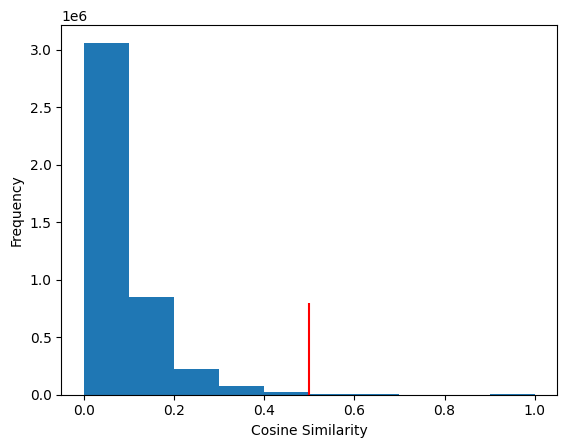

In [121]:
# plot histogram of cosine similarity
plt.hist(se_drug_encoded_sim_mat.flatten(), bins=10)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')

# plot line at 0.5 distance
plt.vlines(0.5, ymin=0, ymax=800000, colors='r')

plt.show()

In [122]:
# find se pairs with similarity > 0.5
se_drug_encoded_pairs = []
se_drug_encoded_pairs_attr = []

se_drug_encoded_thresh = 0

for i in range(len(se_drug_encoded_sim_mat)):
    for j in range(i+1, len(se_drug_encoded_sim_mat)):
        if se_drug_encoded_sim_mat[i,j] >se_drug_encoded_thresh:
            se_drug_encoded_pairs.append([se_drug_encoded_df.index[i], se_drug_encoded_df.index[j]])
            se_drug_encoded_pairs_attr.append(se_drug_encoded_sim_mat[i,j])

len(se_drug_encoded_pairs), se_drug_encoded_pairs[:5]

(1218303,
 [['C0000727', 'C0000731'],
  ['C0000727', 'C0000737'],
  ['C0000727', 'C0000833'],
  ['C0000727', 'C0001122'],
  ['C0000727', 'C0001430']])

In [123]:
# se_drug_encoded_pairs to edge_index
se_drug_encoded_pairs_id = edge_name_to_id(se_drug_encoded_pairs, MEDRAID_TO_ID_DICT)
se_drug_encoded_pairs_id_edge_index = torch.tensor(se_drug_encoded_pairs_id).T

print('edge_index', se_drug_encoded_pairs_id_edge_index.shape)
print('edge_index', se_drug_encoded_pairs_id_edge_index[:5])

edge_index torch.Size([2, 1218303])
edge_index tensor([[   0,    0,    0,  ..., 2057, 2058, 2058],
        [   1,    2,    5,  ..., 2058, 2059, 2060]])


##### SE ATC 

In [124]:
import pandas as pd

atc_sim_df = pd.read_csv("../se_semantic_sim/Side_effect_SimilarityModel.csv", header=None)
atc_sim_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,...,1562,1563,1564,1565,1566,1567,1568,1569,1570,1571,1572,1573,1574,1575,1576,1577,1578,1579,1580,1581,1582,1583,1584,1585,1586,1587,1588,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598,1599,1600,1601,1602,1603,1604,1605,1606,1607,1608,1609,1610,1611,1612,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1630,1631,1632,1633,1634,1635,1636,1637,1638,1639,1640,1641,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682,1683,1684,1685,1686,1687,1688,1689,1690,1691,1692,1693,1694,1695,1696,1697,1698,1699,1700,1701,1702,1703,1704,1705,1706,1707,1708,1709,1710,1711,1712,1713,1714,1715,1716,1717,1718,1719,1720,1721,1722,1723,1724,1725,1726,1727,1728,1729,1730,1731,1732,1733,1734,1735,1736,1737,1738,1739,1740,1741,1742,1743,1744,1745,1746,1747,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,1760,1761,1762,1763,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773,1774,1775,1776,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1788,1789,1790,1791,1792,1793,1794,1795,1796,1797,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849,1850,1851,1852,1853,1854,1855,1856,1857,1858,1859,1860,1861,1862,1863,1864,1865,1866,1867,1868,1869,1870,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901,1902,1903,1904,1905,1906,1907,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,

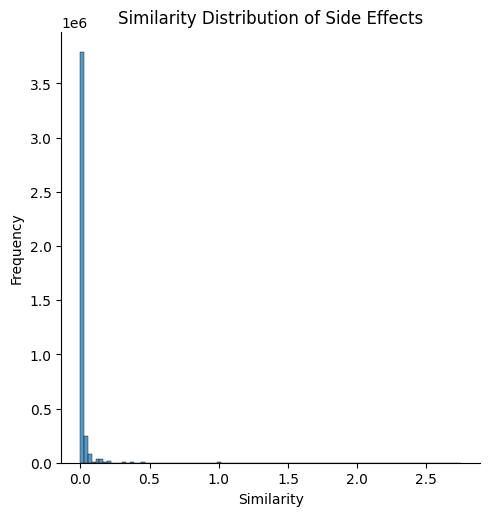

In [125]:
# df contains the similarity matrix, plot histogram for the similarity values
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(atc_sim_df.iloc[:, 1:].values.flatten(), kde=False, bins=100)

plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.title('Similarity Distribution of Side Effects')

plt.show()


In [126]:
# find se edges with similarity > 0.3
se_atc_edges = []
se_atc_edges_attr = []

se_atc_thresh = 0

for i in range(atc_sim_df.shape[0]):
    for j in range(i+1, atc_sim_df.shape[1]):
        sim_val = atc_sim_df.iloc[i, j]
        if sim_val > se_atc_thresh and (i!=j):
            se_atc_edges.append([atc_sim_df.iloc[i, 0], atc_sim_df.iloc[j-1, 0]])
            se_atc_edges_attr.append(sim_val)

In [127]:
se_atc_edges

[['pruritus genital', 'pruritus genital'],
 ['pruritus genital', 'skin tightness'],
 ['pruritus genital', 'petechiae'],
 ['pruritus genital', 'skin discomfort'],
 ['pruritus genital', 'swollen tongue'],
 ['pruritus genital', 'onychomycosis'],
 ['pruritus genital', 'palmar erythema'],
 ['pruritus genital', 'azoospermia'],
 ['pruritus genital', 'thrombocytopenic purpura'],
 ['pruritus genital', 'uterine disorder'],
 ['pruritus genital', 'testicular disorder'],
 ['pruritus genital', 'erythema multiforme'],
 ['pruritus genital', 'epididymitis'],
 ['pruritus genital', 'balanoposthitis'],
 ['pruritus genital', 'application site pruritus'],
 ['pruritus genital', 'pelvic discomfort'],
 ['pruritus genital', 'libido decreased'],
 ['pruritus genital', 'breast pain'],
 ['pruritus genital', 'cutaneous lupus erythematosus'],
 ['pruritus genital', 'abnormal withdrawal bleeding'],
 ['pruritus genital', 'skin haemorrhage'],
 ['pruritus genital', 'skin toxicity'],
 ['pruritus genital', 'pruritus general

In [128]:
se_uml_to_se_name_dict = {k: {x.lower() for x in v} for k, v in se_uml_to_se_name_dict.items()}

# reverse mapping from se name to se uml id
se_name_to_se_uml_dict = {se_name: se_uml_id for se_uml_id, se_name_set in se_uml_to_se_name_dict.items() for se_name in se_name_set}

In [129]:
se_atc_pairs = [(se_name_to_se_uml_dict.get(se_edge[0]), se_name_to_se_uml_dict.get(se_edge[1])) for se_edge in se_atc_edges if se_edge[0] in se_name_to_se_uml_dict and se_edge[1] in se_name_to_se_uml_dict]

In [130]:
len(se_atc_pairs), se_atc_pairs[:5]

(224135,
 [('C0033777', 'C0033777'),
  ('C0033777', 'C0241166'),
  ('C0033777', 'C0031256'),
  ('C0033777', 'C0863084'),
  ('C0033777', 'C0236068')])

In [131]:
# convert to edge_index
se_atc_pairs_id = edge_name_to_id(se_atc_pairs, MEDRAID_TO_ID_DICT)
se_atc_pairs_id_edge_index = torch.tensor(se_atc_pairs_id).T

print('edge_index', se_atc_pairs_id_edge_index.shape)
print('edge_index', se_atc_pairs_id_edge_index[:5])

edge_index torch.Size([2, 224135])
edge_index tensor([[ 730,  730,  730,  ...,  938,  850,  299],
        [ 730, 1369,  694,  ...,  938,  850,  299]])


In [132]:
len(se_unique_values)

2061

In [133]:
# function/lambda to give fingerprint 
# function to compute jaccard score
# store in D x D matrix

### Combine Edges

In [134]:
def map_as_ohe(list_of_list_dict, num_classes):
    final_list = []
    for list_dict_ in list_of_list_dict:
        ohe = np.zeros(num_classes)
        for dict_ in list_dict_:
            for k, v in dict_.items():
                ohe[k] = v
        final_list.append(ohe)
    return final_list

def combine_edges_with_multi_attributes(all_edges, all_edges_attr):
    final_edges_attr = defaultdict(list)
    for idx, (edges, edges_attr) in enumerate(zip(all_edges, all_edges_attr)):
        for edge, edge_attr in zip(edges.T.tolist(), edges_attr):
            final_edges_attr[tuple(edge)].append({idx: edge_attr})
    # filter final_edges_attr to remove edges with less than 2 attributes
    final_edges_attr = {k: v for k, v in final_edges_attr.items() if len(v) > 1}
    final_edges = list(final_edges_attr.keys())
    final_edges = torch.tensor(final_edges).T
    final_edges_attr = map_as_ohe(list(final_edges_attr.values()), len(all_edges_attr))
    return final_edges, final_edges_attr




In [135]:
all_drugs_edges = [drug_struct_pairs_id_edge_index, drug_word_pairs_id_edge_index, drug_target_pairs_id_edge_index, drug_se_encoded_pairs_id_edge_index]
all_drugs_edges_attr = [drug_struct_attr, drug_word_pairs_attr, drug_target_pairs_attr, drug_se_encoded_pairs_attr]

final_drug_edges, final_drug_edges_attr = combine_edges_with_multi_attributes(all_drugs_edges, all_drugs_edges_attr)

In [136]:
final_drug_edges.shape

torch.Size([2, 834532])

In [137]:
torch.tensor(np.array(final_drug_edges_attr)).shape

torch.Size([834532, 4])

In [138]:
all_se_edges = [se_name_emb_pairs_id_edge_index, se_drug_encoded_pairs_id_edge_index, se_atc_pairs_id_edge_index]
all_se_edges_attr = [se_name_emb_pairs_attr, se_drug_encoded_pairs_attr, se_atc_edges_attr]

final_se_edges, final_se_edges_attr = combine_edges_with_multi_attributes(all_se_edges, all_se_edges_attr)

In [139]:
final_se_edges.shape

torch.Size([2, 591940])

### Instantiate Pyg HeteroData

In [140]:
# Create a heterograph with 2 types of nodes: drug and side effect
data = HeteroData()

# Add nodes
data['drug'].node_id = torch.arange(drug_node_features.shape[0])
data['side_effect'].node_id = torch.arange(len(se_unique_values))

# Add node features
data['drug'].x = drug_node_features

# Add edges
data['drug', 'known', 'side_effect'].edge_index = edge_index

# add dummpy tensor of 1s for edge_attr for know drug-se edges
# data['drug', 'known', 'side_effect'].edge_attr = torch.ones(edge_index.shape[1])

# # # add drug-drug edges
# data['drug', 'struct', 'drug'].edge_index = drug_struct_pairs_id_edge_index
# data['drug', 'word', 'drug'].edge_index = drug_word_pairs_id_edge_index
# data['drug', 'target', 'drug'].edge_index = drug_target_pairs_id_edge_index
# data['drug', 'se_encoded', 'drug'].edge_index = drug_se_encoded_pairs_id_edge_index

# # add se-se edges
# data['side_effect', 'name', 'side_effect'].edge_index = se_name_emb_pairs_id_edge_index
# data['side_effect', 'dg_encoded', 'side_effect'].edge_index = se_drug_encoded_pairs_id_edge_index
# data['side_effect', 'atc', 'side_effect'].edge_index = se_atc_pairs_id_edge_index

# # add drug-drug edges attributes
# data['drug', 'struct', 'drug'].edge_attr = torch.tensor(drug_struct_attr)
# data['drug', 'word', 'drug'].edge_attr = torch.tensor(drug_word_pairs_attr)
# data['drug', 'target', 'drug'].edge_attr = torch.tensor(drug_target_pairs_attr)
# data['drug', 'se_encoded', 'drug'].edge_attr = torch.tensor(drug_se_encoded_pairs_attr)

# # add se-se edges attributes
# data['side_effect', 'name', 'side_effect'].edge_attr = torch.tensor(se_name_emb_pairs_attr)
# data['side_effect', 'dg_encoded', 'side_effect'].edge_attr = torch.tensor(se_drug_encoded_pairs_attr)
# data['side_effect', 'atc', 'side_effect'].edge_attr = torch.tensor(se_atc_edges_attr)

# add final drug-drug edges
data['drug', 'to', 'drug'].edge_index = final_drug_edges
data['drug', 'to', 'drug'].edge_attr = torch.tensor(np.array(final_drug_edges_attr))

# add final se-se edges
data['side_effect', 'to', 'side_effect'].edge_index = final_se_edges
data['side_effect', 'to', 'side_effect'].edge_attr = torch.tensor(np.array(final_se_edges_attr))

print(data)

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, known, side_effect)={ edge_index=[2, 129851] },
  (drug, to, drug)={
    edge_index=[2, 834532],
    edge_attr=[834532, 4]
  },
  (side_effect, to, side_effect)={
    edge_index=[2, 591940],
    edge_attr=[591940, 3]
  }
)


In [146]:
data

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, known, side_effect)={ edge_index=[2, 129851] },
  (drug, struct, drug)={
    edge_index=[2, 830115],
    edge_attr=[830115]
  },
  (drug, word, drug)={
    edge_index=[2, 823100],
    edge_attr=[823100]
  },
  (drug, target, drug)={
    edge_index=[2, 6663],
    edge_attr=[6663]
  },
  (drug, se_encoded, drug)={
    edge_index=[2, 842128],
    edge_attr=[842128]
  },
  (side_effect, name, side_effect)={
    edge_index=[2, 1452930],
    edge_attr=[1452930]
  },
  (side_effect, dg_encoded, side_effect)={
    edge_index=[2, 1218303],
    edge_attr=[1218303]
  },
  (side_effect, atc, side_effect)={
    edge_index=[2, 224135],
    edge_attr=[230806]
  }
)

### Load Pickle HeteroData

In [ ]:
# ### pyg save HeteroData object
# import os
# import pickle

# # make parent dir if not exists

# os.makedirs(os.path.dirname('../../prep_data/sider/sider_hetero_data_full.pkl'), exist_ok=True)

# with open('../../prep_data/sider/sider_hetero_data_full.pkl', 'wb') as f:
#     pickle.dump(data, f)


In [17]:

# load pickle
import pickle

with open('../../prep_data/sider/sider_hetero_data.pkl', 'rb') as fp:
    data = pickle.load(fp)


In [21]:
data['side_effect', 'to', 'side_effect'].edge_attr.shape 

torch.Size([591940, 3])

In [22]:
# keep only first 2 edge attr 
data['side_effect', 'to', 'side_effect'].edge_attr = data['side_effect', 'to', 'side_effect'].edge_attr[:, :2] 

### Hetero Data Sample Viz

In [21]:
# # Full Graph View
# import networkx as nx
# import matplotlib.pyplot as plt
# import torch
# from torch_geometric.data import HeteroData


# # Convert heterograph to NetworkX graph
# graph = nx.Graph()

# # Add nodes to the NetworkX graph with unique IDs for each node type
# drug_nodes = data['drug'].node_id.numpy()
# side_effect_nodes = data['side_effect'].node_id.numpy()

# drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_nodes]
# side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# # Add nodes to the NetworkX graph
# graph.add_nodes_from(drug_nodes_unique, node_type='drug')
# graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# # Add edges to the NetworkX graph
# drug_edges = data['drug', 'side_effect'].edge_index
# for i in range(drug_edges.shape[1]):
#     source = drug_edges[0, i].item()
#     target = drug_edges[1, i].item()
#     source_id = f"drug_{source}"
#     target_id = f"side_effect_{target}"
#     graph.add_edge(source_id, target_id)

# # Visualize the graph using NetworkX
# pos = nx.spring_layout(graph)  # Compute node positions

# # Separate nodes by type for different visualization colors
# drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
# side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# # Draw nodes with different colors based on type
# nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes')
# nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes')

# # Draw edges
# nx.draw_networkx_edges(graph, pos)

# # Draw node labels
# node_labels = {n: str(n) for n in graph.nodes()}
# nx.draw_networkx_labels(graph, pos, labels=node_labels)

# # Display the graph
# plt.axis('off')
# plt.legend()
# plt.show()

In [22]:
# # Plot random number of edges and all associated nodes
# import networkx as nx
# import matplotlib.pyplot as plt
# import torch
# import random
# from torch_geometric.data import HeteroData

# # Convert heterograph to NetworkX graph
# graph = nx.Graph()

# # Define the number of random edges you want to visualize
# num_random_edges = 10

# # Randomly select a subset of edges
# random_edge_indices = random.sample(range(data['drug', 'side_effect'].edge_index.shape[1]), num_random_edges)

# # Add nodes to the NetworkX graph with unique IDs for each node type
# drug_nodes = data['drug'].node_id.numpy()
# side_effect_nodes = data['side_effect'].node_id.numpy()

# # sample drug_nodes to have only nodes within random_edge_indices
# drug_nodes = np.unique(data['drug', 'side_effect'].edge_index[0, random_edge_indices].numpy())
# side_effect_nodes = np.unique(data['drug', 'side_effect'].edge_index[1, random_edge_indices].numpy())


# drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_nodes]
# side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# # Add nodes to the NetworkX graph
# graph.add_nodes_from(drug_nodes_unique, node_type='drug')
# graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# # Add edges to the NetworkX graph
# drug_edges = data['drug', 'side_effect'].edge_index[:, random_edge_indices]
# for i in range(drug_edges.shape[1]):
#     source = drug_edges[0, i].item()
#     target = drug_edges[1, i].item()
#     source_id = f"drug_{source}"
#     target_id = f"side_effect_{target}"
#     graph.add_edge(source_id, target_id)

# # Visualize the graph using NetworkX
# pos = nx.spring_layout(graph)  # Compute node positions

# # Separate nodes by type for different visualization colors
# drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
# side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# # Draw nodes with different colors based on type
# nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes')
# nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes')

# # Draw edges
# nx.draw_networkx_edges(graph, pos)

# # Draw node labels
# node_labels = {n: str(n) for n in graph.nodes()}
# nx.draw_networkx_labels(graph, pos, labels=node_labels)

# # Display the graph
# plt.axis('off')
# plt.legend()
# plt.show()


In [23]:
def add_edge_type(graph, edges, etype):
    if etype=='known':
        source_id_ = "drug_{}"
        target_id_ = "side_effect_{}"
    elif etype in [ 'struct', 'word', 'target', 'se_encoded']:
        source_id_ = "drug_{}"
        target_id_ = "drug_{}"
    elif etype in ['name', 'dg_encoded', 'atc']:
        source_id_ = "side_effect_{}"
        target_id_ = "side_effect_{}"
    
    for i in range(edges.shape[1]):
        source = edges[0, i].item()
        target = edges[1, i].item()
        source_id = source_id_.format(source)
        target_id = target_id_.format(target)
        # edge_data = {'edge_type': etype}
        graph.add_edge(source_id, target_id, edge_type=etype)
    return graph

In [24]:
# list(set([val for start_end in [(edge_detail[0], edge_detail[2]) for edge_detail in all_edge_type] for val in start_end]))

In [25]:
# plot for selected list of drug_id and all associated side effects
import networkx as nx
import matplotlib.pyplot as plt
import torch
import random
from torch_geometric.data import HeteroData, Data

from random import sample
import matplotlib.colors as mcolors

all_edge_type = [
    ('drug', 'known', 'side_effect'),
    ('drug', 'struct', 'drug'),
    ('drug', 'word', 'drug'),
    ('drug', 'target', 'drug'),
    ('drug', 'se_encoded', 'drug'),
    ('side_effect', 'name', 'side_effect'),
    ('side_effect', 'dg_encoded', 'side_effect'),
    ('side_effect', 'atc', 'side_effect')
]

def visualize_hetero(data, all_edge_type, drug_id_list=[0, 2, 3]):

    edge_type_node_type = list(set([val for start_end in [(edge_detail[0], edge_detail[2]) for edge_detail in all_edge_type] for val in start_end]))
    bipartite_view = True if len(edge_type_node_type)>1 else False
    
    # associated possible unique side effects using edge_index when drug_id is in drug_id_list
    side_effect_nodes = np.unique(data['drug', 'known', 'side_effect'].edge_index[1, np.isin(data['drug', 'known', 'side_effect'].edge_index[0], drug_id_list)].numpy())
    
    drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_id_list]
    side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

    
    # Convert heterograph to NetworkX graph
    graph = nx.MultiGraph()  #nx.Graph()

    # Add nodes to the NetworkX graph
    graph.add_nodes_from(drug_nodes_unique, node_type='drug')
    graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')
    
    node_filter_list = {'drug': drug_id_list, 'side_effect': side_effect_nodes}

    for edge_detail in all_edge_type:
        edges = data[edge_detail].edge_index[:, np.isin(data[edge_detail].edge_index[0], node_filter_list.get(edge_detail[0])) & np.isin(data[edge_detail].edge_index[1], node_filter_list.get(edge_detail[2]))]        
        graph = add_edge_type(graph, edges, edge_detail[1])

    # print(len(graph.edges(data=True)) == drug_edges.shape[1] + drug_struct_pairs_id_edge_index.shape[1] + drug_word_pairs_id_edge_index.shape[1] + drug_target_pairs_id_edge_index.shape[1] + drug_se_encoded_pairs_id_edge_index.shape[1] + se_name_emb_pairs_id_edge_index.shape[1] + se_drug_encoded_pairs_id_edge_index.shape[1] + se_atc_pairs_id_edge_index.shape[1])
    print(len(graph.edges(data=True)))
    # Separate nodes by type for different visualization colors
    drug_nodes = [n for n, d in graph.nodes(data=True) if d.get('node_type', '') == 'drug']
    side_effect_nodes = [n for n, d in graph.nodes(data=True) if d.get('node_type', '') == 'side_effect']

    # Visualize the graph using NetworkX
    if bipartite_view:
        pos = nx.bipartite_layout(graph, drug_nodes_unique, align='vertical', scale=5)  # Compute node positions
        # Draw nodes with different colors based on type
        nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes', cmap=plt.cm.Blues)
        nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes', cmap=plt.cm.Reds)
    else:
        pos = nx.spring_layout(graph, seed=1)  # Compute node positions 
        if edge_type_node_type[0] == 'drug':
            # Draw nodes with different colors based on type
            nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes', cmap=plt.cm.Blues)
        else:
            nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes', cmap=plt.cm.Reds)

    
    # Draw edges with different colors based on type
    edge_types = set([d['edge_type'] for u, v, d in graph.edges(data=True)])
    edge_colors = dict(zip(edge_types, sample(list(mcolors.CSS4_COLORS), len(edge_types))))

    for etype in edge_types:
        edges = [(u, v) for u, v, d in graph.edges(data=True) if d['edge_type'] == etype]
        nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color=edge_colors[etype], width=1.0, alpha=0.8)

    # Draw node labels
    node_labels = {n: str(n) for n in graph.nodes()}

    nx.draw_networkx_labels(graph, pos, labels=node_labels)

    # Display the graph
    plt.axis('off')
    # increase figure size
    plt.gcf().set_size_inches(10, 10)
    # position legend to the right of the graph
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title('Drug-Side Effect Network')
    plt.show()

In [26]:
all_edge_type = [
    ('drug', 'known', 'side_effect'),
    ('drug', 'struct', 'drug'),
    ('drug', 'word', 'drug'),
    ('drug', 'target', 'drug'),
    ('drug', 'se_encoded', 'drug'),
    ('side_effect', 'name', 'side_effect'),
    ('side_effect', 'dg_encoded', 'side_effect'),
    ('side_effect', 'atc', 'side_effect')
]

In [25]:
visualize_hetero(data, all_edge_type[:3] + [all_edge_type[-2]], drug_id_list=[0, 2, 3])


AttributeError: 'EdgeStorage' object has no attribute 'edge_index'

In [26]:
# # plot for selected list of drug_id and all associated side effects
# import networkx as nx
# import matplotlib.pyplot as plt
# import torch
# import random
# from torch_geometric.data import HeteroData, Data

# # list of drug_id to visualize all its associated side effects
# drug_id_list = [0, 2, 3]

# # associated possible unique side effects using edge_index when drug_id is in drug_id_list
# side_effect_nodes = np.unique(data['drug', 'known', 'side_effect'].edge_index[1, np.isin(data['drug', 'known', 'side_effect'].edge_index[0], drug_id_list)].numpy())

# # filter out edges that are between drug_id_list and side_effect_nodes
# drug_edges = data['drug', 'known', 'side_effect'].edge_index[:, np.isin(data['drug', 'known', 'side_effect'].edge_index[0], drug_id_list) & np.isin(data['drug', 'known', 'side_effect'].edge_index[1], side_effect_nodes)]

# # filter out additional drug edges
# drug_struct_pairs_id_edge_index = data['drug', 'struct', 'drug'].edge_index[:, np.isin(data['drug', 'struct', 'drug'].edge_index[0], drug_id_list) & np.isin(data['drug', 'struct', 'drug'].edge_index[1], drug_id_list)]
# drug_word_pairs_id_edge_index = data['drug', 'word', 'drug'].edge_index[:, np.isin(data['drug', 'word', 'drug'].edge_index[0], drug_id_list) & np.isin(data['drug', 'word', 'drug'].edge_index[1], drug_id_list)]
# drug_target_pairs_id_edge_index = data['drug', 'target', 'drug'].edge_index[:, np.isin(data['drug', 'target', 'drug'].edge_index[0], drug_id_list) & np.isin(data['drug', 'target', 'drug'].edge_index[1], drug_id_list)]
# drug_se_encoded_pairs_id_edge_index = data['drug', 'se_encoded', 'drug'].edge_index[:, np.isin(data['drug', 'se_encoded', 'drug'].edge_index[0], drug_id_list) & np.isin(data['drug', 'se_encoded', 'drug'].edge_index[1], drug_id_list)]

# # filter out additional se edges
# se_name_emb_pairs_id_edge_index = data['side_effect', 'name', 'side_effect'].edge_index[:, np.isin(data['side_effect', 'name', 'side_effect'].edge_index[0], side_effect_nodes) & np.isin(data['side_effect', 'name', 'side_effect'].edge_index[1], side_effect_nodes)]
# se_drug_encoded_pairs_id_edge_index = data['side_effect', 'dg_encoded', 'side_effect'].edge_index[:, np.isin(data['side_effect', 'dg_encoded', 'side_effect'].edge_index[0], side_effect_nodes) & np.isin(data['side_effect', 'dg_encoded', 'side_effect'].edge_index[1], side_effect_nodes)]
# se_atc_pairs_id_edge_index = data['side_effect', 'atc', 'side_effect'].edge_index[:, np.isin(data['side_effect', 'atc', 'side_effect'].edge_index[0], side_effect_nodes) & np.isin(data['side_effect', 'atc', 'side_effect'].edge_index[1], side_effect_nodes)]


# drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_id_list]
# side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# from random import sample
# import matplotlib.colors as mcolors

# # Convert heterograph to NetworkX graph
# graph = nx.MultiGraph()  #nx.Graph()

# # Add nodes to the NetworkX graph
# graph.add_nodes_from(drug_nodes_unique, node_type='drug')
# graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# edge_type = ['known', 'struct', 'word', 'target', 'se_encoded', 'name', 'dg_encoded', 'atc'] # se_name_emb_pairs_id_edge_index
# # Add edges to the NetworkX graph
# for edges, etype in zip([drug_edges, drug_struct_pairs_id_edge_index, drug_word_pairs_id_edge_index, drug_target_pairs_id_edge_index, drug_se_encoded_pairs_id_edge_index, se_drug_encoded_pairs_id_edge_index, se_atc_pairs_id_edge_index], edge_type): #
#     graph = add_edge_type(graph, edges, etype)

# print(len(graph.edges(data=True)) == drug_edges.shape[1] + drug_struct_pairs_id_edge_index.shape[1] + drug_word_pairs_id_edge_index.shape[1] + drug_target_pairs_id_edge_index.shape[1] + drug_se_encoded_pairs_id_edge_index.shape[1] + se_name_emb_pairs_id_edge_index.shape[1] + se_drug_encoded_pairs_id_edge_index.shape[1] + se_atc_pairs_id_edge_index.shape[1])
    
# # Visualize the graph using NetworkX
# # pos = nx.spring_layout(graph, seed=1)  # Compute node positions 
# pos = nx.bipartite_layout(graph, drug_nodes_unique, align='vertical', scale=5)  # Compute node positions


# # Separate nodes by type for different visualization colors
# drug_nodes = [n for n, d in graph.nodes(data=True) if d.get('node_type', '') == 'drug']
# side_effect_nodes = [n for n, d in graph.nodes(data=True) if d.get('node_type', '') == 'side_effect']

# # Draw nodes with different colors based on type
# nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes', cmap=plt.cm.Blues)
# nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes', cmap=plt.cm.Reds)

# # Draw edges with different colors based on type
# edge_types = set([d['edge_type'] for u, v, d in graph.edges(data=True)])
# edge_colors = dict(zip(edge_types, sample(list(mcolors.CSS4_COLORS), len(edge_types))))

# for etype in edge_types:
#     edges = [(u, v) for u, v, d in graph.edges(data=True) if d['edge_type'] == etype]
#     nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color=edge_colors[etype], width=1.0, alpha=0.8)

# # Draw node labels
# node_labels = {n: str(n) for n in graph.nodes()}

# nx.draw_networkx_labels(graph, pos, labels=node_labels)

# # Display the graph
# plt.axis('off')
# # increase figure size
# plt.gcf().set_size_inches(10, 10)
# # position legend to the right of the graph
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.title('Drug-Side Effect Network')
# plt.show()

In [27]:
# # plot for selected list of drug_id and all associated side effects
# import networkx as nx
# import matplotlib.pyplot as plt
# import torch
# import random
# from torch_geometric.data import HeteroData, Data

# # Convert heterograph to NetworkX graph
# graph = nx.Graph()

# # list of drug_id to visualize all its associated side effects
# drug_id_list = [0, 2, 3]

# # associated possible unique side effects using edge_index when drug_id is in drug_id_list
# side_effect_nodes = np.unique(data['drug', 'known', 'side_effect'].edge_index[1, np.isin(data['drug', 'known', 'side_effect'].edge_index[0], drug_id_list)].numpy())

# # filter out edges that are between drug_id_list and side_effect_nodes
# drug_edges = data['drug', 'known', 'side_effect'].edge_index[:, np.isin(data['drug', 'known', 'side_effect'].edge_index[0], drug_id_list) & np.isin(data['drug', 'known', 'side_effect'].edge_index[1], side_effect_nodes)]

# # filter out additional drug edges
# drug_struct_pairs_id_edge_index = data['drug', 'struct', 'drug'].edge_index[:, np.isin(data['drug', 'struct', 'drug'].edge_index[0], drug_id_list) & np.isin(data['drug', 'struct', 'drug'].edge_index[1], drug_id_list)]
# drug_word_pairs_id_edge_index = data['drug', 'word', 'drug'].edge_index[:, np.isin(data['drug', 'word', 'drug'].edge_index[0], drug_id_list) & np.isin(data['drug', 'word', 'drug'].edge_index[1], drug_id_list)]
# drug_target_pairs_id_edge_index = data['drug', 'target', 'drug'].edge_index[:, np.isin(data['drug', 'target', 'drug'].edge_index[0], drug_id_list) & np.isin(data['drug', 'target', 'drug'].edge_index[1], drug_id_list)]
# drug_se_encoded_pairs_id_edge_index = data['drug', 'se_encoded', 'drug'].edge_index[:, np.isin(data['drug', 'se_encoded', 'drug'].edge_index[0], drug_id_list) & np.isin(data['drug', 'se_encoded', 'drug'].edge_index[1], drug_id_list)]

# # filter out additional se edges
# se_name_emb_pairs_id_edge_index = data['side_effect', 'name', 'side_effect'].edge_index[:, np.isin(data['side_effect', 'name', 'side_effect'].edge_index[0], side_effect_nodes) & np.isin(data['side_effect', 'name', 'side_effect'].edge_index[1], side_effect_nodes)]
# se_drug_encoded_pairs_id_edge_index = data['side_effect', 'dg_encoded', 'side_effect'].edge_index[:, np.isin(data['side_effect', 'dg_encoded', 'side_effect'].edge_index[0], side_effect_nodes) & np.isin(data['side_effect', 'dg_encoded', 'side_effect'].edge_index[1], side_effect_nodes)]
# se_atc_pairs_id_edge_index = data['side_effect', 'atc', 'side_effect'].edge_index[:, np.isin(data['side_effect', 'atc', 'side_effect'].edge_index[0], side_effect_nodes) & np.isin(data['side_effect', 'atc', 'side_effect'].edge_index[1], side_effect_nodes)]



# drug_nodes_unique = [f"drug_{node_id}" for node_id in drug_id_list]
# side_effect_nodes_unique = [f"side_effect_{node_id}" for node_id in side_effect_nodes]

# # Add nodes to the NetworkX graph
# graph.add_nodes_from(drug_nodes_unique, node_type='drug')
# graph.add_nodes_from(side_effect_nodes_unique, node_type='side_effect')

# # Add edges to the NetworkX graph
# for i in range(drug_edges.shape[1]):
#     source = drug_edges[0, i].item()
#     target = drug_edges[1, i].item()
#     source_id = f"drug_{source}"
#     target_id = f"side_effect_{target}"
#     graph.add_edge(source_id, target_id)

# # Visualize the graph using NetworkX
# # pos = nx.spring_layout(graph, seed=1)  # Compute node positions
# pos = nx.bipartite_layout(graph, drug_nodes_unique, align='vertical', scale=5)  # Compute node positions
# # Separate nodes by type for different visualization colors
# drug_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'drug']
# side_effect_nodes = [n for n, d in graph.nodes(data=True) if d['node_type'] == 'side_effect']

# # Draw nodes with different colors based on type
# nx.draw_networkx_nodes(graph, pos, nodelist=drug_nodes, node_color='blue', label='Drug Nodes', cmap=plt.cm.Blues)
# nx.draw_networkx_nodes(graph, pos, nodelist=side_effect_nodes, node_color='red', label='Side Effect Nodes', cmap=plt.cm.Reds)

# # Draw edges with different colors based on type

# nx.draw_networkx_edges(graph, pos, edge_color='black', width=1.0, alpha=0.5)

# # Draw edges
# # nx.draw_networkx_edges(graph, pos)

# # Draw node labels
# node_labels = {n: str(n) for n in graph.nodes()}
# nx.draw_networkx_labels(graph, pos, labels=node_labels)

# # Display the graph
# plt.axis('off')
# # increase figure size
# plt.gcf().set_size_inches(10, 10)
# # position legend to the right of the graph
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.title('Drug-Side Effect Network')
# plt.show()


In [28]:
# graph.nodes()
# # link a map to most common drug_name and side_effect_name

### Hetero Link Prediction task

In [18]:
import torch_geometric.transforms as T
# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

In [19]:
# T.ToUndirected() 
# transform assumes that edges in a heterogeneous graph should be considered as directed by default. 
data


HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, known, side_effect)={ edge_index=[2, 129851] },
  (drug, to, drug)={
    edge_index=[2, 1669064],
    edge_attr=[1669064, 4]
  },
  (side_effect, to, side_effect)={
    edge_index=[2, 1179202],
    edge_attr=[1179202, 3]
  },
  (side_effect, rev_known, drug)={ edge_index=[2, 129851] }
)

In [25]:
# data['drug'].mol_graph_edge_index = edge_index_
# data['drug'].mol_graph_n_features = n_features_

### Define Edge level Train Split

In [20]:
# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly.
# We can leverage the `RandomLinkSplit()` transform for this from PyG:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=1.0,
    add_negative_train_samples=False,
    edge_types=('drug', 'known', 'side_effect'),
    rev_edge_types=('side_effect', 'rev_known', 'drug'), 
)


train_data, val_data, test_data = transform(data)
print("Training data:")
print("==============")
print(train_data)
print()
print("Validation data:")
print("================")
print(val_data)

Training data:
HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, known, side_effect)={
    edge_index=[2, 72717],
    edge_label=[31164],
    edge_label_index=[2, 31164]
  },
  (drug, to, drug)={
    edge_index=[2, 1669064],
    edge_attr=[1669064, 4]
  },
  (side_effect, to, side_effect)={
    edge_index=[2, 1179202],
    edge_attr=[1179202, 3]
  },
  (side_effect, rev_known, drug)={ edge_index=[2, 72717] }
)

Validation data:
HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, known, side_effect)={
    edge_index=[2, 103881],
    edge_label=[25970],
    edge_label_index=[2, 25970]
  },
  (drug, to, drug)={
    edge_index=[2, 1669064],
    edge_attr=[1669064, 4]
  },
  (side_effect, to, side_effect)={
    edge_index=[2, 1179202],
    edge_attr=[1179202, 3]
  },
  (side_effect, rev_known, drug)={ edge_index=[2, 103881] }
)


### Define Mini-batch Loader

In [27]:
# !pip install pyg-lib -f https://data.pyg.org/whl/torch-1.12.1+cu117.html

In [21]:
num_neighbors=[8, 5]
batch_size=64

In [22]:
# In the first hop, we sample at most 20 neighbors.
# In the second hop, we sample at most 10 neighbors.
# In addition, during training, we want to sample negative edges on-the-fly with
# a ratio of 2:1.
# We can make use of the `loader.LinkNeighborLoader` from PyG:
from torch_geometric.loader.link_neighbor_loader import LinkNeighborLoader

# Define seed edges:
edge_label_index = train_data["drug", "known", "side_effect"].edge_label_index
edge_label = train_data["drug", "known", "side_effect"].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=num_neighbors,
    neg_sampling_ratio=1.0,
    edge_label_index=(("drug", "known", "side_effect"), edge_label_index),
    edge_label=edge_label,
    batch_size=batch_size,
    shuffle=True,
    disjoint=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
HeteroData(
  drug={
    node_id=[19853],
    x=[19853, 7],
    n_id=[19853],
    batch=[19853]
  },
  side_effect={
    node_id=[20064],
    n_id=[20064],
    batch=[20064]
  },
  (drug, known, side_effect)={
    edge_index=[2, 10182],
    edge_label=[128],
    edge_label_index=[2, 128],
    e_id=[10182],
    input_id=[64]
  },
  (drug, to, drug)={
    edge_index=[2, 10469],
    edge_attr=[10469, 4],
    e_id=[10469]
  },
  (side_effect, to, side_effect)={
    edge_index=[2, 10650],
    edge_attr=[10650, 3],
    e_id=[10650]
  },
  (side_effect, rev_known, drug)={
    edge_index=[2, 10332],
    e_id=[10332]
  }
)


In [23]:
# Define the validation seed edges:
edge_label_index = val_data["drug", "known", "side_effect"].edge_label_index
edge_label = val_data["drug", "known", "side_effect"].edge_label

val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=num_neighbors,
    edge_label_index=(("drug", "known", "side_effect"), edge_label_index),
    edge_label=edge_label,
    batch_size=batch_size,
    shuffle=False,
    disjoint=True,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)


Sampled mini-batch:
HeteroData(
  drug={
    node_id=[10652],
    x=[10652, 7],
    n_id=[10652],
    batch=[10652]
  },
  side_effect={
    node_id=[10619],
    n_id=[10619],
    batch=[10619]
  },
  (drug, known, side_effect)={
    edge_index=[2, 5478],
    edge_label=[64],
    edge_label_index=[2, 64],
    e_id=[5478],
    input_id=[64]
  },
  (drug, to, drug)={
    edge_index=[2, 5602],
    edge_attr=[5602, 4],
    e_id=[5602]
  },
  (side_effect, to, side_effect)={
    edge_index=[2, 5519],
    edge_attr=[5519, 3],
    e_id=[5519]
  },
  (side_effect, rev_known, drug)={
    edge_index=[2, 5565],
    e_id=[5565]
  }
)


In [24]:
# instantiate test_loader
edge_label_index = test_data["drug", "known", "side_effect"].edge_label_index
edge_label = test_data["drug", "known", "side_effect"].edge_label

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=num_neighbors,
    edge_label_index=(("drug", "known", "side_effect"), edge_label_index),
    edge_label=edge_label,
    batch_size=batch_size,
    shuffle=False,
    disjoint=True,
)

sampled_data = next(iter(test_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

Sampled mini-batch:
HeteroData(
  drug={
    node_id=[10671],
    x=[10671, 7],
    n_id=[10671],
    batch=[10671]
  },
  side_effect={
    node_id=[10611],
    n_id=[10611],
    batch=[10611]
  },
  (drug, known, side_effect)={
    edge_index=[2, 5547],
    edge_label=[64],
    edge_label_index=[2, 64],
    e_id=[5547],
    input_id=[64]
  },
  (drug, to, drug)={
    edge_index=[2, 5582],
    edge_attr=[5582, 4],
    e_id=[5582]
  },
  (side_effect, to, side_effect)={
    edge_index=[2, 5534],
    edge_attr=[5534, 3],
    e_id=[5534]
  },
  (side_effect, rev_known, drug)={
    edge_index=[2, 5550],
    e_id=[5550]
  }
)


In [32]:
sampled_data.edge_index_dict

{('drug',
  'known',
  'side_effect'): tensor([[  64,   65,   66,  ..., 5836, 5846, 5847],
         [   0,    0,    0,  ..., 1079, 1079, 1079]]),
 ('drug',
  'to',
  'drug'): tensor([[  566,   567,   568,  ...,  1073, 10669, 10670],
         [    0,     0,     0,  ...,  1077,  1077,  1077]]),
 ('side_effect',
  'to',
  'side_effect'): tensor([[  64,   65,   66,  ..., 6034, 6035, 6036],
         [   0,    0,    0,  ..., 1079, 1079, 1079]]),
 ('side_effect',
  'rev_known',
  'drug'): tensor([[  568,   569,   570,  ..., 10609, 10593, 10610],
         [    0,     0,     0,  ...,  1077,  1077,  1077]])}

### Creating a Hetero Link-level GNN

#### Vanilla GraphSage Model

In [25]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F
from torch import Tensor


class SageGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        
    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        x = F.elu(self.conv1(x, edge_index, edge_attr)+self.lin1(x))
        x = self.conv2(x, edge_index, edge_attr) + self.lin2(x)
        return x

#### GAT Model

In [26]:
# GATConv
from torch_geometric.nn import GATConv, to_hetero
import torch.nn.functional as F
from torch import Tensor

In [27]:


class GatGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GATConv(hidden_channels, hidden_channels, add_self_loops=False)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels, add_self_loops=False)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        
    def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
        x = F.elu(self.conv1(x, edge_index, edge_attr)+self.lin1(x))
        x = self.conv2(x, edge_index, edge_attr) + self.lin2(x)
        return x

#### Multi-Head Models

In [28]:
# # GATConv
# from torch_geometric.nn import GATConv, to_hetero, LayerNorm
# from torch.nn.modules.container import ModuleList
# import torch.nn.functional as F
# from torch import Tensor

# class MHGNN(torch.nn.Module):
#     def __init__(self, input_features_dim, heads_out_feat_params, blocks_nh_params):
#         super().__init__()
#         self.blocks = []
#         self.skip_linear = []
#         self.net_norms = ModuleList()
#         for i, (head_out_feats, n_heads) in enumerate(zip(heads_out_feat_params, blocks_nh_params)):
#             block = GATConv(input_features_dim, head_out_feats, heads=n_heads, add_self_loops=True)
#             skip_linear = torch.nn.Linear(input_features_dim, head_out_feats)
#             self.add_module(f"block{i}", block)
#             self.add_module(f"skip_linear{i}", skip_linear)
#             self.blocks.append(block)
#             self.net_norms.append(LayerNorm(head_out_feats * n_heads))
#             input_features_dim = head_out_feats * n_heads
        
#     def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
#         # x = F.elu(self.conv1(x, edge_index, edge_attr)+self.lin1(x))
#         # x = self.conv2(x, edge_index, edge_attr) + self.lin2(x)
#         # return x
#         # using multi-head GAT
#         skip = x
#         for i, (block, skip_linear) in enumerate(zip(self.blocks, self.skip_linear)):
#             x = block(x, edge_index, edge_attr)
#             skip = skip_linear(skip)
#             x += skip
#             x = F.elu(self.net_norms[i](x))
#         return x


        

In [29]:
from torch import nn

class MHGNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, heads):
        super().__init__()
        self.GATLayers = nn.ModuleList()
        # self.norms = nn.ModuleList() 
        self.skips = nn.ModuleList()
        for i, (out_dim, head) in enumerate(zip(hidden_dims, heads)):
            self.GATLayers.append(GATConv(input_dim, out_dim, heads=head, add_self_loops=False, name=f'GATLayer{i}'))
            # self.norms.append(nn.LayerNorm(out_dim * head))
            self.skips.append(nn.Linear(input_dim, out_dim * head))
            input_dim = out_dim * head      
        
        # # initialize skips with xavier init
        # for skip in self.skips:
        #     nn.init.xavier_uniform_(skip.weight)
        #     nn.init.zeros_(skip.bias)

    def forward(self, x, edge_index, edge_attr):
        for idx, (layer, skip) in enumerate(zip(self.GATLayers, self.skips)): # norm, self.norms
            skip_x = skip(x)
            x = layer(x, edge_index, edge_attr)
            # make skip_x have the same shape as x
            # if layer.heads > 1:
            #     # skip_x = skip_x.repeat_interleave(layer.heads, dim=1)
            #     # view skip_x as x batch, heads, features
            #     skip_x = skip_x.view(x.shape[0], layer.heads, -1)
            x += skip_x
            if idx < len(self.GATLayers) - 1:
                x = F.elu(x) # norm(x)
        return x

In [30]:
# model = MHGNN(input_dim=128, hidden_dims=[128, 128], heads=[1, 1])
# model

In [31]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.nn import GATConv, LayerNorm, to_hetero

# class MHGNNLayer(nn.Module):
#     def __init__(self, input_features_dim, head_out_feats, n_heads):
#         super(MHGNNLayer, self).__init__()
#         self.gat = GATConv(input_features_dim, head_out_feats, heads=n_heads, add_self_loops=False)
#         # self.skip_linear = nn.Linear(input_features_dim, head_out_feats)
#         self.norm = LayerNorm(head_out_feats * n_heads)

#     def forward(self, x, edge_index, edge_attr):
#         # skip = self.skip_linear(x)
#         x = self.gat(x, edge_index, edge_attr)
#         # x += skip
#         x = F.elu(self.norm(x))
#         return x
    
#     def reset_parameters(self):
#         self.gat.reset_parameters()
#         # self.skip_linear.reset_parameters()
#         self.norm.reset_parameters()

# class MHGNN(nn.Module):
#     def __init__(self, input_features_dim, heads_out_feat_params, blocks_nh_params):
#         super(MHGNN, self).__init__()
#         self.blocks = nn.ModuleList()
#         for head_out_feats, n_heads in zip(heads_out_feat_params, blocks_nh_params):
#             self.blocks.append(MHGNNLayer(input_features_dim, head_out_feats, n_heads))
#             input_features_dim = head_out_feats * n_heads

#     def forward(self, x, edge_index, edge_attr):
#         for block in self.blocks:
#             x = block(x, edge_index, edge_attr)
#         return x
    
#     def reset_parameters(self):
#         for block in self.blocks:
#             block.reset_parameters()
    

In [32]:
# # GNN with edge attribute and GATConv - will have to use hetero netwrok with GATv2Conv and GATConv depending on edge_attr
# from torch_geometric.nn import GATConv, to_hetero, GATv2Conv
# import torch.nn.functional as F
# from torch import Tensor

# class GNN(torch.nn.Module):
#     def __init__(self, hidden_channels):
#         super().__init__()
#         self.conv1 = GATv2Conv(hidden_channels, hidden_channels, add_self_loops=False)
#         self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
#         self.conv2 = GATv2Conv(hidden_channels, hidden_channels, add_self_loops=False)
#         self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        
#     def forward(self, x: Tensor, edge_index: Tensor, edge_attr: Tensor) -> Tensor:
#         x = F.elu(self.conv1(x, edge_index, edge_attr)+self.lin1(x))
#         x = self.conv2(x, edge_index, edge_attr) + self.lin2(x)
#         return x

### Classification Head

#### Single Head

In [33]:
import torch
import torch.nn as nn

class SingleFlattenHead(nn.Module):
    def __init__(self, hidden_channel):
        super(SingleFlattenHead, self).__init__()
        self.classification_head = nn.Linear(2*hidden_channel, 1)
        # self.simple_attention = nn.Linear(2*hidden_channel, 2*hidden_channel)
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x_user, x_movie, edge_label_index):
        # Get multi-head node embeddings for user and movie
        edge_feat_user = x_user[edge_label_index[0]]  # Shape: (batch_size, num_heads, num_features)
        edge_feat_movie = x_movie[edge_label_index[1]]  # Shape: (batch_size, num_heads, num_features)

        # Flatten the multi-head representations
        edge_feat_user = edge_feat_user.view(edge_feat_user.size(0), -1)  # Shape: (batch_size, num_heads * num_features)
        edge_feat_movie = edge_feat_movie.view(edge_feat_movie.size(0), -1)  # Shape: (batch_size, num_heads * num_features)
        # print dim before and after concat
        # print(edge_feat_user.shape, edge_feat_movie.shape)
        drug_side_flatten_emb = torch.cat([edge_feat_user, edge_feat_movie], dim=-1)
        # print(drug_side_flatten_emb.shape)
        # drug_side_flatten_emb_att = self.simple_attention(drug_side_flatten_emb)
        # drug_side_flatten_emb_att = self.softmax(drug_side_flatten_emb_att)

        # adjust emb based on attention
        # drug_side_flatten_emb = drug_side_flatten_emb * drug_side_flatten_emb_att
        # Get the final edge prediction using self.classification_head

        # using self.classification_head
        edge_pred = self.classification_head(drug_side_flatten_emb)  # Shape: (batch_size, 1
        # flatten pred
        edge_pred = edge_pred.view(-1)

        return edge_pred


#### Vanilla Classification Head

In [34]:
from torch import Tensor
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class VanillaClassifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

#### Multi-Head Classifier Head

In [35]:
# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions:
class ClassifierMH(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        # flatten the node embeddings
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]
        # if shape of edge_feat_user is (batch_size, num_nodes, num_features), then flatten it to (batch_size, num_features) with sum
        if len(edge_feat_user.shape) > 2:
            edge_feat_user = edge_feat_user.sum(dim=1)
            edge_feat_movie = edge_feat_movie.sum(dim=1)
        
        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)

#### ClassifierMHFlatten

In [36]:
import torch
import torch.nn as nn

class ClassifierMHFlatten(nn.Module):
    def __init__(self):
        super(ClassifierMHFlatten, self).__init__()

    def forward(self, x_user, x_movie, edge_label_index):
        # Get multi-head node embeddings for user and movie
        edge_feat_user = x_user[edge_label_index[0]]  # Shape: (batch_size, num_heads, num_features)
        edge_feat_movie = x_movie[edge_label_index[1]]  # Shape: (batch_size, num_heads, num_features)

        # Flatten the multi-head representations
        edge_feat_user = edge_feat_user.view(edge_feat_user.size(0), -1)  # Shape: (batch_size, num_heads * num_features)
        edge_feat_movie = edge_feat_movie.view(edge_feat_movie.size(0), -1)  # Shape: (batch_size, num_heads * num_features)

        # Element-wise product (Hadamard product)
        edge_feat = edge_feat_user * edge_feat_movie  # Shape: (batch_size, num_heads * num_features)

        # Sum along the features dimension
        edge_feat = edge_feat.sum(dim=1)  # Shape: (batch_size,)

        return edge_feat


#### Multi-Head Classifier Head with Attention

In [37]:
class ClassifierMHAttention(torch.nn.Module):
    '''# ClassifierMHAttention - From multihead GATConv output to single edge embedding
        using attention mechanism
    '''
    def __init__(self, hidden_channels, heads):
        super().__init__()
        self.heads = heads
        self.attention_drug = nn.MultiheadAttention(hidden_channels, heads, dropout=0.1)
        self.attention_se = nn.MultiheadAttention(hidden_channels, heads, dropout=0.1)
        self.linear = nn.Linear(hidden_channels, hidden_channels)
        self.norm = nn.LayerNorm(hidden_channels)

    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # multi-head node embeddigns for user and movie
        user_feat = x_user[edge_label_index[0]]  # user_feat shape is (num_nodes, num_heads, num_features)
        movie_feat = x_movie[edge_label_index[1]] # movie_feat shape is (num_nodes, num_heads, num_features)
        
        # use attention on multi-head node embeddings
        user_feat_attn, _ = self.attention_drug(user_feat, user_feat, user_feat) # 
        movie_feat_attn, _ = self.attention_se(movie_feat, movie_feat, movie_feat)

        # use the attention to get single head representation 
        # do dot product and get the classifcation output

        
    




    




### Edge Level Model

#### Vanilla Model

In [38]:
# Homegenous Model for Edge Prediction
class VanillaModel(torch.nn.Module):
    def __init__(self, data, hidden_channels, gnn_model, classifier_model, use_node_features=False):
        super().__init__()
        # Instantiate node embeddings:
        self.drug_emb = torch.nn.Embedding(data["drug"].num_nodes, hidden_channels)
        self.seff_emb = torch.nn.Embedding(data["side_effect"].num_nodes, hidden_channels)
        # Instantiate GNNs:
        # self.gnn = GNN(hidden_channels)
        # # Convert GNN model into a heterogeneous variant:
        # self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.gnn = gnn_model
        self.use_node_features = use_node_features
        if use_node_features:
            self.drug_feat_layernorm = torch.nn.LayerNorm(data["drug"].num_features)
            self.drug_lin = torch.nn.Linear(data["drug"].num_features, hidden_channels)
        # Instantiate classifier:
        self.classifier = classifier_model
        # xavier initialization of weights for emb layers for both drug and side_effect
        torch.nn.init.xavier_uniform_(self.drug_emb.weight)
        torch.nn.init.xavier_uniform_(self.seff_emb.weight)

    def forward(self, data: HeteroData) -> Tensor:
        if self.use_node_features:
            x_dict = {
                "drug":  self.drug_emb(data["drug"].node_id) + self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
                "side_effect": self.seff_emb(data["side_effect"].node_id)
            }
        else:
            # layer normalization of input features:
            x_dict = {
                "drug":  self.drug_emb(data["drug"].node_id), #+ self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
                "side_effect": self.seff_emb(data["side_effect"].node_id)
            }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict, data.edge_attr_dict)
        pred = self.classifier(
            x_dict["drug"],
            x_dict["side_effect"],
            data["drug", "known", "side_effect"].edge_label_index,
        )

        return pred

In [39]:
# gnn_model = SageGNN(hidden_channels=64)
# gnn_model = to_hetero(gnn_model, metadata=data.metadata())
# classifier_model = VanillaClassifier()
# model_vanilla = VanillaModel(data, hidden_channels=64, gnn_model=gnn_model, classifier_model=classifier_model, use_node_features=False)
# model_vanilla

#### Multi-Head Model

In [40]:
### multi head heterogenous model using MHGNN

class MultiHeadModel(torch.nn.Module):
    def __init__(self, data, hidden_channels, gnn_model, classifier_model, use_node_features=False):
        super().__init__()
        # Instantiate node embeddings:
        self.drug_emb = torch.nn.Embedding(data["drug"].num_nodes, hidden_channels)
        self.seff_emb = torch.nn.Embedding(data["side_effect"].num_nodes, hidden_channels)
        # Instantiate GNNs:
        # self.gnn = GNN(hidden_channels)
        # # Convert GNN model into a heterogeneous variant:
        # self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.gnn = gnn_model
        self.use_node_features = use_node_features
        if use_node_features:
            self.drug_feat_layernorm = torch.nn.LayerNorm(data["drug"].num_features)
            self.drug_lin = torch.nn.Linear(data["drug"].num_features, hidden_channels)
        # Instantiate classifier:
        self.classifier = classifier_model
        # xavier initialization of weights for emb layers for both drug and side_effect
        torch.nn.init.xavier_uniform_(self.drug_emb.weight)
        torch.nn.init.xavier_uniform_(self.seff_emb.weight)

    def forward(self, data: HeteroData) -> Tensor:
        if self.use_node_features:
            x_dict = {
                "drug":  self.drug_emb(data["drug"].node_id) + self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
                "side_effect": self.seff_emb(data["side_effect"].node_id)
            }
        else:
            # layer normalization of input features:
            x_dict = {
                "drug":  self.drug_emb(data["drug"].node_id), #+ self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
                "side_effect": self.seff_emb(data["side_effect"].node_id)
            }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict, data.edge_attr_dict)
        pred = self.classifier(
            x_dict["drug"],
            x_dict["side_effect"],
            data["drug", "known", "side_effect"].edge_label_index,
        )

        return pred

#### DV Utils

In [41]:
def get_mol_edge_list_and_feat_mtx(mol_graph):
    n_features = [(atom.GetIdx(), atom_features(atom)) for atom in mol_graph.GetAtoms()]
    n_features.sort() # to make sure that the feature matrix is aligned according to the idx of the atom
    _, n_features = zip(*n_features)
    n_features = torch.stack(n_features)

    edge_list = torch.LongTensor([(b.GetBeginAtomIdx(), b.GetEndAtomIdx()) for b in mol_graph.GetBonds()])
    undirected_edge_list = torch.cat([edge_list, edge_list[:, [1, 0]]], dim=0) if len(edge_list) else edge_list 
    return undirected_edge_list.T, n_features


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

def all_of_k_encoding_unk(x, allowable_set):
    enc = np.zeros(len(allowable_set))
    for idx, side_eff_id in enumerate(allowable_set):
        if side_eff_id in x:
            enc[idx] = 1
    return enc
    
def atom_features(atom,
                explicit_H=True,
                use_chirality=False):

    results = one_of_k_encoding_unk(
        atom.GetSymbol(),
        ['C','N','O', 'S','F','Si','P', 'Cl','Br','Mg','Na','Ca','Fe','As','Al','I','B','V','K','Tl',
            'Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn','H', 'Li','Ge','Cu','Au','Ni','Cd','In',
            'Mn','Zr','Cr','Pt','Hg','Pb','Unknown'
        ]) + [atom.GetDegree()/10, atom.GetImplicitValence(), 
                atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
                one_of_k_encoding_unk(atom.GetHybridization(), [
                Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.
                                    SP3D, Chem.rdchem.HybridizationType.SP3D2
                ]) + [atom.GetIsAromatic()]
    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if explicit_H:
        results = results + [atom.GetTotalNumHs()]

    if use_chirality:
        try:
            results = results + one_of_k_encoding_unk(
            atom.GetProp('_CIPCode'),
            ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
        except:
            results = results + [False, False
                            ] + [atom.HasProp('_ChiralityPossible')]

    results = np.array(results).astype(np.float32)

    return torch.from_numpy(results)

In [42]:
import itertools

# Gettings information and features of atoms
ATOM_MAX_NUM = np.max([m[1].GetNumAtoms() for m in drug_stitich_id_mol_graph_tup])
AVAILABLE_ATOM_SYMBOLS = list({a.GetSymbol() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_stitich_id_mol_graph_tup)})
AVAILABLE_ATOM_DEGREES = list({a.GetDegree() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_stitich_id_mol_graph_tup)})
AVAILABLE_ATOM_TOTAL_HS = list({a.GetTotalNumHs() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_stitich_id_mol_graph_tup)})
max_valence = max(a.GetImplicitValence() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_stitich_id_mol_graph_tup))
max_valence = max(max_valence, 9)
AVAILABLE_ATOM_VALENCE = np.arange(max_valence + 1)

MAX_ATOM_FC = abs(np.max([a.GetFormalCharge() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_stitich_id_mol_graph_tup)]))
MAX_ATOM_FC = MAX_ATOM_FC if MAX_ATOM_FC else 0
MAX_RADICAL_ELC = abs(np.max([a.GetNumRadicalElectrons() for a in itertools.chain.from_iterable(m[1].GetAtoms() for m in drug_stitich_id_mol_graph_tup)]))
MAX_RADICAL_ELC = MAX_RADICAL_ELC if MAX_RADICAL_ELC else 0

In [43]:
MOL_EDGE_LIST_FEAT_MTX = {drug_id: get_mol_edge_list_and_feat_mtx(mol) 
                                for drug_id, mol in drug_stitich_id_mol_graph_tup}

MOL_EDGE_LIST_FEAT_MTX = {drug_id: mol for drug_id, mol in MOL_EDGE_LIST_FEAT_MTX.items() if mol is not None}

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3277.)
  if __name__ == "__main__":


#### DV Model

In [44]:
from torch import nn
# intra rep
class IntraGraphAttention(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.input_dim = input_dim
        self.intra = GATConv(input_dim,32,2) 
    
    def forward(self,data):
        input_feature,edge_index = data.x, data.edge_index
        input_feature = F.elu(input_feature)
        intra_rep = self.intra(input_feature,edge_index)
        return intra_rep

In [45]:
from torch_geometric.nn import (
                                GATConv,
                                SAGPooling,
                                global_add_pool,
                                )

In [46]:
class DrugInterViewCross_Block(nn.Module):
    def __init__(self, n_heads, in_features, head_out_feats):
        super().__init__()
        self.n_heads = n_heads
        self.in_features = in_features
        self.out_features = head_out_feats

        self.feature_conv = GATConv(in_features, head_out_feats, n_heads)

        self.intraAtt = IntraGraphAttention(head_out_feats*n_heads)
        self.readout = SAGPooling(n_heads * head_out_feats, min_score=-1)

    def forward(self, i, mol_data, drug_se_batch, seff_node_id, seff_emb):

        mol_data_intraRep = self.feature_conv(mol_data.x, mol_data.edge_index)
        
        seff_cross = [seff_emb[seff_node_id[drug_se_batch[id]]].sum(dim=0) for id in mol_data.batch.unique()]
        
        seff_cross = torch.stack(seff_cross)

        seff_cross = seff_cross[:, i*64:(i+1)*64]
        # iterate val in mol_data.batch and create seff_cross_final using seff_cross[val]
        # seff_cross_final = [seff_cross[val] for val in mol_data.batch]
        # seff_cross_final = torch.stack(seff_cross_final)
        # mol_data.x = mol_data_intraRep + seff_cross

        # Index into seff_cross using batch information
        seff_cross_final = seff_cross[mol_data.batch]

        # Now, you can directly add seff_cross_final to mol_data_intraRep
        mol_data.x = mol_data_intraRep + seff_cross_final
        
        mol_data_intraRep = self.intraAtt(mol_data)
        # mol_data.x = mol_data_intraRep
        
        mol_data.x = mol_data_intraRep
        # readout 
        mol_data_att_x, att_edge_index, att_edge_attr, h_att_batch, att_perm, h_att_scores = self.readout(mol_data.x, mol_data.edge_index, batch=mol_data.batch)

        mol_data_global_graph_emb = global_add_pool(mol_data_att_x, h_att_batch)

        return mol_data, mol_data_global_graph_emb, h_att_scores, h_att_batch

In [47]:
class DrugInterViewCross_Block(nn.Module):
    def __init__(self, n_heads, in_features, head_out_feats):
        super().__init__()
        self.n_heads = n_heads
        self.in_features = in_features
        self.out_features = head_out_feats

        self.feature_conv = GATConv(in_features, head_out_feats, n_heads)

        self.intraAtt = IntraGraphAttention(head_out_feats*n_heads)
        self.readout = SAGPooling(n_heads * head_out_feats, min_score=-1)

    def forward(self, i, mol_data, drug_se_batch, seff_node_id, seff_emb):

        mol_data_intraRep = self.feature_conv(mol_data.x, mol_data.edge_index)
        
        seff_cross = [seff_emb[seff_node_id[drug_se_batch[id]]].sum(dim=0) for id in mol_data.batch.unique()]
        
        seff_cross = torch.stack(seff_cross)

        seff_cross = seff_cross[:, i*64:(i+1)*64]
        # iterate val in mol_data.batch and create seff_cross_final using seff_cross[val]
        # seff_cross_final = [seff_cross[val] for val in mol_data.batch]
        # seff_cross_final = torch.stack(seff_cross_final)
        # mol_data.x = mol_data_intraRep + seff_cross

        # Index into seff_cross using batch information
        seff_cross = seff_cross[mol_data.batch]

        # Now, you can directly add seff_cross_final to mol_data_intraRep
        mol_data.x = mol_data_intraRep + seff_cross
        
        mol_data_intraRep = self.intraAtt(mol_data)
        # mol_data.x = mol_data_intraRep
        
        mol_data.x = mol_data_intraRep
        # readout 
        mol_data_att_x, _, _, h_att_batch, _, h_att_scores = self.readout(mol_data.x, mol_data.edge_index, batch=mol_data.batch)

        mol_data_global_graph_emb = global_add_pool(mol_data_att_x, h_att_batch)

        return mol_data, mol_data_global_graph_emb, h_att_scores, h_att_batch

In [48]:
class FinalDrugMolEmbCross(nn.Module):
    def __init__(self, in_features, heads_out_feat_params, blocks_params):
        super().__init__()
        self.in_features = in_features
        self.n_blocks = len(blocks_params)
        self.heads_out_feat_params = heads_out_feat_params
        self.blocks_params = blocks_params
        self.inital_norm = nn.LayerNorm(self.in_features)

        self.blocks = nn.ModuleList()
        self.net_norms = nn.ModuleList()

        for i, (head_out_feats, n_heads) in enumerate(zip(heads_out_feat_params, blocks_params)):
            block = DrugInterViewCross_Block(n_heads, in_features, head_out_feats)
            self.blocks.append(block)
            self.net_norms.append(nn.LayerNorm(head_out_feats * n_heads))
            in_features = head_out_feats * n_heads
       
    def forward(self, mol_data, drug_se_batch, seff_node_id, seff_emb):
        # print(mol_data)      
        repr_mol = []
        mol_data.x = self.inital_norm(mol_data.x)       
        
        ## combine mol_data.x with seff_emb data
        attention_weights = []
        attention_batch = []
        for i, (block, norm) in enumerate(zip(self.blocks, self.net_norms)):
            # pass seff_emb dim for block
            # slice_to_keep = self.heads_out_feat_params[i] * self.blocks_params[i]
            # seff_emb_ = seff_emb[:, i*slice_to_keep:(i+1)*slice_to_keep].view(-1, self.heads_out_feat_params[i] * self.blocks_params[i])
            mol_data, mol_data_global_graph_emb, mol_data_att_x, h_att_batch = block(i, mol_data, drug_se_batch, seff_node_id, seff_emb)
            attention_weights.append(mol_data_att_x)
            attention_batch.append((mol_data.batch, h_att_batch))
            repr_mol.append(mol_data_global_graph_emb)
            mol_data.x = F.elu(norm(mol_data.x))

        # concat all the global graph embeddings
        mol_data_global_graph_emb = torch.cat(repr_mol, dim=1)
        return mol_data_global_graph_emb, attention_weights, attention_batch

In [49]:
val_data['drug'].node_id.shape

torch.Size([1326])

In [50]:
# def __create_graph_data():
        
#         # final_data = [MOL_DATA[id] for id in drug_ids]
#         final_data = []
#         for id in range(len(MOL_EDGE_LIST_FEAT_MTX.keys())):
#             # id is Tensor (250.) - move to cpu get graph data and move back to cuda
#             # MOL_DATA
#             _ = MOL_EDGE_LIST_FEAT_MTX[id] 
#             edge_index = _[0]
#             n_features = _[1]  
#             final_data.append(Data(x=n_features, edge_index=edge_index))
#             # final_data.append(drug_view_node_features[id])
#         return Batch.from_data_list(final_data)

In [51]:
# from torch_geometric.data import Data, Batch

# GD = __create_graph_data()

In [52]:
def __create_graph_data(self, drug_ids, device):
        drug_ids_ = drug_ids.cpu().numpy().astype(int).tolist()
        # If data is not cached, create and cache it
        final_data = []
        for id in drug_ids_:
            # Assuming `MOL_EDGE_LIST_FEAT_MTX` contains edge and feature data for each drug
            edge_index, features = MOL_EDGE_LIST_FEAT_MTX[id]
            num_nodes = len(features)
            batch_assignment = torch.tensor([id] * num_nodes, dtype=torch.long)
            
            final_data.append(Data(x=features, edge_index=edge_index, batch=batch_assignment))
        return Batch.from_data_list(final_data).to(device)  

In [53]:
### multi head heterogenous model using MHGNN
from torch_geometric.data import Data, Batch
from torch import Tensor
import threading
from collections import defaultdict


class DVModelCross(torch.nn.Module):
    
    
    # def set_dv_data(self):
    #     final_data = []
    #     for id in range(len(list(MOL_EDGE_LIST_FEAT_MTX.keys()))):
    #         _ = MOL_EDGE_LIST_FEAT_MTX[id] 
    #         edge_index = _[0]
    #         n_features = _[1]  
    #         final_data.append(Data(x=n_features, edge_index=edge_index))
    #     return np.array(final_data, dtype=object)

    def __init__(self, hidden_channels, gnn_model, classifier_model, use_node_features=False):
        super().__init__()
        # Instantiate node embeddings:
        self.seff_emb = torch.nn.Embedding(data["side_effect"].num_nodes, hidden_channels)
        # DV for Drug
        self.drug_emb = FinalDrugMolEmbCross(in_features=55, heads_out_feat_params=[32, 32], blocks_params=[2, 2])
        # Instantiate GNNs:
        # self.gnn = GNN(hidden_channels)
        # # Convert GNN model into a heterogeneous variant:
        # self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.gnn = gnn_model # outer message passing
        self.use_node_features = use_node_features
        if use_node_features:
            self.drug_feat_layernorm = torch.nn.LayerNorm(data["drug"].num_features)
            self.drug_lin = torch.nn.Linear(data["drug"].num_features, hidden_channels)
        # Instantiate classifier:
        self.classifier = classifier_model
        # Cache for graph data
        # self.cached_final_data = None
        # self.data_lock = threading.Lock()
        # xavier initialization of weights for emb layers for both drug and side_effect
        # torch.nn.init.xavier_uniform_(self.drug_emb.weight)
        torch.nn.init.xavier_uniform_(self.seff_emb.weight)
        # self.dv_data = [Data(x=MOL_EDGE_LIST_FEAT_MTX[id][1], 
        #                      edge_index=MOL_EDGE_LIST_FEAT_MTX[id][0]) \
        #                         for id in range(len(list(MOL_EDGE_LIST_FEAT_MTX.keys())))]
        # self.set_dv_data()
    
    def __create_graph_data(self, data, seff_emb):
        drug_ids, device = data["drug"].node_id, data["drug"].node_id.device
        drug_src, se_des = data['drug', 'known', 'side_effect'].edge_index
        
        # create defaultdict (list) to store drug_src and all it se_des
        drug_view_node_features = defaultdict(list)
        # loop through drug_src and se_des and store se_des for each drug_src
        for drug_id, se_id in zip(drug_src, se_des):
            drug_view_node_features[drug_id.item()].append(se_id.item())

        drug_ids_ = drug_ids.cpu().numpy().astype(int).tolist()
        
        # If data is not cached, create and cache it
        final_data = []
        for id in drug_ids_:
            _ = MOL_EDGE_LIST_FEAT_MTX[id] 
            # seff_cross = seff_emb[drug_view_node_features[id]].sum(dim=0)
            # seff_cross brodcast to all the nodes in the graph same shape as feat
            # seff_cross = seff_cross.unsqueeze(0) #.expand(feat.shape[0], -1)
            final_data.append(Data(x=_[1], edge_index=_[0]))
            
        return Batch.from_data_list(final_data).to(device), drug_view_node_features       
        
                 
       
    
    def forward(self, data: HeteroData) -> Tensor:
        if self.use_node_features:
            x_dict = {
                "drug":  self.drug_emb(data["drug"].node_id) + self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
                "side_effect": self.seff_emb(data["side_effect"].node_id)
            }
        else:
            
            seff_emb = self.seff_emb(data["side_effect"].node_id)
            
            drug_list_of_graph_data, drug_se_batch = self.__create_graph_data(data, seff_emb)
            seff_node_id = data["side_effect"].node_id
            drug_dv, attention_weights, h_att_batch = self.drug_emb(drug_list_of_graph_data, drug_se_batch, seff_node_id, seff_emb)

            # make drug emb using external message data
            # drug_dv = self.drug_emb_cross(drug_list_of_graph_data)
            # concat both embedding or sum them up
            
            # layer normalization of input features:
            x_dict = {
                "drug":  drug_dv, # self.drug_emb(data["drug"].node_id), #+ self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
                "side_effect": seff_emb
            }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict, data.edge_attr_dict)
        pred = self.classifier(
            x_dict["drug"],
            x_dict["side_effect"],
            data["drug", "known", "side_effect"].edge_label_index,
        )

        return pred, attention_weights, h_att_batch

In [54]:
# ### multi head heterogenous model using MHGNN
# from torch_geometric.data import Data, Batch
# from torch import Tensor
# import threading

# class DVModel(torch.nn.Module):
    
    
#     # def set_dv_data(self):
#     #     final_data = []
#     #     for id in range(len(list(MOL_EDGE_LIST_FEAT_MTX.keys()))):
#     #         _ = MOL_EDGE_LIST_FEAT_MTX[id] 
#     #         edge_index = _[0]
#     #         n_features = _[1]  
#     #         final_data.append(Data(x=n_features, edge_index=edge_index))
#     #     return np.array(final_data, dtype=object)

#     def __init__(self, hidden_channels, gnn_model, classifier_model, use_node_features=False):
#         super().__init__()
#         # Instantiate node embeddings:
#         self.seff_emb = torch.nn.Embedding(data["side_effect"].num_nodes, hidden_channels)
#         # DV for Drug
#         self.drug_emb = FinalDrugMolEmb(in_features=55, heads_out_feat_params=[32, 32], blocks_params=[2, 2])
#         # Instantiate GNNs:
#         # self.gnn = GNN(hidden_channels)
#         # # Convert GNN model into a heterogeneous variant:
#         # self.gnn = to_hetero(self.gnn, metadata=data.metadata())
#         self.gnn = gnn_model # outer message passing
#         self.use_node_features = use_node_features
#         if use_node_features:
#             self.drug_feat_layernorm = torch.nn.LayerNorm(data["drug"].num_features)
#             self.drug_lin = torch.nn.Linear(data["drug"].num_features, hidden_channels)
#         # Instantiate classifier:
#         self.classifier = classifier_model
#         # Cache for graph data
#         # self.cached_final_data = None
#         # self.data_lock = threading.Lock()
#         # xavier initialization of weights for emb layers for both drug and side_effect
#         # torch.nn.init.xavier_uniform_(self.drug_emb.weight)
#         torch.nn.init.xavier_uniform_(self.seff_emb.weight)
#         # self.dv_data = [Data(x=MOL_EDGE_LIST_FEAT_MTX[id][1], 
#         #                      edge_index=MOL_EDGE_LIST_FEAT_MTX[id][0]) \
#         #                         for id in range(len(list(MOL_EDGE_LIST_FEAT_MTX.keys())))]
#         # self.set_dv_data()
    
#     def __create_graph_data(self, drug_ids, device):
#         drug_ids_ = drug_ids.cpu().numpy().astype(int).tolist()
#         # If data is not cached, create and cache it
#         final_data = []
#         for id in drug_ids_:
#             _ = MOL_EDGE_LIST_FEAT_MTX[id] 
#             final_data.append(Data(x= _[1]  , edge_index=_[0]))
#         return Batch.from_data_list(final_data).to(device)        
       
    
#     def forward(self, data: HeteroData) -> Tensor:
#         if self.use_node_features:
#             x_dict = {
#                 "drug":  self.drug_emb(data["drug"].node_id) + self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
#                 "side_effect": self.seff_emb(data["side_effect"].node_id)
#             }
#         else:
#             drug_list_of_graph_data = self.__create_graph_data(data["drug"].node_id, data["drug"].node_id.device)
            
#             drug_dv, attention_weights, h_att_batch = self.drug_emb(drug_list_of_graph_data)
#             # make drug emb using external message data
#             # drug_dv = self.drug_emb_cross(drug_list_of_graph_data)
#             # concat both embedding or sum them up
            
#             # layer normalization of input features:
#             x_dict = {
#                 "drug":  drug_dv, # self.drug_emb(data["drug"].node_id), #+ self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
#                 "side_effect": self.seff_emb(data["side_effect"].node_id)
#             }

#         # `x_dict` holds feature matrices of all node types
#         # `edge_index_dict` holds all edge indices of all edge types
#         x_dict = self.gnn(x_dict, data.edge_index_dict, data.edge_attr_dict)
#         pred = self.classifier(
#             x_dict["drug"],
#             x_dict["side_effect"],
#             data["drug", "known", "side_effect"].edge_label_index,
#         )

#         return pred, attention_weights, h_att_batch

### View attention on molecular graph level

In [164]:
# define loader with batch_Size 1 for visualize_hetero

def get_loader(data, num_neighbors, batch_size=1):
    loader = LinkNeighborLoader(
    data=data,
    num_neighbors=num_neighbors,
    # neg_sampling_ratio=2.0,
    edge_label_index=(("drug", "known", "side_effect"), edge_label_index),
    edge_label=edge_label,
    batch_size=batch_size,
    shuffle=True,
    disjoint=True,
    )
    return loader

In [165]:
train_data

HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7]
  },
  side_effect={ node_id=[2061] },
  (drug, known, side_effect)={
    edge_index=[2, 72717],
    edge_label=[31164],
    edge_label_index=[2, 31164]
  },
  (drug, to, drug)={
    edge_index=[2, 1669064],
    edge_attr=[1669064, 4]
  },
  (side_effect, to, side_effect)={
    edge_index=[2, 1179202],
    edge_attr=[1179202, 2]
  },
  (side_effect, rev_known, drug)={ edge_index=[2, 72717] }
)

In [166]:
test_att_loader = get_loader(train_data, num_neighbors=num_neighbors, batch_size=100)

In [167]:
rec = next(iter(test_att_loader))
rec

HeteroData(
  drug={
    node_id=[15893],
    x=[15893, 7],
    n_id=[15893],
    batch=[15893]
  },
  side_effect={
    node_id=[15991],
    n_id=[15991],
    batch=[15991]
  },
  (drug, known, side_effect)={
    edge_index=[2, 8201],
    edge_label=[100],
    edge_label_index=[2, 100],
    e_id=[8201],
    input_id=[100]
  },
  (drug, to, drug)={
    edge_index=[2, 8285],
    edge_attr=[8285, 4],
    e_id=[8285]
  },
  (side_effect, to, side_effect)={
    edge_index=[2, 8549],
    edge_attr=[8549, 2],
    e_id=[8549]
  },
  (side_effect, rev_known, drug)={
    edge_index=[2, 8181],
    e_id=[8181]
  }
)

In [168]:
gnn_model = MHGNN(input_dim=128, hidden_dims=[64], heads=[2])
# gnn_model = GatGNN(hidden_channels=384)
gnn_model = to_hetero(gnn_model, metadata=data.metadata())
classifier_model =  ClassifierMHFlatten() #
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dv = DVModelCross(hidden_channels=128, gnn_model=gnn_model,
                   classifier_model=classifier_model, use_node_features=False)
# model_dv = train_wrap(model_dv, "dv_gat")
model_dv

DVModelCross(
  (seff_emb): Embedding(2061, 128)
  (drug_emb): FinalDrugMolEmbCross(
    (inital_norm): LayerNorm((55,), eps=1e-05, elementwise_affine=True)
    (blocks): ModuleList(
      (0): DrugInterViewCross_Block(
        (feature_conv): GATConv(55, 32, heads=2)
        (intraAtt): IntraGraphAttention(
          (intra): GATConv(64, 32, heads=2)
        )
        (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
      )
      (1): DrugInterViewCross_Block(
        (feature_conv): GATConv(64, 32, heads=2)
        (intraAtt): IntraGraphAttention(
          (intra): GATConv(64, 32, heads=2)
        )
        (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
      )
    )
    (net_norms): ModuleList(
      (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (gnn): GraphModule(
    (skips): ModuleList(
      (0): ModuleDict(
        (drug): Linear(in_features=128, out_fe

In [413]:
# model_dv load best model
model_dv.load_state_dict(torch.load('saved_models/dv_gat/best_model.pth'))

<All keys matched successfully>

In [169]:
# with torch unique and index
model_dv.eval()
with torch.no_grad():
    output, h_att_scores, h_att_batch = model_dv(rec)


In [79]:
# with normal for loop
model_dv.eval()
with torch.no_grad():
    output, h_att_scores, h_att_batch = model_dv(rec)


In [115]:
output

tensor([1.0268])

In [415]:
num_neighbors

[8, 5]

In [416]:
drug_src = rec['drug', 'known', 'side_effect'].edge_label_index[0][0]
drug_src

tensor(0)

In [417]:
drug_src_node_id = rec['drug'].node_id[drug_src]
drug_src_node_id

tensor(463)

In [418]:
drug_src_node_id_mol_graph_feat = MOL_EDGE_LIST_FEAT_MTX[drug_src_node_id.item()][1].shape
drug_src_node_id_mol_graph_feat

torch.Size([26, 55])

In [419]:
drug_stitich_id_mol_graph_tup[drug_src_node_id.item()]

(463, <rdkit.Chem.rdchem.Mol at 0x7f85b4351490>)

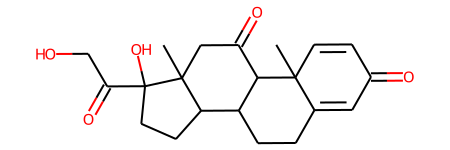

In [420]:
drug_src_node_id_mol_graph = drug_stitich_id_mol_graph_tup[drug_src_node_id.item()][1]
drug_src_node_id_mol_graph

In [421]:
drug_src_node_id_mol_graph.GetNumAtoms()

26

In [422]:
h_att_scores[0].shape

torch.Size([18090])

In [423]:
h_att_batch[1][1].shape

torch.Size([18090])

In [424]:
h_att_batch[1][1] # tensor([  0,   0,   0,  ..., 691, 691, 691])
# fetch index where value is 0 in h_att_batch[0][1]

tensor([  0,   0,   0,  ..., 568, 568, 568])

In [425]:
index_for_drug_src = h_att_batch[1][1]

In [426]:
# Find the indices where the value is 0

indices_with_value_zero = (index_for_drug_src == 0).nonzero()


In [427]:
ID_TO_STITCH_DICT[0]

'CID000000119'

In [472]:
# attention value for atoms in drug_src_node_id_mol_graph
normalized_scores_0 = h_att_scores[0][indices_with_value_zero].flatten().cpu().numpy()
normalized_scores_0

array([0.03744584, 0.0251534 , 0.03956582, 0.04116194, 0.04748248,
       0.03016473, 0.02589133, 0.0234059 , 0.03119337, 0.03364785,
       0.03364082, 0.05393966, 0.05041063, 0.04993866, 0.04550093,
       0.0400172 , 0.0297069 , 0.03229349, 0.03182364, 0.04494989,
       0.05577276, 0.05148186, 0.04549687, 0.03811008, 0.02455663,
       0.03724735], dtype=float32)

In [428]:
# attention value for atoms in drug_src_node_id_mol_graph
normalized_scores = h_att_scores[1][indices_with_value_zero].flatten().cpu().numpy()
normalized_scores

array([0.03876798, 0.03899309, 0.0393102 , 0.04030417, 0.03862141,
       0.04034539, 0.04021627, 0.03965447, 0.03870973, 0.03764796,
       0.03542809, 0.03430703, 0.03595514, 0.03358351, 0.03461846,
       0.03657612, 0.03964763, 0.03951464, 0.04006314, 0.03959893,
       0.04045722, 0.03866507, 0.03960053, 0.039609  , 0.04067109,
       0.03913369], dtype=float32)

In [429]:
normalized_scores.shape

(26,)

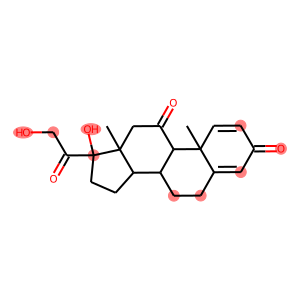

In [473]:
# Define sample data
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

# Sample molecule with 10 atoms
mol = drug_src_node_id_mol_graph
normalized_scores = normalized_scores

# Threshold
thresh = 0.05

# Define the indices of atoms you want to highlight
highlight_indices = [i for i, score in enumerate(normalized_scores) if score > thresh]

# Atom colors
colors = [(1, 1, 0) if i in highlight_indices else (0, 0, 0) for i in range(mol.GetNumAtoms())]

# Draw molecule
img = Draw.MolToImage(mol, highlightAtoms=highlight_indices, highlightBonds=[], highlightAtomColors=colors)
img


In [478]:
len(normalized_scores_0[normalized_scores_0 > 0.05])

4

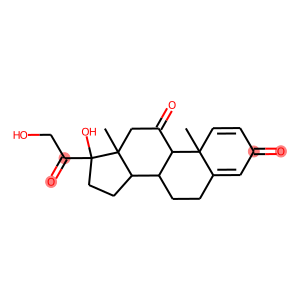

In [474]:
# Define sample data
import numpy as npv
from rdkit import Chem
from rdkit.Chem import Draw

# Sample molecule with 10 atoms
mol = drug_src_node_id_mol_graph
normalized_scores = normalized_scores_0

# Threshold
thresh = 0.05

# Define the indices of atoms you want to highlight
highlight_indices = [i for i, score in enumerate(normalized_scores) if score > thresh]

# Atom colors
colors = [(1, 1, 0) if i in highlight_indices else (0, 0, 0) for i in range(mol.GetNumAtoms())]

# Draw molecule
img = Draw.MolToImage(mol, highlightAtoms=highlight_indices, highlightBonds=[], highlightAtomColors=colors)
img


#### Custom Multi-Head Model

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
class CustomAttentionMHModel(nn.Module):
    def __init__(self, data, hidden_channels, use_node_features=False):
        super().__init__()
        # Instantiate node embeddings:
        self.drug_emb = torch.nn.Embedding(data["drug"].num_nodes, hidden_channels)
        self.seff_emb = torch.nn.Embedding(data["side_effect"].num_nodes, hidden_channels)
        # Instantiate GNNs
        self.use_node_features = use_node_features
        if use_node_features:
            self.drug_feat_layernorm = torch.nn.LayerNorm(data["drug"].num_features)
            self.drug_lin = torch.nn.Linear(data["drug"].num_features, hidden_channels)
        # Instantiate classifier:
        self.classifier = ClassifierMH()
        # xavier initialization of weights for emb layers for both drug and side_effect
        torch.nn.init.xavier_uniform_(self.drug_emb.weight)
        torch.nn.init.xavier_uniform_(self.seff_emb.weight)

#### Old Multi MHModel

In [57]:
# Homegenous Model for Edge Prediction
class MHModel(torch.nn.Module):
    def __init__(self, data, input_features_dim, heads_out_feat_params, blocks_nh_params, use_node_features=False):
        super().__init__()
        # Instantiate node embeddings:
        self.drug_emb = torch.nn.Embedding(data["drug"].num_nodes, input_features_dim)
        self.dropout = torch.nn.Dropout(0.3)
        self.seff_emb = torch.nn.Embedding(data["side_effect"].num_nodes, input_features_dim)
      
        # Instantiate GNNs:
        self.gnn = MHGNN(input_features_dim, heads_out_feat_params, blocks_nh_params)
        # Convert GNN model into a heterogeneous variant:
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())
        self.use_node_features = use_node_features
        if use_node_features:
            self.drug_feat_layernorm = torch.nn.LayerNorm(data["drug"].num_features)
            self.drug_lin = torch.nn.Linear(data["drug"].num_features, input_features_dim)
            torch.nn.init.xavier_uniform_(self.drug_lin.weight)
            
        # Instantiate classifier:
        self.classifier = ClassifierMH() 
        # xavier initialization of weights for emb layers for both drug and side_effect
        torch.nn.init.xavier_uniform_(self.drug_emb.weight)
        torch.nn.init.xavier_uniform_(self.seff_emb.weight)
        

    def forward(self, data: HeteroData) -> Tensor:
        # print(data.node_types)
        # print node types shape
        
        if self.use_node_features:
            x_dict = {
                "drug":  self.drug_emb(data["drug"].node_id) + self.dropout(self.drug_lin(self.drug_feat_layernorm(data["drug"].x))),
                "side_effect":self.seff_emb(data["side_effect"].node_id)
            }
        else:
            # layer normalization of input features:
            x_dict = {
                "drug":  self.drug_emb(data["drug"].node_id), #+ self.drug_lin(self.drug_feat_layernorm(data["drug"].x)),
                "side_effect": self.seff_emb(data["side_effect"].node_id)
            }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict_etype = self.gnn(x_dict, data.edge_index_dict, data.edge_attr_dict)
        x_drug = torch.sum(torch.stack([x_dict_etype[et] for et in data.edge_types if 'drug' in et[-1]]), dim=0)
        x_seff = torch.sum(torch.stack([x_dict_etype[et] for et in data.edge_types if 'side_effect' in et[-1]]), dim=0)
        
        pred = self.classifier(
            x_drug,
            x_seff,
            data["drug", "known", "side_effect"].edge_label_index,
        )

        return pred


In [58]:
data.metadata()

(['drug', 'side_effect'],
 [('drug', 'known', 'side_effect'),
  ('drug', 'to', 'drug'),
  ('side_effect', 'to', 'side_effect'),
  ('side_effect', 'rev_known', 'drug')])

In [59]:
# tgnn = GNN(128)
# tgnn = to_hetero(tgnn, metadata=data.metadata())

In [60]:
# tgnn

### Train using scheduler and early stopping and tensorboard

In [61]:
# ! pip install tensorboard

In [62]:
# ! pip install torch-tb-profiler

In [60]:
# include tensorboard for visualization of metrics and model graph
from datetime import datetime
import tqdm, time
from torch.utils.tensorboard import SummaryWriter


def do_train_compute(batch, device, model):
    # batch = batch.to(device)
    pred, _, _ = model(batch)
    actual = batch["drug", "known", "side_effect"].edge_label
    return pred, actual
    
def evaluate_metrics(probas_pred, ground_truth):
    # compute binary classification metrics using sklearn
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, average_precision_score
    # convert to numpy array
    probas_pred = probas_pred.numpy()
    # print(probas_pred.shape)
    ground_truth = ground_truth.numpy()
    # print(ground_truth.shape)
    # convert to binary predictions
    binary_pred = np.where(probas_pred > 0.5, 1, 0)

    # print(f"unique values in binary_pred: {np.unique(binary_pred)}")
    # print(f"unique values in ground_truth: {np.unique(ground_truth)}")
    
    # compute metrics
    accuracy = accuracy_score(ground_truth, binary_pred)
    # print unique values in ground_truth
    # print(np.unique(ground_truth), ground_truth.shape, ground_truth)
    # print(np.unique(binary_pred), binary_pred.shape, binary_pred)
    precision = precision_score(ground_truth, binary_pred)
    recall = recall_score(ground_truth, binary_pred)
    f1 = f1_score(ground_truth, binary_pred)
    roc_auc = roc_auc_score(ground_truth, probas_pred)
    precision_, recall_, _ = precision_recall_curve(ground_truth, probas_pred)
    pr_auc = auc(recall_, precision_)
    average_precision = average_precision_score(ground_truth, probas_pred)
    return accuracy, precision, recall, f1, roc_auc, pr_auc, average_precision

def train_loop(model, model_name, writer, train_loader, val_loader, loss_fn, optimizer, n_epochs, device, scheduler=None, early_stopping_patience=3, early_stopping_counter=0):
    early_stop = False
    best_val_metrics = -float("inf") #-float("inf")
    best_model_path = f"saved_models/{model_name}/best_model.pth"
    # make best_model_path parent directory if it doesn't exist
    os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
    
    print("Starting training loop at", datetime.today().strftime("%Y-%m-%d %H:%M:%S"))
    
    total_train_val_steps = len(train_loader) + len(val_loader)
    epoch_progress_bar = tqdm.notebook.tqdm(range(1, (total_train_val_steps*n_epochs)+1), desc="MiniBatches")
    epoch = 0
    for _ in epoch_progress_bar:
        epoch += 1
        start_time = time.time()
        train_loss = 0
        val_loss = 0
        train_probas_pred = []
        train_ground_truth = []
        val_probas_pred = []
        val_ground_truth = []
        print("Epoch", epoch)
        
        # # Initialize tqdm progress bars for batches
        # train_bar = tqdm.tqdm(total=len(train_loader), desc=f"Epoch {epoch} - LR {lr:.7f} - Train")
        # val_bar = tqdm.tqdm(total=len(val_loader), desc=f"Epoch {epoch} - LR {lr:.7f} - Validation")
        model.train()
        for idx, batch in enumerate(train_loader):
            batch = batch.to(device)
            lr = optimizer.param_groups[0]['lr']
            optimizer.zero_grad()
            out, actual = do_train_compute(batch, device, model)
            pred = torch.sigmoid(out)
            train_probas_pred.append(pred.detach().cpu())
            train_ground_truth.append(actual.detach().cpu())
            loss = loss_fn(out, actual)
            loss.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Adjust max_norm as needed

            optimizer.step()
            train_loss += loss.item()
            epoch_progress_bar.set_postfix_str(f"Epoch {epoch} - LR {lr:.7f} - Train Batch {idx+1}/{len(train_loader)} - Train loss: {train_loss/(idx+1):.4f}")
            epoch_progress_bar.update()
            writer.add_scalar("Training Loss MiniBatch", loss.item(), idx)
            batch = batch.to("cpu")
            # if scheduler is not None: # cosine annealing scheduler
            #     scheduler.step()
        
        train_loss /= len(train_loader)
        writer.add_scalar("Training Loss Epoch", train_loss, epoch)
        model.eval()
        with torch.no_grad():
            train_probas_pred = torch.cat(train_probas_pred, dim=0)
            train_ground_truth = torch.cat(train_ground_truth, dim=0)
            train_accuracy, train_precision, train_recall, train_f1, train_roc_auc, train_pr_auc, train_average_precision = evaluate_metrics(train_probas_pred, train_ground_truth)
            writer.add_scalar("Training Accuracy", train_accuracy, epoch)
            writer.add_scalar("Training Precision", train_precision, epoch)
            writer.add_scalar("Training Recall", train_recall, epoch)
            writer.add_scalar("Training F1", train_f1, epoch)
            writer.add_scalar("Training ROC AUC", train_roc_auc, epoch)
            writer.add_scalar("Training PR AUC", train_pr_auc, epoch)
            writer.add_scalar("Training Average Precision", train_average_precision, epoch)

            for idx_, batch in enumerate(val_loader):
                batch = batch.to(device)
                out, actual = do_train_compute(batch, device, model)
                pred = torch.sigmoid(out)
                val_probas_pred.append(pred.detach().cpu())
                val_ground_truth.append(actual.detach().cpu())
                loss = loss_fn(out, actual)
                val_loss += loss.item()
                epoch_progress_bar.set_postfix_str(f"Epoch {epoch} - LR {lr:.7f} - Val Batch {idx_+1}/{len(val_loader)} - Val loss: {val_loss/(idx+1):.4f}")
                epoch_progress_bar.update()
                writer.add_scalar("Validation Loss MiniBatch", loss.item(), idx_)
                batch = batch.to("cpu")
            val_loss /= len(val_loader)
            val_probas_pred = torch.cat(val_probas_pred, dim=0)
            val_ground_truth = torch.cat(val_ground_truth, dim=0)
            val_accuracy, val_precision, val_recall, val_f1, val_roc_auc, val_pr_auc, val_average_precision = evaluate_metrics(val_probas_pred, val_ground_truth)
            
            writer.add_scalar("Validation Loss Epoch", val_loss, epoch)
            writer.add_scalar("Validation Accuracy", val_accuracy, epoch)
            writer.add_scalar("Validation Precision", val_precision, epoch)
            writer.add_scalar("Validation Recall", val_recall, epoch)
            writer.add_scalar("Validation F1", val_f1, epoch)
            writer.add_scalar("Validation ROC AUC", val_roc_auc, epoch)
            writer.add_scalar("Validation PR AUC", val_pr_auc, epoch)
            writer.add_scalar("Validation Average Precision", val_average_precision, epoch)
            
            if val_f1 > best_val_metrics:
                best_val_metrics = val_f1
                early_stopping_counter = 0
                torch.save(model.state_dict(), best_model_path)
                print("New best model saved!") 
            else:
                early_stopping_counter += 1
                print("Early stopping counter:", early_stopping_counter)
                if early_stopping_counter >= early_stopping_patience:
                    print("Early stopping triggered!")
                    early_stop = True
        
        if scheduler is not None:
            scheduler.step(val_f1)
      
        
        # val_bar.set_postfix_str("Train loss: {:.4f}, Train f1: {:.4f}, Train auc: {:.4f}, Train pr_auc: {:.4f},\
        #                            Val loss: {:.4f}, Val f1: {:.4f}, Val auc: {:.4f}, Val pr_auc: {:.4f},\
        #                            Best val f1: {:.4f}".format(train_loss, train_f1, train_roc_auc, train_pr_auc,\
        #                                                         val_loss, val_f1, val_roc_auc, val_pr_auc, best_val_metrics))
        # val_bar.update()

        epoch_progress_bar.set_postfix_str("Train loss: {:.4f}, Train f1: {:.4f}, Train auc: {:.4f}, Train pr_auc: {:.4f},\
                                            Val loss: {:.4f}, Val f1: {:.4f}, Val auc: {:.4f}, Val pr_auc: {:.4f},\
                                            Best val f1: {:.4f}".format(train_loss, train_f1, train_roc_auc, train_pr_auc,\
                                            val_loss, val_f1, val_roc_auc, val_pr_auc, best_val_metrics))
        epoch_progress_bar.update()
        print("Epoch Number:", epoch)   
        print("Epoch time:", time.time() - start_time)
        print("Train loss:", train_loss)
        print("Train accuracy:", train_accuracy)
        print("Train precision:", train_precision)
        print("Train recall:", train_recall)
        print("Train f1:", train_f1)
        print("Train roc_auc:", train_roc_auc)
        print("Train pr_auc:", train_pr_auc)
        print("Train average_precision:", train_average_precision)
        
        print("Val loss:", val_loss)
        print("Val accuracy:", val_accuracy)
        print("Val precision:", val_precision)
        print("Val recall:", val_recall)
        print("Val f1:", val_f1)
        print("Val roc_auc:", val_roc_auc)
        print("Val pr_auc:", val_pr_auc)
        print("Val average_precision:", val_average_precision)
        print("Best val_f1:", best_val_metrics)
        print()
        if early_stop:
            break
        if epoch == n_epochs:
            print("Training completed!")
            break
    # epoch_progress_bar.close()
    # load best model 
    model.load_state_dict(torch.load(best_model_path))
    return model

In [64]:
# minibatch_train = next(iter(train_loader))
# minibatch_train.num_edges_dict
# subgraph will extract the subgraph of the given edge_index and edge_attr from the given data and edge_index

### Train Wrap Method

In [61]:
# mhgat
import tqdm, os
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_wrap(model, model_name):
    # Define the log directory where TensorBoard logs will be stored
    log_dir = f"logs/{model_name}/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir, exist_ok=True)

    # Create a SummaryWriter
    writer = SummaryWriter(log_dir)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: '{device}'")

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-3) #, weight_decay=5e-4
    
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.96 ** (epoch))
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=len(train_loader), T_mult=1, eta_min=1e-5, verbose=False)
    # on plateau scheduler
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-6, eps=1e-08)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=2, min_lr=1e-6
        )
    
    # print layer_name and number of parameters
    # for name, param in model.named_parameters():
    #     print(name, param.numel())

    print(f"Total Number of Parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Total Number of Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    
    

    model = train_loop(model, model_name, writer, train_loader, val_loader, F.binary_cross_entropy_with_logits, optimizer, n_epochs=30, device=device, scheduler=scheduler, early_stopping_patience=5)
    return model

### Evaluation on loader

In [57]:

from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

def evaluate_fold(loader, model, device):
    preds = []
    ground_truths = []
    model.eval()
    for sampled_data in tqdm.tqdm(loader):
        with torch.no_grad():
            sampled_data.to(device)
            pred = model(sampled_data)
            # Applying sigmoid activation function to the predicted values
            output_probs = torch.sigmoid(pred)

            # Converting probabilities to binary class predictions
            # output_classes = (output_probs > 0.5).int()
            preds.append(output_probs)
            ground_truths.append(sampled_data["drug", "known", "side_effect"].edge_label)

    pred = torch.cat(preds, dim=0).cpu().numpy()
    pred_int = (pred>0.5).astype(int)
    ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

    auc = roc_auc_score(ground_truth, pred)
    ap = average_precision_score(ground_truth, pred)
    f1 = f1_score(ground_truth, pred_int)
    acc = (pred_int == ground_truth).mean()
    precision = precision_score(ground_truth, pred_int)
    recall = recall_score(ground_truth, pred_int)
    print()
    print(f"Validation AUC: {auc:.4f}")
    print(f"Validation AP: {ap:.4f}")
    print(f"Validation F1: {f1:.4f}")
    print(f"Validation Accuracy: {acc:.4f}")
    print(f"Validation Precission: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")


### Train wrap models

#### Vanilla Sage

In [53]:
gnn_model = SageGNN(hidden_channels=128)
gnn_model = to_hetero(gnn_model, metadata=data.metadata())
classifier_model = VanillaClassifier()
model_vanilla = VanillaModel(data, hidden_channels=128, gnn_model=gnn_model, classifier_model=classifier_model, use_node_features=True)
model_vanilla = train_wrap(model_vanilla, "vanilla_sage")
model_vanilla


NameError: name 'VanillaModel' is not defined

In [99]:
# load best model
model_vanilla.load_state_dict(torch.load("saved_models/best_model.pth"))

<All keys matched successfully>

In [100]:
evaluate_fold(val_loader, model_vanilla, device)

100%|██████████| 305/305 [00:03<00:00, 86.02it/s] 


Validation AUC: 0.9142
Validation AP: 0.8364
Validation F1: 0.7761
Validation Accuracy: 0.8525
Validation Precission: 0.7852
Validation Recall: 0.7673


In [101]:
evaluate_fold(test_loader, model_vanilla, device)

100%|██████████| 305/305 [00:04<00:00, 71.83it/s]



Validation AUC: 0.9139
Validation AP: 0.8356
Validation F1: 0.7731
Validation Accuracy: 0.8505
Validation Precission: 0.7823
Validation Recall: 0.7641


#### GATVanilla

In [162]:
gnn_model = GatGNN(hidden_channels=128)
gnn_model = to_hetero(gnn_model, metadata=data.metadata())
classifier_model = VanillaClassifier()
model_vanilla = VanillaModel(data, hidden_channels=128, gnn_model=gnn_model, classifier_model=classifier_model, use_node_features=True)
model_vanilla = train_wrap(model_vanilla, "vanilla_gat")
model_vanilla


Device: 'cuda'
Total trainable parameters: 634766
Starting training loop at 2023-09-14 11:28:19


MiniBatches:   0%|          | 0/16470 [00:00<?, ?it/s]

Epoch 1
New best model saved!
Epoch Number: 1
Epoch time: 72.884197473526
Train loss: 4.444570875558697
Train accuracy: 0.7529628203482651
Train precision: 0.634403944825748
Train recall: 0.6109934539853678
Train f1: 0.6224786688025108
Train roc_auc: 0.7634142498623675
Train pr_auc: 0.5678048345907445
Train average_precision: 0.5594188371118953
Val loss: 0.3995262540754725
Val accuracy: 0.8250545501219355
Val precision: 0.7957246932515337
Val recall: 0.639276087793608
Val f1: 0.7089721142759533
Val roc_auc: 0.8872396454604102
Val pr_auc: 0.8054414989190428
Val average_precision: 0.8054584084084998
Best val_f1: 0.7089721142759533

Epoch 2
New best model saved!
Epoch Number: 2
Epoch time: 74.39570760726929
Train loss: 0.4021208189794275
Train accuracy: 0.8194711847002952
Train precision: 0.7401008403361344
Train recall: 0.7065203439866513
Train f1: 0.7229208392159437
Train roc_auc: 0.88366677562317
Train pr_auc: 0.7699201559409261
Train average_precision: 0.769937366627632
Val loss: 0.37

VanillaModel(
  (drug_emb): Embedding(1326, 128)
  (seff_emb): Embedding(2061, 128)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (drug__known__side_effect): GATConv(128, 128, heads=1)
      (drug__to__drug): GATConv(128, 128, heads=1)
      (side_effect__to__side_effect): GATConv(128, 128, heads=1)
      (side_effect__rev_known__drug): GATConv(128, 128, heads=1)
    )
    (lin1): ModuleDict(
      (drug): Linear(in_features=128, out_features=128, bias=True)
      (side_effect): Linear(in_features=128, out_features=128, bias=True)
    )
    (conv2): ModuleDict(
      (drug__known__side_effect): GATConv(128, 128, heads=1)
      (drug__to__drug): GATConv(128, 128, heads=1)
      (side_effect__to__side_effect): GATConv(128, 128, heads=1)
      (side_effect__rev_known__drug): GATConv(128, 128, heads=1)
    )
    (lin2): ModuleDict(
      (drug): Linear(in_features=128, out_features=128, bias=True)
      (side_effect): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  

In [163]:
evaluate_fold(val_loader, model_vanilla, device)

  0%|          | 0/305 [00:00<?, ?it/s]

100%|██████████| 305/305 [00:13<00:00, 23.29it/s]



Validation AUC: 0.9173
Validation AP: 0.8474
Validation F1: 0.7763
Validation Accuracy: 0.8550
Validation Precission: 0.7991
Validation Recall: 0.7549


In [164]:
evaluate_fold(test_loader, model_vanilla, device)

100%|██████████| 305/305 [00:12<00:00, 23.63it/s]


Validation AUC: 0.9188
Validation AP: 0.8497
Validation F1: 0.7792
Validation Accuracy: 0.8565
Validation Precission: 0.7998
Validation Recall: 0.7596


#### DV Model

In [94]:
import torch
from torch.nn import Parameter

def count_parameters(model):
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    total_params = sum([torch.numel(p) for p in trainable_params])
    return total_params

# Create an instance of your model
# model = DVModel()

# Calculate the total number of trainable parameters
total_params = count_parameters(model_dv)
print(f"Total trainable parameters: {total_params}")
# Microsoft - Total trainable parameters: 1659053

Total trainable parameters: 784880


In [63]:
gnn_model = MHGNN(input_dim=128, hidden_dims=[64], heads=[2])
# gnn_model = GatGNN(hidden_channels=384)
gnn_model = to_hetero(gnn_model, metadata=data.metadata())
classifier_model =  ClassifierMHFlatten() #
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dv = DVModelCross(hidden_channels=128, gnn_model=gnn_model,
                   classifier_model=classifier_model, use_node_features=False)
model_dv = train_wrap(model_dv, "dv_gat_cross")
model_dv

Device: 'cuda'
Total Number of Parameters: 381104
Total Number of Trainable Parameters: 381104
Starting training loop at 2023-09-26 17:50:03


MiniBatches:   0%|          | 0/26790 [00:00<?, ?it/s]

Epoch 1


In [62]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [49]:
model_dv

DVModel(
  (seff_emb): Embedding(2061, 128)
  (drug_emb): FinalDrugMolEmb(
    (inital_norm): LayerNorm((55,), eps=1e-05, elementwise_affine=True)
    (blocks): ModuleList(
      (0): DrugInterView_Block(
        (feature_conv): GATConv(55, 32, heads=2)
        (intraAtt): IntraGraphAttention(
          (intra): GATConv(64, 32, heads=2)
        )
        (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
      )
      (1): DrugInterView_Block(
        (feature_conv): GATConv(64, 32, heads=2)
        (intraAtt): IntraGraphAttention(
          (intra): GATConv(64, 32, heads=2)
        )
        (readout): SAGPooling(GraphConv, 64, min_score=-1, multiplier=1.0)
      )
    )
    (net_norms): ModuleList(
      (0): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (drug__known__side_effect): GATConv(128, 128, heads=1)
      (drug__to__drug): GATC

#### MultiHead Model - Single Head

In [120]:
## Multi Head Model

gnn_model = MHGNN(input_dim=128, hidden_dims=[128, 128], heads=[1, 1])
gnn_model = to_hetero(gnn_model, metadata=data.metadata())
classifier_model = ClassifierMH()
model_mh = MultiHeadModel(data, hidden_channels=128, gnn_model=gnn_model, classifier_model=classifier_model, use_node_features=True)
model_mh = train_wrap(model_mh, "mhgat")
model_mh

Device: 'cuda'
Total trainable parameters: 567694
Starting training loop at 2023-09-13 17:02:54


MiniBatches:   0%|          | 0/16470 [00:00<?, ?it/s]

Epoch 1
New best model saved!
Epoch Number: 1
Epoch time: 17.978464126586914
Train loss: 1.1983908384305533
Train accuracy: 0.7675950883498053
Train precision: 0.6578771248828805
Train recall: 0.6308561160313182
Train f1: 0.644083344253702
Train roc_auc: 0.7991091702565949
Train pr_auc: 0.6094810746052486
Train average_precision: 0.6062233629092327
Val loss: 0.3643456006147822
Val accuracy: 0.8420741881658323
Val precision: 0.7869802603947921
Val recall: 0.7215248363496342
Val f1: 0.7528324628364805
Val roc_auc: 0.9046905459025394
Val pr_auc: 0.834950480734673
Val average_precision: 0.8349605914886549
Best val_f1: 0.7528324628364805

Epoch 2
New best model saved!
Epoch Number: 2
Epoch time: 18.086132764816284
Train loss: 0.38358016678544343
Train accuracy: 0.8266161810636204
Train precision: 0.7460672678207069
Train recall: 0.7274419201642921
Train f1: 0.7366368805848903
Train roc_auc: 0.8945574761340178
Train pr_auc: 0.782190338902857
Train average_precision: 0.7822041885530084
Val lo

MultiHeadModel(
  (drug_emb): Embedding(1326, 128)
  (seff_emb): Embedding(2061, 128)
  (gnn): GraphModule(
    (skips): ModuleList(
      (0): ModuleDict(
        (drug): Linear(in_features=128, out_features=128, bias=True)
        (side_effect): Linear(in_features=128, out_features=128, bias=True)
      )
      (1): ModuleDict(
        (drug): Linear(in_features=128, out_features=128, bias=True)
        (side_effect): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (GATLayers): ModuleList(
      (0): ModuleDict(
        (drug__known__side_effect): GATConv(128, 128, heads=1)
        (side_effect__rev_known__drug): GATConv(128, 128, heads=1)
      )
      (1): ModuleDict(
        (drug__known__side_effect): GATConv(128, 128, heads=1)
        (side_effect__rev_known__drug): GATConv(128, 128, heads=1)
      )
    )
  )
  (drug_feat_layernorm): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
  (drug_lin): Linear(in_features=7, out_features=128, bias=True)
  (cla

In [121]:
evaluate_fold(val_loader, model_mh, device)

100%|██████████| 305/305 [00:03<00:00, 94.27it/s] 


Validation AUC: 0.8981
Validation AP: 0.8044
Validation F1: 0.7329
Validation Accuracy: 0.8348
Validation Precission: 0.7948
Validation Recall: 0.6799


In [122]:
evaluate_fold(test_loader, model_mh, device)

100%|██████████| 305/305 [00:02<00:00, 107.83it/s]


Validation AUC: 0.8988
Validation AP: 0.8082
Validation F1: 0.7310
Validation Accuracy: 0.8340
Validation Precission: 0.7951
Validation Recall: 0.6764


#### MultiHead Model - M Head
 

In [135]:
## Multi Head Model

gnn_model = MHGNN(input_dim=128, hidden_dims=[128, 128], heads=[3, 3])
gnn_model = to_hetero(gnn_model, metadata=data.metadata())
classifier_model = ClassifierMH()
model_mh = MultiHeadModel(data, hidden_channels=128, gnn_model=gnn_model, classifier_model=classifier_model, use_node_features=False)
model_mh = train_wrap(model_mh, "mhgat")
model_mh

Device: 'cuda'
Total trainable parameters: 1226112
Starting training loop at 2023-09-13 17:42:18


MiniBatches:   0%|          | 0/16470 [00:00<?, ?it/s]

Epoch 1
New best model saved!
Epoch Number: 1
Epoch time: 26.03942084312439
Train loss: 0.6560522672094282
Train accuracy: 0.7712959397595516
Train precision: 0.6645582396877734
Train recall: 0.6338082402772429
Train f1: 0.6488191045560555
Train roc_auc: 0.815070123937307
Train pr_auc: 0.6324417704225243
Train average_precision: 0.6310318184666222
Val loss: 0.378118034464414
Val accuracy: 0.8375818251829034
Val precision: 0.7715334420880914
Val recall: 0.7284559106661532
Val f1: 0.7493761140819963
Val roc_auc: 0.8994465534341112
Val pr_auc: 0.8190829241436974
Val average_precision: 0.8191174901790079
Best val_f1: 0.7493761140819963

Epoch 2
New best model saved!
Epoch Number: 2
Epoch time: 26.82779884338379
Train loss: 0.3980117272890982
Train accuracy: 0.8204124417062423
Train precision: 0.7366324246016067
Train recall: 0.7179116929790784
Train f1: 0.7271515860634425
Train roc_auc: 0.8860005615700849
Train pr_auc: 0.7660376758359883
Train average_precision: 0.7660621758166017
Val loss

MultiHeadModel(
  (drug_emb): Embedding(1326, 128)
  (seff_emb): Embedding(2061, 128)
  (gnn): GraphModule(
    (skips): ModuleList(
      (0): ModuleDict(
        (drug): Linear(in_features=128, out_features=384, bias=True)
        (side_effect): Linear(in_features=128, out_features=384, bias=True)
      )
      (1): ModuleDict(
        (drug): Linear(in_features=384, out_features=384, bias=True)
        (side_effect): Linear(in_features=384, out_features=384, bias=True)
      )
    )
    (GATLayers): ModuleList(
      (0): ModuleDict(
        (drug__known__side_effect): GATConv(128, 128, heads=3)
        (side_effect__rev_known__drug): GATConv(128, 128, heads=3)
      )
      (1): ModuleDict(
        (drug__known__side_effect): GATConv(384, 128, heads=3)
        (side_effect__rev_known__drug): GATConv(384, 128, heads=3)
      )
    )
  )
  (classifier): ClassifierMH()
)

In [133]:
evaluate_fold(val_loader, model_mh, device)

100%|██████████| 305/305 [00:01<00:00, 178.45it/s]


Validation AUC: 0.9152
Validation AP: 0.8502
Validation F1: 0.7629
Validation Accuracy: 0.8523
Validation Precission: 0.8206
Validation Recall: 0.7128


In [134]:
evaluate_fold(test_loader, model_mh, device)

100%|██████████| 305/305 [00:01<00:00, 175.38it/s]


Validation AUC: 0.9158
Validation AP: 0.8460
Validation F1: 0.7645
Validation Accuracy: 0.8530
Validation Precission: 0.8204
Validation Recall: 0.7157


#### Multi-Head Hetero Full Graph

In [167]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [55]:
del model_mh

In [56]:

model_mh = MultiHeadModel(data, hidden_channels=64, gnn_model=to_hetero(MHGNN(input_dim=64, hidden_dims=[64,  64, 64], heads=[2, 2, 2]), metadata=data.metadata()), classifier_model=ClassifierMHFlatten(), use_node_features=False)
model_mh = train_wrap(model_mh, "mhgat_classifier_flatten")
model_mh

Device: 'cuda'
Total trainable parameters: 467904
Starting training loop at 2023-09-14 16:45:30


MiniBatches:   0%|          | 0/16470 [00:00<?, ?it/s]

Epoch 1
New best model saved!
Epoch Number: 1
Epoch time: 199.05951976776123
Train loss: 1.1170445983527137
Train accuracy: 0.7596692765156376
Train precision: 0.6537359878354964
Train recall: 0.5932165318957772
Train f1: 0.6220076375687634
Train roc_auc: 0.7884726661495964
Train pr_auc: 0.6096072125602344
Train average_precision: 0.6082523222983406
Val loss: 0.3737047952218134
Val accuracy: 0.8371197535618021
Val precision: 0.7902097902097902
Val recall: 0.6961879091259146
Val f1: 0.7402251791197544
Val roc_auc: 0.9002724464070908
Val pr_auc: 0.8310185144448122
Val average_precision: 0.8310314031110702
Best val_f1: 0.7402251791197544

Epoch 2
New best model saved!
Epoch Number: 2
Epoch time: 198.63284063339233
Train loss: 0.40095043536580977
Train accuracy: 0.8194818808026355
Train precision: 0.7403519397059318
Train recall: 0.7060711076883583
Train f1: 0.7228052886589472
Train roc_auc: 0.8836909685015477
Train pr_auc: 0.7710626690212016
Train average_precision: 0.7710835359518071
Val

MultiHeadModel(
  (drug_emb): Embedding(1326, 64)
  (seff_emb): Embedding(2061, 64)
  (gnn): GraphModule(
    (skips): ModuleList(
      (0): ModuleDict(
        (drug): Linear(in_features=64, out_features=128, bias=True)
        (side_effect): Linear(in_features=64, out_features=128, bias=True)
      )
      (1): ModuleDict(
        (drug): Linear(in_features=128, out_features=128, bias=True)
        (side_effect): Linear(in_features=128, out_features=128, bias=True)
      )
      (2): ModuleDict(
        (drug): Linear(in_features=128, out_features=128, bias=True)
        (side_effect): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (GATLayers): ModuleList(
      (0): ModuleDict(
        (drug__known__side_effect): GATConv(64, 64, heads=2)
        (drug__to__drug): GATConv(64, 64, heads=2)
        (side_effect__to__side_effect): GATConv(64, 64, heads=2)
        (side_effect__rev_known__drug): GATConv(64, 64, heads=2)
      )
      (1): ModuleDict(
        (dru

In [57]:
evaluate_fold(val_loader, model_mh, device)

100%|██████████| 305/305 [00:35<00:00,  8.50it/s]


Validation AUC: 0.9182
Validation AP: 0.8566
Validation F1: 0.7803
Validation Accuracy: 0.8577
Validation Precission: 0.8038
Validation Recall: 0.7580


In [58]:
evaluate_fold(test_loader, model_mh, device)

100%|██████████| 305/305 [00:36<00:00,  8.34it/s]


Validation AUC: 0.9188
Validation AP: 0.8571
Validation F1: 0.7801
Validation Accuracy: 0.8575
Validation Precission: 0.8029
Validation Recall: 0.7586


In [171]:
# empty cuda cache and garbage collection

import gc
gc.collect()
torch.cuda.empty_cache()

In [325]:
torch.cuda.empty_cache()

In [280]:
# load best model from best_model_path
best_model_path = "saved_models/best_model.pth"
model_mh.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

### Train the hetero model

In [157]:
# mhgat
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
model_mh = MHModel(input_features_dim=64, heads_out_feat_params=[128, 128, 128], blocks_nh_params=[2, 2, 2], use_node_features=False)
model_mh = model_mh.to(device)
optimizer = torch.optim.Adam(model_mh.parameters(), lr=0.001)

for epoch in range(1, 21):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model_mh(sampled_data)

        ground_truth = sampled_data["drug", "known", "side_effect"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


  0%|          | 0/61 [00:00<?, ?it/s]

100%|██████████| 61/61 [02:41<00:00,  2.65s/it]


Epoch: 001, Loss: 0.6944


100%|██████████| 61/61 [02:51<00:00,  2.81s/it]


Epoch: 002, Loss: 0.5755


100%|██████████| 61/61 [02:41<00:00,  2.65s/it]


Epoch: 003, Loss: 0.4413


100%|██████████| 61/61 [02:51<00:00,  2.82s/it]


Epoch: 004, Loss: 0.4320


100%|██████████| 61/61 [02:42<00:00,  2.67s/it]


Epoch: 005, Loss: 0.4251


100%|██████████| 61/61 [02:48<00:00,  2.76s/it]


Epoch: 006, Loss: 0.4258


100%|██████████| 61/61 [02:39<00:00,  2.62s/it]


Epoch: 007, Loss: 0.4276


100%|██████████| 61/61 [02:46<00:00,  2.73s/it]


Epoch: 008, Loss: 0.4253


100%|██████████| 61/61 [02:49<00:00,  2.77s/it]


Epoch: 009, Loss: 0.4247


100%|██████████| 61/61 [02:59<00:00,  2.95s/it]


Epoch: 010, Loss: 0.4228


 38%|███▊      | 23/61 [01:05<01:47,  2.84s/it]


KeyboardInterrupt: 

In [206]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model_mh.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 449472


In [156]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in model_mh.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 442176


In [154]:
#gatconv with xav init
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
model = Model(hidden_channels=256, use_node_features=False)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 21):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["drug", "known", "side_effect"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


100%|██████████| 61/61 [00:06<00:00,  8.78it/s]


Epoch: 001, Loss: 0.4860


100%|██████████| 61/61 [00:06<00:00,  9.88it/s]


Epoch: 002, Loss: 0.3873


100%|██████████| 61/61 [00:06<00:00,  9.71it/s]


Epoch: 003, Loss: 0.3715


100%|██████████| 61/61 [00:05<00:00, 10.25it/s]


Epoch: 004, Loss: 0.3688


100%|██████████| 61/61 [00:06<00:00,  9.65it/s]


Epoch: 005, Loss: 0.3591


100%|██████████| 61/61 [00:06<00:00,  9.67it/s]


Epoch: 006, Loss: 0.3554


100%|██████████| 61/61 [00:05<00:00, 10.33it/s]


Epoch: 007, Loss: 0.3498


100%|██████████| 61/61 [00:05<00:00, 10.69it/s]


Epoch: 008, Loss: 0.3399


100%|██████████| 61/61 [00:06<00:00, 10.07it/s]


Epoch: 009, Loss: 0.3317


100%|██████████| 61/61 [00:06<00:00,  9.46it/s]


Epoch: 010, Loss: 0.3299


100%|██████████| 61/61 [00:06<00:00,  9.61it/s]


Epoch: 011, Loss: 0.3213


100%|██████████| 61/61 [00:06<00:00,  9.38it/s]


Epoch: 012, Loss: 0.3139


100%|██████████| 61/61 [00:06<00:00,  9.76it/s]


Epoch: 013, Loss: 0.3069


100%|██████████| 61/61 [00:05<00:00, 10.28it/s]


Epoch: 014, Loss: 0.3037


100%|██████████| 61/61 [00:06<00:00,  9.53it/s]


Epoch: 015, Loss: 0.2937


100%|██████████| 61/61 [00:06<00:00,  9.74it/s]


Epoch: 016, Loss: 0.2908


100%|██████████| 61/61 [00:06<00:00,  9.71it/s]


Epoch: 017, Loss: 0.2814


100%|██████████| 61/61 [00:06<00:00,  9.94it/s]


Epoch: 018, Loss: 0.2770


100%|██████████| 61/61 [00:06<00:00, 10.10it/s]


Epoch: 019, Loss: 0.2731


100%|██████████| 61/61 [00:06<00:00,  9.63it/s]


Epoch: 020, Loss: 0.2646


100%|██████████| 61/61 [00:05<00:00, 10.24it/s]


Epoch: 021, Loss: 0.2610


100%|██████████| 61/61 [00:05<00:00, 10.36it/s]


Epoch: 022, Loss: 0.2552


100%|██████████| 61/61 [00:06<00:00,  9.83it/s]


Epoch: 023, Loss: 0.2512


100%|██████████| 61/61 [00:05<00:00, 10.37it/s]


Epoch: 024, Loss: 0.2458


100%|██████████| 61/61 [00:06<00:00, 10.07it/s]


Epoch: 025, Loss: 0.2437


100%|██████████| 61/61 [00:05<00:00, 10.21it/s]


Epoch: 026, Loss: 0.2362


100%|██████████| 61/61 [00:05<00:00, 10.26it/s]


Epoch: 027, Loss: 0.2348


100%|██████████| 61/61 [00:05<00:00, 10.39it/s]


Epoch: 028, Loss: 0.2288


100%|██████████| 61/61 [00:06<00:00,  9.62it/s]


Epoch: 029, Loss: 0.2244


100%|██████████| 61/61 [00:05<00:00, 10.61it/s]

Epoch: 030, Loss: 0.2254


In [ ]:
# gatconv
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")
model = Model(hidden_channels=64, use_node_features=False)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 101):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["drug", "known", "side_effect"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


  0%|          | 0/61 [00:00<?, ?it/s]

100%|██████████| 61/61 [00:09<00:00,  6.60it/s]


Epoch: 001, Loss: 1.2169


100%|██████████| 61/61 [00:08<00:00,  7.16it/s]


Epoch: 002, Loss: 0.7611


100%|██████████| 61/61 [00:09<00:00,  6.41it/s]


Epoch: 003, Loss: 0.6419


100%|██████████| 61/61 [00:07<00:00,  8.11it/s]


Epoch: 004, Loss: 0.5875


100%|██████████| 61/61 [00:06<00:00,  9.53it/s]


Epoch: 005, Loss: 0.5461


100%|██████████| 61/61 [00:06<00:00,  9.21it/s]


Epoch: 006, Loss: 0.5239


100%|██████████| 61/61 [00:05<00:00, 10.18it/s]


Epoch: 007, Loss: 0.5054


100%|██████████| 61/61 [00:06<00:00,  9.36it/s]


Epoch: 008, Loss: 0.4914


100%|██████████| 61/61 [00:06<00:00,  9.70it/s]


Epoch: 009, Loss: 0.4803


100%|██████████| 61/61 [00:06<00:00,  9.64it/s]


Epoch: 010, Loss: 0.4709


100%|██████████| 61/61 [00:06<00:00, 10.10it/s]


Epoch: 011, Loss: 0.4636


100%|██████████| 61/61 [00:05<00:00, 10.33it/s]


Epoch: 012, Loss: 0.4509


100%|██████████| 61/61 [00:06<00:00,  9.42it/s]


Epoch: 013, Loss: 0.4507


100%|██████████| 61/61 [00:06<00:00,  9.85it/s]


Epoch: 014, Loss: 0.4428


100%|██████████| 61/61 [00:06<00:00,  9.53it/s]


Epoch: 015, Loss: 0.4324


100%|██████████| 61/61 [00:06<00:00,  8.89it/s]


Epoch: 016, Loss: 0.4345


100%|██████████| 61/61 [00:06<00:00,  9.74it/s]


Epoch: 017, Loss: 0.4261


100%|██████████| 61/61 [00:07<00:00,  8.71it/s]


Epoch: 018, Loss: 0.4219


100%|██████████| 61/61 [00:05<00:00, 10.66it/s]


Epoch: 019, Loss: 0.4191


100%|██████████| 61/61 [00:06<00:00,  9.54it/s]


Epoch: 020, Loss: 0.4151


100%|██████████| 61/61 [00:06<00:00,  9.38it/s]


Epoch: 021, Loss: 0.4080


100%|██████████| 61/61 [00:06<00:00,  9.67it/s]


Epoch: 022, Loss: 0.4056


100%|██████████| 61/61 [00:06<00:00,  9.46it/s]


Epoch: 023, Loss: 0.4045


100%|██████████| 61/61 [00:05<00:00, 10.46it/s]


Epoch: 024, Loss: 0.4035


100%|██████████| 61/61 [00:06<00:00,  9.25it/s]


Epoch: 025, Loss: 0.4004


100%|██████████| 61/61 [00:05<00:00, 10.22it/s]


Epoch: 026, Loss: 0.3949


100%|██████████| 61/61 [00:06<00:00, 10.03it/s]


Epoch: 027, Loss: 0.3934


100%|██████████| 61/61 [00:07<00:00,  8.65it/s]


Epoch: 028, Loss: 0.3900


100%|██████████| 61/61 [00:06<00:00,  9.46it/s]


Epoch: 029, Loss: 0.3851


100%|██████████| 61/61 [00:06<00:00,  9.26it/s]


Epoch: 030, Loss: 0.3871


100%|██████████| 61/61 [00:06<00:00,  9.05it/s]


Epoch: 031, Loss: 0.3862


100%|██████████| 61/61 [00:06<00:00,  9.18it/s]


Epoch: 032, Loss: 0.3826


100%|██████████| 61/61 [00:07<00:00,  8.66it/s]


Epoch: 033, Loss: 0.3807


100%|██████████| 61/61 [00:06<00:00,  9.64it/s]


Epoch: 034, Loss: 0.3792


100%|██████████| 61/61 [00:06<00:00,  9.15it/s]


Epoch: 035, Loss: 0.3789


100%|██████████| 61/61 [00:07<00:00,  8.64it/s]


Epoch: 036, Loss: 0.3741


100%|██████████| 61/61 [00:06<00:00,  9.16it/s]


Epoch: 037, Loss: 0.3702


100%|██████████| 61/61 [00:06<00:00,  9.16it/s]


Epoch: 038, Loss: 0.3694


100%|██████████| 61/61 [00:07<00:00,  8.28it/s]


Epoch: 039, Loss: 0.3683


100%|██████████| 61/61 [00:06<00:00,  9.07it/s]


Epoch: 040, Loss: 0.3682


100%|██████████| 61/61 [00:07<00:00,  8.55it/s]


Epoch: 041, Loss: 0.3617


100%|██████████| 61/61 [00:06<00:00,  9.69it/s]


Epoch: 042, Loss: 0.3596


100%|██████████| 61/61 [00:06<00:00,  9.17it/s]


Epoch: 043, Loss: 0.3613


100%|██████████| 61/61 [00:06<00:00,  9.91it/s]


Epoch: 044, Loss: 0.3602


100%|██████████| 61/61 [00:06<00:00,  9.82it/s]


Epoch: 045, Loss: 0.3575


100%|██████████| 61/61 [00:06<00:00,  9.97it/s]


Epoch: 046, Loss: 0.3584


100%|██████████| 61/61 [00:06<00:00,  8.86it/s]


Epoch: 047, Loss: 0.3502


100%|██████████| 61/61 [00:07<00:00,  8.56it/s]


Epoch: 048, Loss: 0.3507


100%|██████████| 61/61 [00:05<00:00, 10.36it/s]


Epoch: 049, Loss: 0.3520


100%|██████████| 61/61 [00:05<00:00, 10.26it/s]


Epoch: 050, Loss: 0.3493


100%|██████████| 61/61 [00:05<00:00, 10.61it/s]


Epoch: 051, Loss: 0.3466


100%|██████████| 61/61 [00:05<00:00, 11.69it/s]


Epoch: 052, Loss: 0.3472


100%|██████████| 61/61 [00:05<00:00, 10.83it/s]


Epoch: 053, Loss: 0.3467


100%|██████████| 61/61 [00:05<00:00, 11.20it/s]


Epoch: 054, Loss: 0.3453


100%|██████████| 61/61 [00:05<00:00, 12.16it/s]


Epoch: 055, Loss: 0.3413


100%|██████████| 61/61 [00:05<00:00, 11.62it/s]


Epoch: 056, Loss: 0.3421


100%|██████████| 61/61 [00:05<00:00, 11.69it/s]


Epoch: 057, Loss: 0.3382


100%|██████████| 61/61 [00:04<00:00, 12.32it/s]


Epoch: 058, Loss: 0.3367


100%|██████████| 61/61 [00:04<00:00, 13.77it/s]


Epoch: 059, Loss: 0.3380


100%|██████████| 61/61 [00:04<00:00, 12.73it/s]


Epoch: 060, Loss: 0.3351


100%|██████████| 61/61 [00:05<00:00, 11.78it/s]


Epoch: 061, Loss: 0.3319


100%|██████████| 61/61 [00:05<00:00, 10.64it/s]


Epoch: 062, Loss: 0.3336


100%|██████████| 61/61 [00:04<00:00, 12.27it/s]


Epoch: 063, Loss: 0.3315


100%|██████████| 61/61 [00:05<00:00, 10.70it/s]


Epoch: 064, Loss: 0.3292


100%|██████████| 61/61 [00:06<00:00,  9.54it/s]


Epoch: 065, Loss: 0.3275


100%|██████████| 61/61 [00:08<00:00,  7.29it/s]


Epoch: 066, Loss: 0.3256


100%|██████████| 61/61 [00:10<00:00,  5.64it/s]


Epoch: 067, Loss: 0.3278


100%|██████████| 61/61 [00:08<00:00,  6.93it/s]


Epoch: 068, Loss: 0.3241


100%|██████████| 61/61 [00:09<00:00,  6.63it/s]


Epoch: 069, Loss: 0.3197


100%|██████████| 61/61 [00:11<00:00,  5.39it/s]


Epoch: 070, Loss: 0.3219


100%|██████████| 61/61 [00:10<00:00,  5.61it/s]


Epoch: 071, Loss: 0.3225


100%|██████████| 61/61 [00:10<00:00,  5.77it/s]


Epoch: 072, Loss: 0.3183


100%|██████████| 61/61 [00:09<00:00,  6.28it/s]


Epoch: 073, Loss: 0.3152


100%|██████████| 61/61 [00:09<00:00,  6.15it/s]


Epoch: 074, Loss: 0.3155


100%|██████████| 61/61 [00:09<00:00,  6.37it/s]


Epoch: 075, Loss: 0.3150


100%|██████████| 61/61 [00:09<00:00,  6.54it/s]


Epoch: 076, Loss: 0.3122


100%|██████████| 61/61 [00:08<00:00,  7.17it/s]


Epoch: 077, Loss: 0.3163


100%|██████████| 61/61 [00:09<00:00,  6.49it/s]


Epoch: 078, Loss: 0.3102


100%|██████████| 61/61 [00:09<00:00,  6.75it/s]


Epoch: 079, Loss: 0.3119


100%|██████████| 61/61 [00:09<00:00,  6.26it/s]


Epoch: 080, Loss: 0.3081


100%|██████████| 61/61 [00:08<00:00,  7.58it/s]


Epoch: 081, Loss: 0.3054


100%|██████████| 61/61 [00:07<00:00,  8.33it/s]


Epoch: 082, Loss: 0.3102


100%|██████████| 61/61 [00:08<00:00,  7.33it/s]


Epoch: 083, Loss: 0.3046


100%|██████████| 61/61 [00:08<00:00,  7.03it/s]


Epoch: 084, Loss: 0.3040


100%|██████████| 61/61 [00:08<00:00,  7.16it/s]


Epoch: 085, Loss: 0.3026


100%|██████████| 61/61 [00:08<00:00,  7.62it/s]


Epoch: 086, Loss: 0.3055


100%|██████████| 61/61 [00:07<00:00,  7.77it/s]


Epoch: 087, Loss: 0.2980


100%|██████████| 61/61 [00:07<00:00,  7.85it/s]


Epoch: 088, Loss: 0.2977


100%|██████████| 61/61 [00:10<00:00,  6.04it/s]


Epoch: 089, Loss: 0.2955


100%|██████████| 61/61 [00:09<00:00,  6.67it/s]


Epoch: 090, Loss: 0.2945


100%|██████████| 61/61 [00:06<00:00,  9.90it/s]


Epoch: 091, Loss: 0.2930


100%|██████████| 61/61 [00:07<00:00,  8.29it/s]


Epoch: 092, Loss: 0.2921


100%|██████████| 61/61 [00:06<00:00,  9.01it/s]


Epoch: 093, Loss: 0.2900


100%|██████████| 61/61 [00:08<00:00,  6.83it/s]


Epoch: 094, Loss: 0.2890


100%|██████████| 61/61 [00:05<00:00, 11.57it/s]


Epoch: 095, Loss: 0.2870


100%|██████████| 61/61 [00:05<00:00, 11.19it/s]


Epoch: 096, Loss: 0.2853


100%|██████████| 61/61 [00:05<00:00, 11.55it/s]


Epoch: 097, Loss: 0.2867


100%|██████████| 61/61 [00:05<00:00, 12.06it/s]


Epoch: 098, Loss: 0.2873


100%|██████████| 61/61 [00:05<00:00, 10.23it/s]


Epoch: 099, Loss: 0.2849


100%|██████████| 61/61 [00:05<00:00, 10.54it/s]

Epoch: 100, Loss: 0.2810


In [ ]:
# check multi head attention, dv, negative sampling


In [ ]:
# train loop for drug fv features
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 20):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["drug", "to", "side_effect"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


100%|██████████| 244/244 [00:07<00:00, 31.33it/s]


Epoch: 001, Loss: 0.7234


100%|██████████| 244/244 [00:07<00:00, 30.81it/s]


Epoch: 002, Loss: 0.5584


100%|██████████| 244/244 [00:07<00:00, 30.82it/s]


Epoch: 003, Loss: 0.5267


100%|██████████| 244/244 [00:07<00:00, 30.77it/s]


Epoch: 004, Loss: 0.4903


100%|██████████| 244/244 [00:07<00:00, 30.99it/s]


Epoch: 005, Loss: 0.4784


100%|██████████| 244/244 [00:07<00:00, 30.72it/s]


Epoch: 006, Loss: 0.4699


100%|██████████| 244/244 [00:08<00:00, 30.07it/s]


Epoch: 007, Loss: 0.4500


100%|██████████| 244/244 [00:08<00:00, 30.04it/s]


Epoch: 008, Loss: 0.4382


100%|██████████| 244/244 [00:08<00:00, 29.96it/s]


Epoch: 009, Loss: 0.4349


100%|██████████| 244/244 [00:08<00:00, 29.45it/s]


Epoch: 010, Loss: 0.4294


100%|██████████| 244/244 [00:08<00:00, 29.70it/s]


Epoch: 011, Loss: 0.4307


100%|██████████| 244/244 [00:08<00:00, 29.46it/s]


Epoch: 012, Loss: 0.4273


100%|██████████| 244/244 [00:08<00:00, 29.36it/s]


Epoch: 013, Loss: 0.4246


100%|██████████| 244/244 [00:08<00:00, 29.38it/s]


Epoch: 014, Loss: 0.4265


100%|██████████| 244/244 [00:08<00:00, 29.84it/s]


Epoch: 015, Loss: 0.4186


100%|██████████| 244/244 [00:08<00:00, 29.34it/s]


Epoch: 016, Loss: 0.4270


100%|██████████| 244/244 [00:08<00:00, 29.55it/s]


Epoch: 017, Loss: 0.4300


100%|██████████| 244/244 [00:08<00:00, 29.18it/s]


Epoch: 018, Loss: 0.4186


100%|██████████| 244/244 [00:08<00:00, 29.42it/s]

Epoch: 019, Loss: 0.4176


Sampled mini-batch:
HeteroData(
  drug={
    node_id=[1326],
    x=[1326, 7],
    n_id=[1326]
  },
  side_effect={
    node_id=[2059],
    n_id=[2059]
  },
  (drug, known, side_effect)={
    edge_index=[2, 16020],
    edge_label=[128],
    edge_label_index=[2, 128],
    e_id=[16020],
    input_id=[128]
  },
  (drug, struct, drug)={
    edge_index=[2, 13745],
    edge_attr=[13745],
    e_id=[13745]
  },
  (drug, word, drug)={
    edge_index=[2, 13707],
    edge_attr=[13707],
    e_id=[13707]
  },
  (drug, target, drug)={
    edge_index=[2, 4174],
    edge_attr=[4174],
    e_id=[4174]
  },
  (drug, se_encoded, drug)={
    edge_index=[2, 13745],
    edge_attr=[13745],
    e_id=[13745]
  },
  (side_effect, name, side_effect)={
    edge_index=[2, 18995],
    edge_attr=[18995],
    e_id=[18995]
  },
  (side_effect, dg_encoded, side_effect)={
    edge_index=[2, 19380],
    edge_attr=[19380],
    e_id=[19380]
  },
  (side_effect, atc, side_effect)={
    edge_index=[2, 18185],
    edge_attr=[23

### Evaluate on validation fold

In [164]:
# result using hetero enriched xav_init mhgatconv
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

preds = []
ground_truths = []
model_mh.eval()
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred = model_mh(sampled_data)
        # Applying sigmoid activation function to the predicted values
        output_probs = torch.sigmoid(pred)

        # Converting probabilities to binary class predictions
        # output_classes = (output_probs > 0.5).int()
        preds.append(output_probs)
        ground_truths.append(sampled_data["drug", "known", "side_effect"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
pred_int = (pred>0.5).astype(int)
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

auc = roc_auc_score(ground_truth, pred)
ap = average_precision_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred_int)
acc = (pred_int == ground_truth).mean()
precision = precision_score(ground_truth, pred_int)
recall = recall_score(ground_truth, pred_int)
print()
print(f"Validation AUC: {auc:.4f}")
print(f"Validation AP: {ap:.4f}")
print(f"Validation F1: {f1:.4f}")
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation Precission: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")


100%|██████████| 609/609 [00:14<00:00, 43.36it/s]



Validation AUC: 0.7393
Validation AP: 0.6364
Validation F1: 0.5880
Validation Accuracy: 0.7285
Validation Precission: 0.5950
Validation Recall: 0.5812


### Evaluation on Test Fold

In [165]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

preds = []
ground_truths = []
model_mh.eval()
for sampled_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred = model_mh(sampled_data)
        # Applying sigmoid activation function to the predicted values
        output_probs = torch.sigmoid(pred)

        # Converting probabilities to binary class predictions
        # output_classes = (output_probs > 0.5).int()
        preds.append(output_probs)
        ground_truths.append(sampled_data["drug", "known", "side_effect"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
pred_int = (pred>0.5).astype(int)
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

auc = roc_auc_score(ground_truth, pred)
ap = average_precision_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred_int)
acc = (pred_int == ground_truth).mean()
precision = precision_score(ground_truth, pred_int)
recall = recall_score(ground_truth, pred_int)

print()
print(f"Test AUC: {auc:.4f}")
print(f"Test AP: {ap:.4f}")
print(f"Test F1: {f1:.4f}")
print(f"Test Accuracy: {acc:.4f}")
print(f"Validation Precission: {precision:.4f}")
print(f"Validation Recall: {recall:.4f}")

100%|██████████| 609/609 [00:14<00:00, 42.42it/s]



Test AUC: 0.7338
Test AP: 0.6280
Test F1: 0.5848
Test Accuracy: 0.7252
Validation Precission: 0.5891
Validation Recall: 0.5806


In [197]:
ground_truth.shape

(38955,)

In [251]:
# result using hetero enriched xav_init
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred = model(sampled_data)
        # Applying sigmoid activation function to the predicted values
        output_probs = torch.sigmoid(pred)

        # Converting probabilities to binary class predictions
        output_classes = (output_probs > 0.5).int()
        preds.append(output_classes)
        ground_truths.append(sampled_data["drug", "known", "side_effect"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

auc = roc_auc_score(ground_truth, pred)
ap = average_precision_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred)
acc = (pred == ground_truth).mean()

print()
print(f"Validation AUC: {auc:.4f}")
print(f"Validation AP: {ap:.4f}")
print(f"Validation F1: {f1:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

  0%|          | 0/305 [00:00<?, ?it/s]


NameError: name 'model' is not defined

In [ ]:
# result using hetero enriched
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred = model(sampled_data)
        # Applying sigmoid activation function to the predicted values
        output_probs = torch.sigmoid(pred)

        # Converting probabilities to binary class predictions
        output_classes = (output_probs > 0.5).int()
        preds.append(output_classes)
        ground_truths.append(sampled_data["drug", "known", "side_effect"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

auc = roc_auc_score(ground_truth, pred)
ap = average_precision_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred)
acc = (pred == ground_truth).mean()

print()
print(f"Validation AUC: {auc:.4f}")
print(f"Validation AP: {ap:.4f}")
print(f"Validation F1: {f1:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

100%|██████████| 305/305 [00:14<00:00, 20.89it/s]


Validation AUC: 0.8144
Validation AP: 0.6754
Validation F1: 0.7586
Validation Accuracy: 0.8496


In [179]:
# result using hetero enriched
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred = model(sampled_data)
        # Applying sigmoid activation function to the predicted values
        output_probs = torch.sigmoid(pred)

        # Converting probabilities to binary class predictions
        output_classes = (output_probs > 0.5).int()
        preds.append(output_classes)
        ground_truths.append(sampled_data["drug", "known", "side_effect"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

auc = roc_auc_score(ground_truth, pred)
ap = average_precision_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred)
acc = (pred == ground_truth).mean()

print()
print(f"Validation AUC: {auc:.4f}")
print(f"Validation AP: {ap:.4f}")
print(f"Validation F1: {f1:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

100%|██████████| 305/305 [00:08<00:00, 33.95it/s]



Validation AUC: 0.7604
Validation AP: 0.5852
Validation F1: 0.6814
Validation Accuracy: 0.7997


In [41]:
# result using random
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred = model(sampled_data)
        # Applying sigmoid activation function to the predicted values
        output_probs = torch.sigmoid(pred)

        # Converting probabilities to binary class predictions
        output_classes = (output_probs > 0.5).int()
        preds.append(output_classes)
        ground_truths.append(sampled_data["drug", "to", "side_effect"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

auc = roc_auc_score(ground_truth, pred)
ap = average_precision_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred)
acc = (pred == ground_truth).mean()

print()
print(f"Validation AUC: {auc:.4f}")
print(f"Validation AP: {ap:.4f}")
print(f"Validation F1: {f1:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

  0%|          | 0/102 [00:00<?, ?it/s]

100%|██████████| 102/102 [00:01<00:00, 52.85it/s]


Validation AUC: 0.7578
Validation AP: 0.5847
Validation F1: 0.6778
Validation Accuracy: 0.7998


In [70]:
# results using morgan 881 bit fingerprint
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        pred = model(sampled_data)
        # Applying sigmoid activation function to the predicted values
        output_probs = torch.sigmoid(pred)

        # Converting probabilities to binary class predictions
        output_classes = (output_probs > 0.5).int()
        preds.append(output_classes)
        ground_truths.append(sampled_data["drug", "to", "side_effect"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

auc = roc_auc_score(ground_truth, pred)
ap = average_precision_score(ground_truth, pred)
f1 = f1_score(ground_truth, pred)
acc = (pred == ground_truth).mean()

print()
print(f"Validation AUC: {auc:.4f}")
print(f"Validation AP: {ap:.4f}")
print(f"Validation F1: {f1:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

100%|██████████| 102/102 [00:02<00:00, 39.15it/s]


Validation AUC: 0.8006
Validation AP: 0.6400
Validation F1: 0.7367
Validation Accuracy: 0.8307


### Method Train and Val

In [60]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score

@torch.no_grad()
def compute_metrics(model, val_loader, debug=False):
    model.eval()
    preds = []
    ground_truths = []
    total_examples = total_loss = 0
    for sampled_data in tqdm.tqdm(val_loader):
        with torch.no_grad():
            sampled_data.to(device)
            pred = model(sampled_data)
            ground_truth = sampled_data["drug", "to", "side_effect"].edge_label
            loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
            total_loss += float(loss) * pred.numel()
            total_examples += pred.numel()
            # Applying sigmoid activation function to the predicted values
            output_probs = torch.sigmoid(pred)

            # Converting probabilities to binary class predictions
            output_classes = (output_probs > 0.5).int()
            preds.append(output_classes)
            ground_truths.append(ground_truth)

    pred = torch.cat(preds, dim=0).cpu().numpy()
    ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()

    auc = roc_auc_score(ground_truth, pred)
    ap = average_precision_score(ground_truth, pred)
    f1 = f1_score(ground_truth, pred)
    acc = (pred == ground_truth).mean()
    loss = total_loss / total_examples
    # compute precission, recall, f1, accuracy
    precission = average_precision_score(ground_truth, pred)
    recall = recall_score(ground_truth, pred)


    if debug:
        print()
        print(f"Validation AUC: {auc:.4f}")
        print(f"Validation AP: {ap:.4f}")
        print(f"Validation F1: {f1:.4f}")
        print(f"Validation Accuracy: {acc:.4f}")
        print(f"Validation precission: {precission:.4f}")
        print(f"Validation recall: {recall:.4f}")
    return loss, auc, ap, f1, acc

In [43]:
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = total_examples = 0
    for data in tqdm.tqdm(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        ground_truth = data["drug", "to", "side_effect"].edge_label
        loss = F.binary_cross_entropy_with_logits(out, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * out.numel()
        total_examples += out.numel()
    return total_loss / total_examples

In [54]:
def main(model, train_loader, val_loader, test_loader, device, epochs, name):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=5
    )
    best_val_f1 = 0
    best_epoch = 0
    for epoch in range(1, epochs + 1):
        loss = train(model, train_loader, optimizer, device)
        _, train_auc, train_ap, train_f1, train_acc = compute_metrics(model, train_loader)
        # val_loss = test(model, val_loader, device)
        val_loss, val_auc, val_ap, val_f1, val_acc = compute_metrics(model, val_loader)
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}\n,\
              Train AUC: {train_auc:.4f}, Train AP: {train_ap:.4f}, Train F1: {train_f1:.4f}, Train Acc: {train_acc:.4f}\n,\
              Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}, Val F1: {val_f1:.4f}, Val Acc: {val_acc:.4f}")
       
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_epoch = epoch
            torch.save(model.state_dict(), f"{name}.pt")
        scheduler.step(val_f1)
    
    model.load_state_dict(torch.load(f"{name}.pt"))
    return model, best_epoch

In [55]:
# Define seed edges:
test_edge_label_index = test_data["drug", "to", "side_effect"].edge_label_index
test_edge_label = test_data["drug", "to", "side_effect"].edge_label

test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[15, 10],
    edge_label_index=(("drug", "to", "side_effect"), test_edge_label_index),
    edge_label=test_edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

/home/mayank/miniconda3/envs/dsn/lib/python3.7/site-packages/torch_geometric/sampler/neighbor_sampler.py:50: UserWarning: Using '{self.__class__.__name__}' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn("Using '{self.__class__.__name__}' without a "


In [68]:
model = Model(hidden_channels=128)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)

main(model, train_loader, val_loader, test_loader, device, epochs=20, name="bihetero_gcn_128")

Device: 'cuda'


  0%|          | 0/244 [00:00<?, ?it/s]

100%|██████████| 102/102 [00:02<00:00, 42.78it/s]


Epoch: 001, Loss: 0.7671, Val Loss: 0.5333
,              Train AUC: 0.7207, Train AP: 0.5196, Train F1: 0.6272, Train Acc: 0.7537
,              Val AUC: 0.6934, Val AP: 0.4951, Val F1: 0.5863, Val Acc: 0.7411


100%|██████████| 102/102 [00:02<00:00, 39.49it/s]


Epoch: 002, Loss: 0.4886, Val Loss: 0.4711
,              Train AUC: 0.7665, Train AP: 0.5851, Train F1: 0.6893, Train Acc: 0.7983
,              Val AUC: 0.7390, Val AP: 0.5588, Val F1: 0.6508, Val Acc: 0.7845


100%|██████████| 102/102 [00:02<00:00, 38.72it/s]


Epoch: 003, Loss: 0.4445, Val Loss: 0.4370
,              Train AUC: 0.7908, Train AP: 0.6124, Train F1: 0.7210, Train Acc: 0.8136
,              Val AUC: 0.7622, Val AP: 0.5893, Val F1: 0.6841, Val Acc: 0.8024


100%|██████████| 102/102 [00:02<00:00, 42.03it/s]


Epoch: 004, Loss: 0.4210, Val Loss: 0.4215
,              Train AUC: 0.8035, Train AP: 0.6331, Train F1: 0.7383, Train Acc: 0.8261
,              Val AUC: 0.7769, Val AP: 0.6137, Val F1: 0.7051, Val Acc: 0.8165


100%|██████████| 102/102 [00:02<00:00, 40.96it/s]


Epoch: 005, Loss: 0.4071, Val Loss: 0.4203
,              Train AUC: 0.8123, Train AP: 0.6373, Train F1: 0.7478, Train Acc: 0.8276
,              Val AUC: 0.7801, Val AP: 0.6126, Val F1: 0.7089, Val Acc: 0.8155


100%|██████████| 102/102 [00:02<00:00, 39.75it/s]


Epoch: 006, Loss: 0.3987, Val Loss: 0.4169
,              Train AUC: 0.8139, Train AP: 0.6488, Train F1: 0.7521, Train Acc: 0.8351
,              Val AUC: 0.7764, Val AP: 0.6168, Val F1: 0.7048, Val Acc: 0.8184


100%|██████████| 102/102 [00:02<00:00, 42.54it/s]


Epoch: 007, Loss: 0.3871, Val Loss: 0.4103
,              Train AUC: 0.8235, Train AP: 0.6559, Train F1: 0.7628, Train Acc: 0.8386
,              Val AUC: 0.7844, Val AP: 0.6216, Val F1: 0.7152, Val Acc: 0.8208


100%|██████████| 102/102 [00:02<00:00, 42.23it/s]


Epoch: 008, Loss: 0.3472, Val Loss: 0.3908
,              Train AUC: 0.8415, Train AP: 0.6884, Train F1: 0.7875, Train Acc: 0.8569
,              Val AUC: 0.7921, Val AP: 0.6448, Val F1: 0.7278, Val Acc: 0.8335


100%|██████████| 102/102 [00:02<00:00, 41.22it/s]


Epoch: 009, Loss: 0.3348, Val Loss: 0.3955
,              Train AUC: 0.8536, Train AP: 0.7002, Train F1: 0.8008, Train Acc: 0.8632
,              Val AUC: 0.7893, Val AP: 0.6375, Val F1: 0.7234, Val Acc: 0.8296


100%|██████████| 102/102 [00:02<00:00, 41.96it/s]


Epoch: 010, Loss: 0.3273, Val Loss: 0.3960
,              Train AUC: 0.8584, Train AP: 0.7045, Train F1: 0.8058, Train Acc: 0.8655
,              Val AUC: 0.7951, Val AP: 0.6432, Val F1: 0.7311, Val Acc: 0.8327


100%|██████████| 102/102 [00:02<00:00, 38.20it/s]


Epoch: 011, Loss: 0.3234, Val Loss: 0.4092
,              Train AUC: 0.8576, Train AP: 0.7056, Train F1: 0.8056, Train Acc: 0.8661
,              Val AUC: 0.7874, Val AP: 0.6370, Val F1: 0.7211, Val Acc: 0.8294


100%|██████████| 102/102 [00:02<00:00, 41.36it/s]


Epoch: 012, Loss: 0.3195, Val Loss: 0.4175
,              Train AUC: 0.8589, Train AP: 0.7115, Train F1: 0.8085, Train Acc: 0.8693
,              Val AUC: 0.7801, Val AP: 0.6316, Val F1: 0.7112, Val Acc: 0.8265


100%|██████████| 102/102 [00:02<00:00, 40.09it/s]


Epoch: 013, Loss: 0.3164, Val Loss: 0.4253
,              Train AUC: 0.8563, Train AP: 0.7116, Train F1: 0.8065, Train Acc: 0.8693
,              Val AUC: 0.7719, Val AP: 0.6238, Val F1: 0.6996, Val Acc: 0.8223


100%|██████████| 102/102 [00:02<00:00, 42.67it/s]


Epoch: 014, Loss: 0.2917, Val Loss: 0.4127
,              Train AUC: 0.8743, Train AP: 0.7384, Train F1: 0.8289, Train Acc: 0.8835
,              Val AUC: 0.7836, Val AP: 0.6422, Val F1: 0.7170, Val Acc: 0.8319


100%|██████████| 102/102 [00:02<00:00, 38.46it/s]


Epoch: 015, Loss: 0.2827, Val Loss: 0.4104
,              Train AUC: 0.8861, Train AP: 0.7481, Train F1: 0.8403, Train Acc: 0.8887
,              Val AUC: 0.7867, Val AP: 0.6431, Val F1: 0.7210, Val Acc: 0.8325


100%|██████████| 102/102 [00:02<00:00, 42.46it/s]


Epoch: 016, Loss: 0.2767, Val Loss: 0.4318
,              Train AUC: 0.8773, Train AP: 0.7458, Train F1: 0.8336, Train Acc: 0.8872
,              Val AUC: 0.7764, Val AP: 0.6387, Val F1: 0.7071, Val Acc: 0.8297


100%|██████████| 102/102 [00:02<00:00, 39.59it/s]


Epoch: 017, Loss: 0.2733, Val Loss: 0.4277
,              Train AUC: 0.8913, Train AP: 0.7593, Train F1: 0.8478, Train Acc: 0.8945
,              Val AUC: 0.7848, Val AP: 0.6428, Val F1: 0.7185, Val Acc: 0.8322


100%|██████████| 102/102 [00:02<00:00, 40.27it/s]


Epoch: 018, Loss: 0.2688, Val Loss: 0.4321
,              Train AUC: 0.8920, Train AP: 0.7600, Train F1: 0.8485, Train Acc: 0.8949
,              Val AUC: 0.7798, Val AP: 0.6363, Val F1: 0.7113, Val Acc: 0.8288


100%|██████████| 102/102 [00:02<00:00, 42.49it/s]


Epoch: 019, Loss: 0.2698, Val Loss: 0.4357
,              Train AUC: 0.8947, Train AP: 0.7617, Train F1: 0.8508, Train Acc: 0.8958
,              Val AUC: 0.7813, Val AP: 0.6377, Val F1: 0.7135, Val Acc: 0.8296


100%|██████████| 102/102 [00:02<00:00, 42.25it/s]

Epoch: 020, Loss: 0.2557, Val Loss: 0.4379
,              Train AUC: 0.9013, Train AP: 0.7746, Train F1: 0.8598, Train Acc: 0.9024
,              Val AUC: 0.7759, Val AP: 0.6362, Val F1: 0.7061, Val Acc: 0.8285


(Model(
   (drug_emb): Embedding(1326, 128)
   (seff_emb): Embedding(2061, 128)
   (gnn): GraphModule(
     (conv1): ModuleDict(
       (drug__to__side_effect): SAGEConv(128, 128, aggr=mean)
       (side_effect__rev_to__drug): SAGEConv(128, 128, aggr=mean)
     )
     (lin1): ModuleDict(
       (drug): Linear(in_features=128, out_features=128, bias=True)
       (side_effect): Linear(in_features=128, out_features=128, bias=True)
     )
     (conv2): ModuleDict(
       (drug__to__side_effect): SAGEConv(128, 128, aggr=mean)
       (side_effect__rev_to__drug): SAGEConv(128, 128, aggr=mean)
     )
     (lin2): ModuleDict(
       (drug): Linear(in_features=128, out_features=128, bias=True)
       (side_effect): Linear(in_features=128, out_features=128, bias=True)
     )
   )
   (classifier): Classifier()
 ),
 10)

In [61]:
compute_metrics(model, test_loader, debug=True)

100%|██████████| 102/102 [00:03<00:00, 33.83it/s]



Validation AUC: 0.7928
Validation AP: 0.6372
Validation F1: 0.7274
Validation Accuracy: 0.8295
Validation precission: 0.6372
Validation recall: 0.6827


(0.4012113432540864,
 0.7927801309202926,
 0.6372199813380628,
 0.7274443031223075,
 0.8294699011680143)

In [66]:
model = Model(hidden_channels=128, use_node_features=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)

main(model, train_loader, val_loader, test_loader, device, epochs=20, name="bihetero_nfeat_gcn_128")

Device: 'cuda'


  0%|          | 0/244 [00:00<?, ?it/s]

100%|██████████| 102/102 [00:02<00:00, 42.01it/s]


Epoch: 001, Loss: 0.7265, Val Loss: 0.4961
,              Train AUC: 0.7462, Train AP: 0.5480, Train F1: 0.6617, Train Acc: 0.7717
,              Val AUC: 0.7289, Val AP: 0.5335, Val F1: 0.6377, Val Acc: 0.7650


100%|██████████| 102/102 [00:02<00:00, 42.38it/s]


Epoch: 002, Loss: 0.4689, Val Loss: 0.4668
,              Train AUC: 0.8027, Train AP: 0.5923, Train F1: 0.7275, Train Acc: 0.7903
,              Val AUC: 0.7845, Val AP: 0.5768, Val F1: 0.7079, Val Acc: 0.7829


100%|██████████| 102/102 [00:02<00:00, 41.83it/s]


Epoch: 003, Loss: 0.4329, Val Loss: 0.4208
,              Train AUC: 0.8138, Train AP: 0.6291, Train F1: 0.7470, Train Acc: 0.8212
,              Val AUC: 0.7924, Val AP: 0.6123, Val F1: 0.7227, Val Acc: 0.8132


100%|██████████| 102/102 [00:02<00:00, 40.31it/s]


Epoch: 004, Loss: 0.4158, Val Loss: 0.4243
,              Train AUC: 0.7986, Train AP: 0.6277, Train F1: 0.7322, Train Acc: 0.8232
,              Val AUC: 0.7707, Val AP: 0.6046, Val F1: 0.6963, Val Acc: 0.8114


100%|██████████| 102/102 [00:02<00:00, 40.25it/s]


Epoch: 005, Loss: 0.4008, Val Loss: 0.4096
,              Train AUC: 0.8270, Train AP: 0.6510, Train F1: 0.7643, Train Acc: 0.8348
,              Val AUC: 0.7951, Val AP: 0.6252, Val F1: 0.7280, Val Acc: 0.8219


100%|██████████| 102/102 [00:02<00:00, 41.57it/s]


Epoch: 006, Loss: 0.3927, Val Loss: 0.4158
,              Train AUC: 0.8121, Train AP: 0.6504, Train F1: 0.7507, Train Acc: 0.8362
,              Val AUC: 0.7725, Val AP: 0.6139, Val F1: 0.6994, Val Acc: 0.8169


100%|██████████| 102/102 [00:02<00:00, 40.81it/s]


Epoch: 007, Loss: 0.3835, Val Loss: 0.4196
,              Train AUC: 0.8286, Train AP: 0.6523, Train F1: 0.7660, Train Acc: 0.8354
,              Val AUC: 0.7856, Val AP: 0.6123, Val F1: 0.7152, Val Acc: 0.8146


100%|██████████| 102/102 [00:02<00:00, 38.87it/s]


Epoch: 008, Loss: 0.3425, Val Loss: 0.3896
,              Train AUC: 0.8562, Train AP: 0.6949, Train F1: 0.8009, Train Acc: 0.8600
,              Val AUC: 0.8069, Val AP: 0.6479, Val F1: 0.7449, Val Acc: 0.8350


100%|██████████| 102/102 [00:02<00:00, 37.98it/s]


Epoch: 009, Loss: 0.3306, Val Loss: 0.4025
,              Train AUC: 0.8459, Train AP: 0.6991, Train F1: 0.7943, Train Acc: 0.8627
,              Val AUC: 0.7827, Val AP: 0.6382, Val F1: 0.7153, Val Acc: 0.8299


100%|██████████| 102/102 [00:02<00:00, 39.89it/s]


Epoch: 010, Loss: 0.3242, Val Loss: 0.4047
,              Train AUC: 0.8646, Train AP: 0.7108, Train F1: 0.8124, Train Acc: 0.8689
,              Val AUC: 0.7933, Val AP: 0.6369, Val F1: 0.7279, Val Acc: 0.8293


100%|██████████| 102/102 [00:02<00:00, 38.22it/s]


Epoch: 011, Loss: 0.3214, Val Loss: 0.4083
,              Train AUC: 0.8668, Train AP: 0.7091, Train F1: 0.8133, Train Acc: 0.8678
,              Val AUC: 0.7924, Val AP: 0.6329, Val F1: 0.7263, Val Acc: 0.8270


100%|██████████| 102/102 [00:02<00:00, 39.90it/s]


Epoch: 012, Loss: 0.3179, Val Loss: 0.4174
,              Train AUC: 0.8668, Train AP: 0.7167, Train F1: 0.8160, Train Acc: 0.8721
,              Val AUC: 0.7815, Val AP: 0.6256, Val F1: 0.7122, Val Acc: 0.8232


100%|██████████| 102/102 [00:02<00:00, 39.32it/s]


Epoch: 013, Loss: 0.3117, Val Loss: 0.4212
,              Train AUC: 0.8661, Train AP: 0.7166, Train F1: 0.8155, Train Acc: 0.8720
,              Val AUC: 0.7869, Val AP: 0.6344, Val F1: 0.7200, Val Acc: 0.8280


100%|██████████| 102/102 [00:02<00:00, 39.00it/s]


Epoch: 014, Loss: 0.2874, Val Loss: 0.4134
,              Train AUC: 0.8825, Train AP: 0.7453, Train F1: 0.8369, Train Acc: 0.8872
,              Val AUC: 0.7871, Val AP: 0.6436, Val F1: 0.7216, Val Acc: 0.8328


100%|██████████| 102/102 [00:02<00:00, 35.53it/s]


Epoch: 015, Loss: 0.2762, Val Loss: 0.4217
,              Train AUC: 0.8881, Train AP: 0.7494, Train F1: 0.8421, Train Acc: 0.8895
,              Val AUC: 0.7865, Val AP: 0.6411, Val F1: 0.7205, Val Acc: 0.8315


100%|██████████| 102/102 [00:02<00:00, 35.83it/s]


Epoch: 016, Loss: 0.2719, Val Loss: 0.4266
,              Train AUC: 0.8895, Train AP: 0.7534, Train F1: 0.8444, Train Acc: 0.8915
,              Val AUC: 0.7817, Val AP: 0.6346, Val F1: 0.7136, Val Acc: 0.8280


100%|██████████| 102/102 [00:02<00:00, 37.27it/s]


Epoch: 017, Loss: 0.2683, Val Loss: 0.4333
,              Train AUC: 0.8943, Train AP: 0.7601, Train F1: 0.8500, Train Acc: 0.8951
,              Val AUC: 0.7844, Val AP: 0.6402, Val F1: 0.7177, Val Acc: 0.8309


100%|██████████| 102/102 [00:02<00:00, 38.05it/s]


Epoch: 018, Loss: 0.2655, Val Loss: 0.4545
,              Train AUC: 0.8846, Train AP: 0.7552, Train F1: 0.8419, Train Acc: 0.8921
,              Val AUC: 0.7674, Val AP: 0.6268, Val F1: 0.6936, Val Acc: 0.8235


100%|██████████| 102/102 [00:02<00:00, 37.67it/s]


Epoch: 019, Loss: 0.2657, Val Loss: 0.4436
,              Train AUC: 0.8975, Train AP: 0.7673, Train F1: 0.8547, Train Acc: 0.8987
,              Val AUC: 0.7763, Val AP: 0.6329, Val F1: 0.7063, Val Acc: 0.8270


100%|██████████| 102/102 [00:02<00:00, 38.99it/s]

Epoch: 020, Loss: 0.2495, Val Loss: 0.4460
,              Train AUC: 0.9045, Train AP: 0.7796, Train F1: 0.8636, Train Acc: 0.9049
,              Val AUC: 0.7747, Val AP: 0.6341, Val F1: 0.7043, Val Acc: 0.8274


(Model(
   (drug_emb): Embedding(1326, 128)
   (seff_emb): Embedding(2061, 128)
   (gnn): GraphModule(
     (conv1): ModuleDict(
       (drug__to__side_effect): SAGEConv(128, 128, aggr=mean)
       (side_effect__rev_to__drug): SAGEConv(128, 128, aggr=mean)
     )
     (lin1): ModuleDict(
       (drug): Linear(in_features=128, out_features=128, bias=True)
       (side_effect): Linear(in_features=128, out_features=128, bias=True)
     )
     (conv2): ModuleDict(
       (drug__to__side_effect): SAGEConv(128, 128, aggr=mean)
       (side_effect__rev_to__drug): SAGEConv(128, 128, aggr=mean)
     )
     (lin2): ModuleDict(
       (drug): Linear(in_features=128, out_features=128, bias=True)
       (side_effect): Linear(in_features=128, out_features=128, bias=True)
     )
   )
   (drug_feat_layernorm): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
   (drug_lin): Linear(in_features=7, out_features=128, bias=True)
   (classifier): Classifier()
 ),
 8)

In [67]:
compute_metrics(model, test_loader, debug=True)

100%|██████████| 102/102 [00:02<00:00, 37.73it/s]


Validation AUC: 0.8034
Validation AP: 0.6425
Validation F1: 0.7401
Validation Accuracy: 0.8321
Validation precission: 0.6425
Validation recall: 0.7173


(0.39617568284537086,
 0.8033692722371969,
 0.6425201916692382,
 0.7400874056416369,
 0.8320626363753049)